<a href="https://colab.research.google.com/github/rafatb/Berlin_Airbnb_Price_Prediction/blob/main/Berlin_Airbnb_Price_Prediction_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [90]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [91]:
!pip install missingno
!pip install autoviz
!pip install geopy
!pip install scipy
!pandas_profiling
!pip install statsmodels
!pip install pyodbc
!pip install seaborn
!pip install nltk


/bin/bash: line 1: pandas_profiling: command not found


In [92]:
import numpy as np
import os
import pandas as pd
#from pandas_profiling import ProfileReport
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import ensemble, tree, linear_model
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from scipy.stats import pearsonr
import pyodbc
import seaborn as sns
sns.set()
plt.style.use('ggplot')
import re
from scipy import stats
from scipy.stats import chisquare
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import ks_2samp
from scipy.stats import norm
import missingno as msno
import warnings
import datetime
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
import nltk

In [93]:
df = pd.read_pickle('/content/drive/MyDrive/kaggle/berline/ready_for_eda.pkl')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23536 entries, 0 to 23535
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Listing ID                      23536 non-null  int64         
 1   Overall Rating                  18914 non-null  float64       
 2   Accuracy Rating                 18888 non-null  float64       
 3   Cleanliness Rating              18892 non-null  float64       
 4   Checkin Rating                  18870 non-null  float64       
 5   Communication Rating            18886 non-null  float64       
 6   Location Rating                 18871 non-null  float64       
 7   Value Rating                    18868 non-null  float64       
 8   Price                           23536 non-null  float64       
 9   Square Feet                     425 non-null    float64       
 10  Reviews                         23536 non-null  float64       
 11  re

In [94]:
df.shape
df.drop(columns=['Square Feet'], inplace=True)

#Data Protocol
###Exporting results to the protocol

In [95]:
# Type of valaues
df.dtypes.to_excel("berline_datatype.xlsx",
             sheet_name='data_type')
# Maximum valaues
df.select_dtypes(include=['float','int','category']).max().to_excel("max_berline.xlsx",
             sheet_name='max')
# Minimum Values
df.select_dtypes(include=['float','int','category']).min().to_excel("min_berline.xlsx",
             sheet_name='min')
# Missing Values
df.isnull().sum(axis=0).to_excel("NA_berline.xlsx",
             sheet_name='NA')
# exporting results to the protocol
df.nunique().to_excel("unique_berline.xlsx",
             sheet_name='unique')

#Transform data

In [96]:
df['year'] = df['review_date'].dt.year
df['month'] = df['review_date'].dt.month
df['day'] = df['review_date'].dt.day
df.drop(columns=['review_date'], inplace=True)

#TBD need to drop it in the prep
df.drop(['Neighborhood Group','Property Type'], axis=1, inplace=True)
df['Host Since'] = pd.to_datetime(df['Host Since']).dt.year



### move out non relevant data for the

In [97]:
#get dummies
df_dummy = df[[col for col in df if np.isin(df[col].dropna().unique(), [0, 1]).all()]]
df_dummy.columns

Index(['Is Superhost', 'Instant Bookable', 'Is Exact Location'], dtype='object')

In [98]:
#get all numeric data
cols = df.columns
df_num = df._get_numeric_data().columns.dropna().unique()
#df_num = df_num.drop("Listing ID")
df_num

Index(['Listing ID', 'Overall Rating', 'Accuracy Rating', 'Cleanliness Rating',
       'Checkin Rating', 'Communication Rating', 'Location Rating',
       'Value Rating', 'Price', 'Reviews', 'Bedrooms', 'Beds', 'Bathrooms',
       'Host Response Rate', 'Is Superhost', 'Latitude', 'Longitude',
       'Accomodates', 'Guests Included', 'Min Nights', 'Instant Bookable',
       'Host Since', 'Is Exact Location', 'year', 'month', 'day'],
      dtype='object')

In [99]:
pd.set_option('display.max_columns', None)
df_num_non_dummy = df[list(set(df_num)-set(df_dummy.columns))]
df_num_non_dummy.columns


Index(['Min Nights', 'Checkin Rating', 'Bathrooms', 'day', 'Price',
       'Overall Rating', 'Host Response Rate', 'Location Rating', 'Longitude',
       'Communication Rating', 'Cleanliness Rating', 'Bedrooms', 'Host Since',
       'Listing ID', 'Accuracy Rating', 'Accomodates', 'month', 'Latitude',
       'Guests Included', 'Reviews', 'Beds', 'year', 'Value Rating'],
      dtype='object')

In [100]:
#get categorial data
df_categorial=df[list(set(cols) - set(df_num))]
df_categorial.columns

Index(['Postal Code Cleansed', 'Neighbourhood Grouped Cleansed', 'Room Type',
       'Host Response Rate Cleansed', 'neighbourhood', 'Host Response Time',
       'Property Type Cleansed'],
      dtype='object')

In [101]:
df.describe()

Listing ID  Overall Rating  Accuracy Rating  Cleanliness Rating  \
count  2.353600e+04    18914.000000     18888.000000        18892.000000   
mean   1.778264e+07       94.564344         9.679850            9.334904   
std    9.887995e+06        7.599949         0.737798            1.031248   
min    2.695000e+03       20.000000         2.000000            2.000000   
25%    9.056046e+06       92.000000        10.000000            9.000000   
50%    1.874818e+07       97.000000        10.000000           10.000000   
75%    2.587987e+07      100.000000        10.000000           10.000000   
max    3.468232e+07      100.000000        10.000000           10.000000   

       Checkin Rating  Communication Rating  Location Rating  Value Rating  \
count    18870.000000          18886.000000     18871.000000  18868.000000   
mean         9.728829              9.746479         9.550315      9.417638   
std          0.695275              0.679600         0.748713      0.840456   
min          2.000000              2.000000         2.000000      2.000000   
25%         10.000000             10.000000         9.000000      9.000000   
50%         10.000000             10.000000        10.000000     10.000000   
75%         10.000000             10.000000        10.000000     10.000000   
max         10.000000             10.000000        10.000000     10.000000   

              Price       Reviews      Bedrooms          Beds     Bathrooms  \
count  23536.000000  23536.000000  23516.000000  23501.000000  23507.000000   
mean      69.612424     19.238826      1.161720      1.641802      1.095971   
std      216.660408     40.360483      0.660736      1.228642      0.346150   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%       32.000000      1.000000      1.000000      1.000000      1.000000   
50%       49.000000      5.000000      1.000000      1.000000      1.000000   
75%       75.000000     17.000000      1.000000      2.000000      1.000000   
max     9000.000000    545.000000     10.000000     22.000000      8.500000   

       Host Response Rate      Latitude     Longitude   Accomodates  \
count        13046.000000  23536.000000  23536.000000  23536.000000   
mean            91.842174     52.509906     13.406193      2.671737   
std             19.447852      0.031279      0.058574      1.567812   
min              0.000000     52.345800     13.097180      1.000000   
25%             95.000000     52.489177     13.375730      2.000000   
50%            100.000000     52.509210     13.416575      2.000000   
75%            100.000000     52.532670     13.439532      3.000000   
max            100.000000     52.651670     13.757640     16.000000   

       Guests Included    Min Nights    Host Since          year  \
count     23536.000000  23536.000000  23515.000000  19380.000000   
mean          1.346151      6.897774   2014.832107   2018.097162   
std           0.856297     24.879032      2.056127      1.186035   
min           1.000000      1.000000   2008.000000   2011.000000   
25%           1.000000      2.000000   2013.000000   2018.000000   
50%           1.000000      3.000000   2015.000000   2019.000000   
75%           1.000000      4.000000   2016.000000   2019.000000   
max          16.000000   1000.000000   2019.000000   2019.000000   

              month           day  
count  19380.000000  19380.000000  
mean       5.526109     15.187719  
std        2.915496      9.248955  
min        1.000000      1.000000  
25%        4.000000      7.000000  
50%        5.000000     14.000000  
75%        8.000000     23.000000  
max       12.000000     31.000000

In [102]:
df_dummy.describe()

Is Superhost Instant Bookable Is Exact Location
count         23536            23536             23536
unique            2                2                 2
top           False            False              True
freq          19969            15658             17649

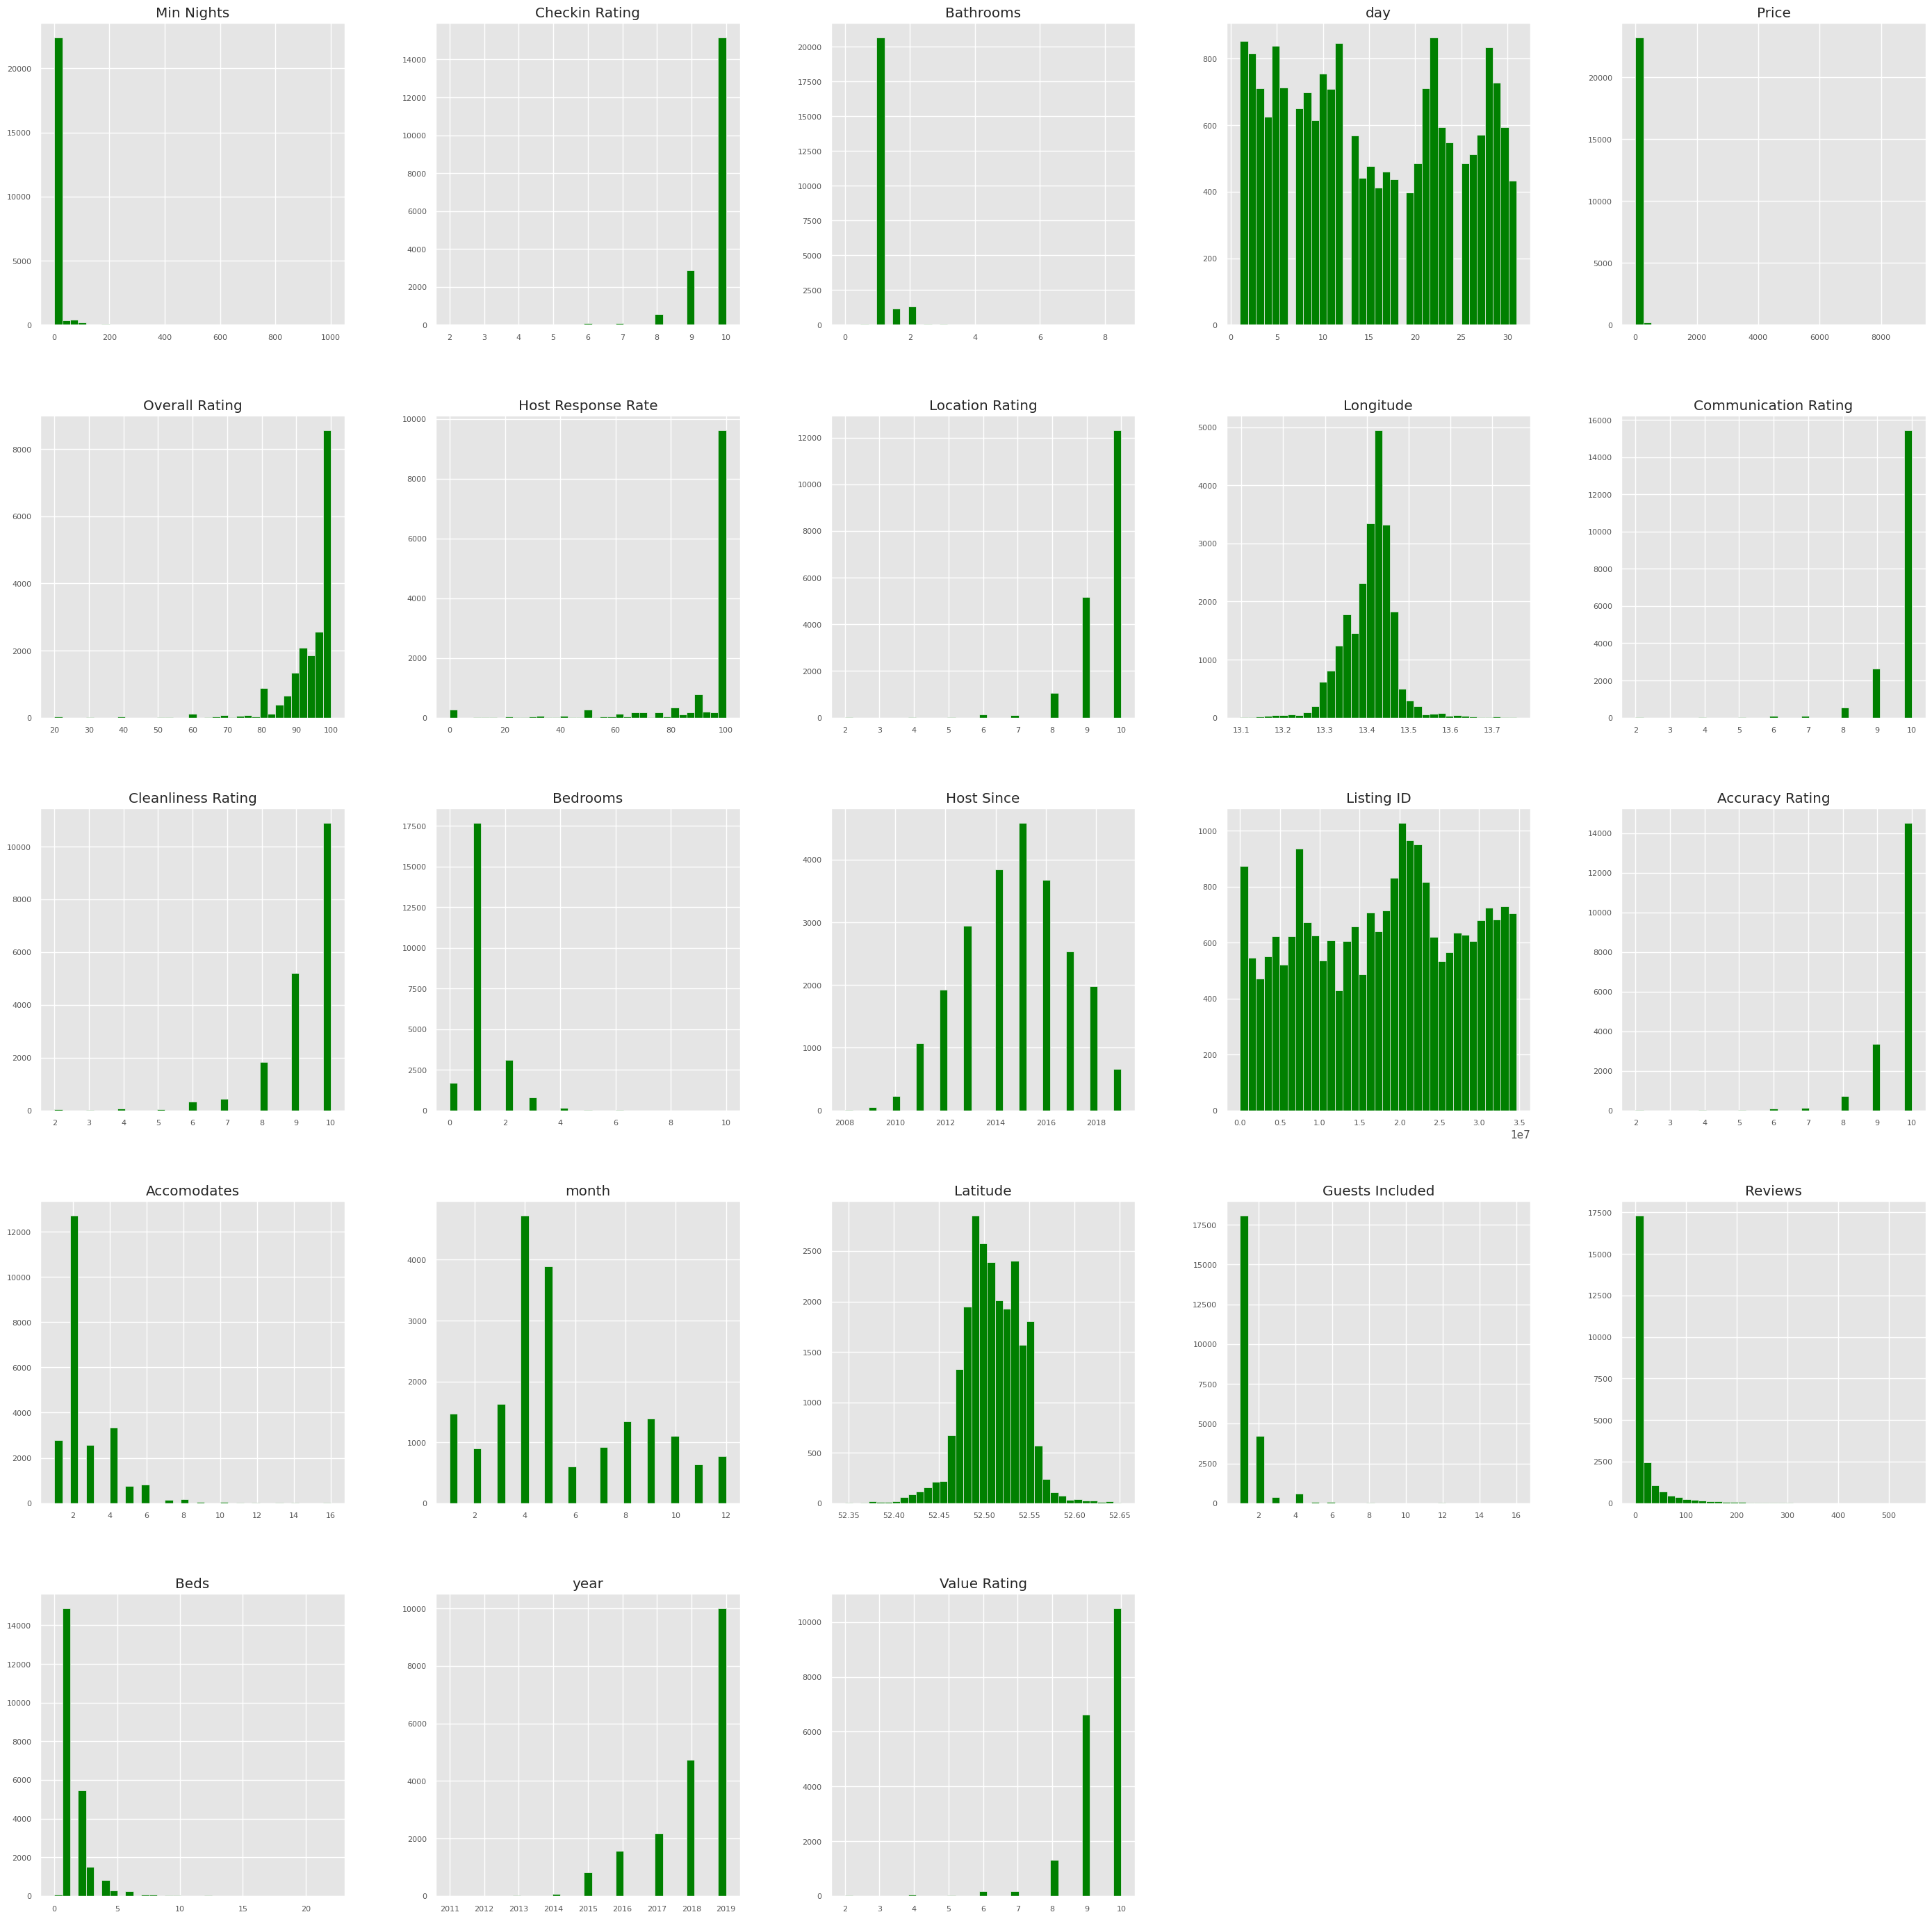

In [103]:
df_num_non_dummy.hist(figsize=(35, 35), bins=35, xlabelsize=8, ylabelsize=8, color = "green");

We can see that data is skewed, let's measure the asymmetry of the distribution:

In [104]:
def highlight(cell_value):
    highlight = 'background-color: mediumspringgreen;'
    default = ''
    negative = 'background-color: hotpink;'
    if cell_value > 1:
        return highlight
    elif cell_value < -1:
        return negative
    #else
       # return default
pd.DataFrame(df_num_non_dummy.skew(),columns=['skewness']).sort_values(by='skewness', ascending=False).style.applymap(highlight)

we can see in the pink all the columns are positively skewed (skewness > 1), 9 columns.

in the green we can see columns are negativley skewed (skewness < -1), 10 columns.

later we'll see if outliers or missing values can affect the features distribution.

In [105]:
for i in df_dummy.columns:
 print(i)




Is Superhost
Instant Bookable
Is Exact Location


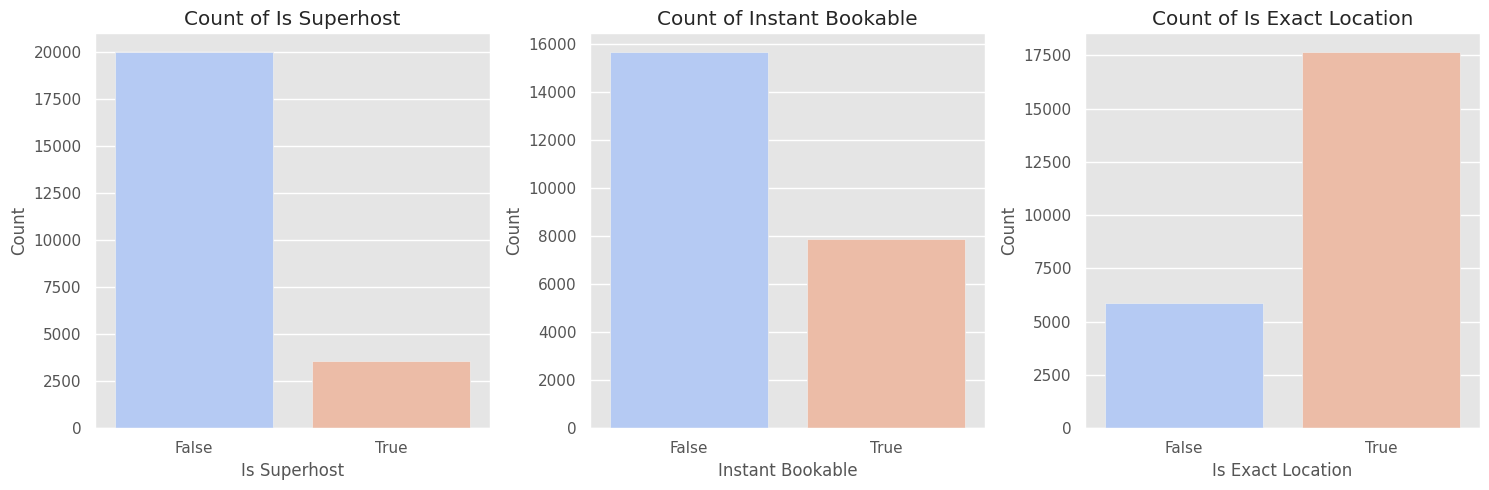

In [106]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Loop through each column and create a count plot
for i, col in enumerate(df_dummy.columns):
    sns.countplot(x=df_dummy[col], ax=axes[i], palette="coolwarm")
    axes[i].set_title(f'Count of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")

plt.tight_layout()
plt.show()

In [107]:
df_categorial

Postal Code Cleansed Neighbourhood Grouped Cleansed        Room Type  \
0                       10                         Pankow     Private room   
1                       10                         Pankow  Entire home/apt   
2                       10                         Pankow     Private room   
3                       10                         Pankow  Entire home/apt   
4                       10                         Pankow  Entire home/apt   
...                    ...                            ...              ...   
23531                   14          Steglitz - Zehlendorf  Entire home/apt   
23532                   13                          Mitte     Private room   
23533                   12                      NeukÃ¶lln     Private room   
23534                   12            Treptow - KÃ¶penick  Entire home/apt   
23535                   13                         Pankow  Entire home/apt   

      Host Response Rate Cleansed    neighbourhood  Host Response Time  \
0                    Low Response  Prenzlauer Berg        within a day   
1                    Low Response  Prenzlauer Berg        within a day   
2              Very High Response  Prenzlauer Berg      within an hour   
3              Very High Response  Prenzlauer Berg        within a day   
4              Very High Response  Prenzlauer Berg        within a day   
...                           ...              ...                 ...   
23531           Moderate Response          Wannsee  within a few hours   
23532                         NaN            Mitte                None   
23533                         NaN            Britz                None   
23534                         NaN        KÃ¶penick                None   
23535                         NaN       WeiÃensee                None   

      Property Type Cleansed  
0                  Apartment  
1                  Apartment  
2                  Apartment  
3                  Apartment  
4                  Apartment  
...                      ...  
23531              Apartment  
23532              Apartment  
23533              Apartment  
23534              Apartment  
23535              Apartment  

[23536 rows x 7 columns]

In [108]:
df_categorial.shape

(23536, 7)

In [109]:
# a = 8  # number of rows
# b = 1  # number of columns
# c = 1  # plot counter

# fig = plt.figure(figsize=(50,80))
# plt.subplots_adjust(hspace = 0.1)
# sns.set(font_scale = 2.5)
# for i in df_categorial:
# #        plt.subplot(a, b, c)
#         plt.title('{}'.format(i))
#         plt.xlabel(i)
#         sns.countplot(df_categorial[i],palette="coolwarm")
#         c = c + 1

# plt.show()

In [110]:
df['Price'].describe()

count    23536.000000
mean        69.612424
std        216.660408
min          0.000000
25%         32.000000
50%         49.000000
75%         75.000000
max       9000.000000
Name: Price, dtype: float64

we can aee that max price is  9000, but the 75% quantile is 75 ,
so we need to remove the extream values during the outliers phase

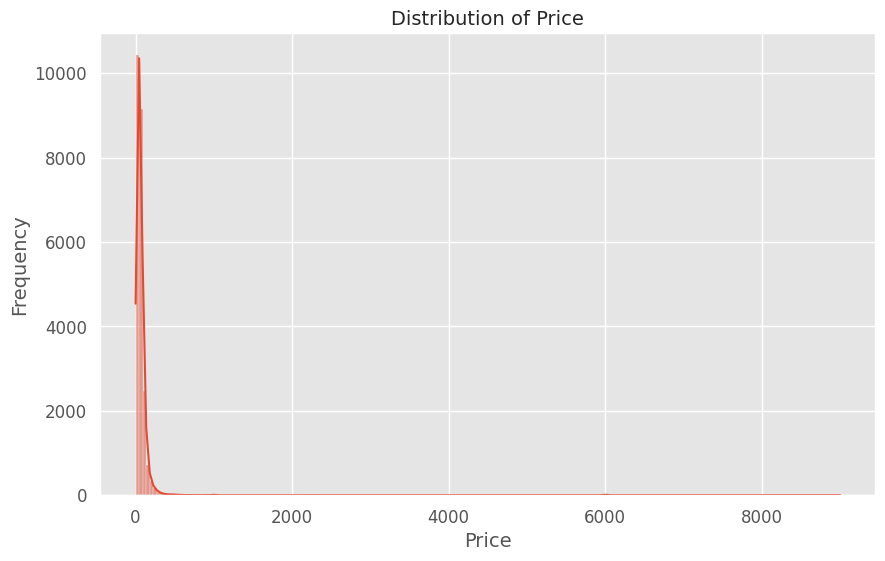

In [111]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Price'], bins=200, kde=True )
plt.title("Distribution of Price",fontsize=14)
plt.xlabel("Price",fontsize=14)
plt.ylabel("Frequency",fontsize=14)
plt.tick_params(axis='both', labelsize=12)  # 'both' for both x and y axis
plt.show()

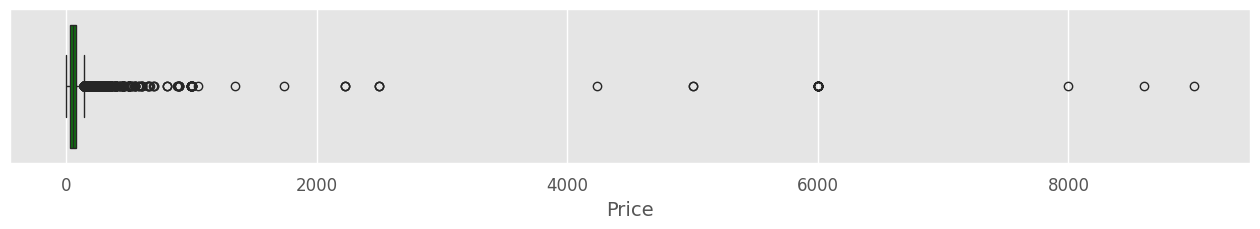

In [112]:
plt.figure(figsize=(16, 2))
sns.boxplot(df['Price'], orient='h',color='green')
plt.tick_params(axis='both', labelsize=12)  # 'both' for both x and y axis
plt.xlabel("Price",fontsize=14)
plt.show()

In [113]:
df.head()
# corr = df.corr(method = 'spearman')
# corr.style.background_gradient(cmap='coolwarm').set_precision(4)

Listing ID  Overall Rating  Accuracy Rating  Cleanliness Rating  \
0        2695           100.0             10.0                10.0   
1        3176            92.0              9.0                 9.0   
2        7071            96.0             10.0                10.0   
3        9991           100.0             10.0                10.0   
4       14325            93.0             10.0                10.0   

   Checkin Rating  Communication Rating  Location Rating  Value Rating  Price  \
0            10.0                  10.0              9.0          10.0   17.0   
1             9.0                   9.0             10.0           9.0   90.0   
2            10.0                  10.0             10.0          10.0   33.0   
3            10.0                  10.0             10.0          10.0  180.0   
4             9.0                  10.0              9.0           9.0   70.0   

   Reviews  Bedrooms  Beds  Bathrooms  Host Response Rate  Is Superhost  \
0      7.0       1.0   1.0        1.0                50.0         False   
1    144.0       1.0   2.0        1.0                50.0         False   
2    229.0       1.0   2.0        1.0               100.0          True   
3      6.0       4.0   7.0        2.5               100.0         False   
4     23.0       0.0   1.0        1.0               100.0         False   

   Latitude  Longitude  Accomodates  Guests Included  Min Nights  \
0  52.54851   13.40455            2                1           2   
1  52.53500   13.41758            4                2          62   
2  52.54316   13.41509            2                1           2   
3  52.53303   13.41605            7                5           6   
4  52.54785   13.40556            1                1          90   

   Instant Bookable  Host Since  Is Exact Location Host Response Time  \
0             False      2008.0               True       within a day   
1             False      2008.0               True       within a day   
2             False      2009.0               True     within an hour   
3             False      2009.0              False       within a day   
4             False      2009.0               True       within a day   

     neighbourhood        Room Type Host Response Rate Cleansed  \
0  Prenzlauer Berg     Private room                Low Response   
1  Prenzlauer Berg  Entire home/apt                Low Response   
2  Prenzlauer Berg     Private room          Very High Response   
3  Prenzlauer Berg  Entire home/apt          Very High Response   
4  Prenzlauer Berg  Entire home/apt          Very High Response   

  Neighbourhood Grouped Cleansed Property Type Cleansed Postal Code Cleansed  \
0                         Pankow              Apartment                   10   
1                         Pankow              Apartment                   10   
2                         Pankow              Apartment                   10   
3                         Pankow              Apartment                   10   
4                         Pankow              Apartment                   10   

     year  month   day  
0  2019.0    4.0  21.0  
1  2018.0   10.0  29.0  
2  2019.0    5.0   8.0  
3  2018.0    7.0  23.0  
4  2018.0   11.0   1.0

### Missing values

Dataframe containing missing value counts and their frequency:

In [114]:
df_nulls = df.copy()
for col in df_nulls:
    if df_nulls[col].isna().sum() == 0:
        del df_nulls[col]
df_nulls

Overall Rating  Accuracy Rating  Cleanliness Rating  Checkin Rating  \
0               100.0             10.0                10.0            10.0   
1                92.0              9.0                 9.0             9.0   
2                96.0             10.0                10.0            10.0   
3               100.0             10.0                10.0            10.0   
4                93.0             10.0                10.0             9.0   
...               ...              ...                 ...             ...   
23531             NaN              NaN                 NaN             NaN   
23532             NaN              NaN                 NaN             NaN   
23533             NaN              NaN                 NaN             NaN   
23534             NaN              NaN                 NaN             NaN   
23535             NaN              NaN                 NaN             NaN   

       Communication Rating  Location Rating  Value Rating  Bedrooms  Beds  \
0                      10.0              9.0          10.0       1.0   1.0   
1                       9.0             10.0           9.0       1.0   2.0   
2                      10.0             10.0          10.0       1.0   2.0   
3                      10.0             10.0          10.0       4.0   7.0   
4                      10.0              9.0           9.0       0.0   1.0   
...                     ...              ...           ...       ...   ...   
23531                   NaN              NaN           NaN       1.0   2.0   
23532                   NaN              NaN           NaN       2.0   2.0   
23533                   NaN              NaN           NaN       1.0   1.0   
23534                   NaN              NaN           NaN       3.0   4.0   
23535                   NaN              NaN           NaN       2.0   2.0   

       Bathrooms  Host Response Rate  Host Since  Host Response Time  \
0            1.0                50.0      2008.0        within a day   
1            1.0                50.0      2008.0        within a day   
2            1.0               100.0      2009.0      within an hour   
3            2.5               100.0      2009.0        within a day   
4            1.0               100.0      2009.0        within a day   
...          ...                 ...         ...                 ...   
23531        1.0                75.0      2018.0  within a few hours   
23532        1.0                 NaN      2019.0                None   
23533        1.5                 NaN      2014.0                None   
23534        1.0                 NaN      2019.0                None   
23535        1.0                 NaN      2018.0                None   

      Host Response Rate Cleansed    year  month   day  
0                    Low Response  2019.0    4.0  21.0  
1                    Low Response  2018.0   10.0  29.0  
2              Very High Response  2019.0    5.0   8.0  
3              Very High Response  2018.0    7.0  23.0  
4              Very High Response  2018.0   11.0   1.0  
...                           ...     ...    ...   ...  
23531           Moderate Response     NaN    NaN   NaN  
23532                         NaN     NaN    NaN   NaN  
23533                         NaN     NaN    NaN   NaN  
23534                         NaN     NaN    NaN   NaN  
23535                         NaN     NaN    NaN   NaN  

[23536 rows x 17 columns]

In [115]:
mis_val = df_nulls.isna().sum()
mis_val_per = df_nulls.isna().sum()/len(df_nulls)*100
mis_val_table = pd.concat([mis_val, mis_val_per], axis=1)
mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,:] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
mis_val_table_ren_columns

Missing Values  % of Total Values
Host Response Time                    10490               44.6
Host Response Rate                    10490               44.6
Host Response Rate Cleansed           10490               44.6
Value Rating                           4668               19.8
Checkin Rating                         4666               19.8
Location Rating                        4665               19.8
Communication Rating                   4650               19.8
Accuracy Rating                        4648               19.7
Cleanliness Rating                     4644               19.7
Overall Rating                         4622               19.6
month                                  4156               17.7
year                                   4156               17.7
day                                    4156               17.7
Beds                                     35                0.1
Bathrooms                                29                0.1
Host Since                               21                0.1
Bedrooms                                 20                0.1

Creating a dataframe with each of the missing values as 1, while non missing values are 0:

In [116]:
df_missing_data = (df.isna()).astype('int64')
df_missing_data.describe()

Listing ID  Overall Rating  Accuracy Rating  Cleanliness Rating  \
count     23536.0    23536.000000     23536.000000        23536.000000   
mean          0.0        0.196380         0.197485            0.197315   
std           0.0        0.397268         0.398110            0.397980   
min           0.0        0.000000         0.000000            0.000000   
25%           0.0        0.000000         0.000000            0.000000   
50%           0.0        0.000000         0.000000            0.000000   
75%           0.0        0.000000         0.000000            0.000000   
max           0.0        1.000000         1.000000            1.000000   

       Checkin Rating  Communication Rating  Location Rating  Value Rating  \
count    23536.000000          23536.000000     23536.000000  23536.000000   
mean         0.198249              0.197570         0.198207      0.198334   
std          0.398690              0.398174         0.398657      0.398754   
min          0.000000              0.000000         0.000000      0.000000   
25%          0.000000              0.000000         0.000000      0.000000   
50%          0.000000              0.000000         0.000000      0.000000   
75%          0.000000              0.000000         0.000000      0.000000   
max          1.000000              1.000000         1.000000      1.000000   

         Price  Reviews      Bedrooms          Beds     Bathrooms  \
count  23536.0  23536.0  23536.000000  23536.000000  23536.000000   
mean       0.0      0.0      0.000850      0.001487      0.001232   
std        0.0      0.0      0.029139      0.038535      0.035081   
min        0.0      0.0      0.000000      0.000000      0.000000   
25%        0.0      0.0      0.000000      0.000000      0.000000   
50%        0.0      0.0      0.000000      0.000000      0.000000   
75%        0.0      0.0      0.000000      0.000000      0.000000   
max        0.0      0.0      1.000000      1.000000      1.000000   

       Host Response Rate  Is Superhost  Latitude  Longitude  Accomodates  \
count        23536.000000       23536.0   23536.0    23536.0      23536.0   
mean             0.445700           0.0       0.0        0.0          0.0   
std              0.497053           0.0       0.0        0.0          0.0   
min              0.000000           0.0       0.0        0.0          0.0   
25%              0.000000           0.0       0.0        0.0          0.0   
50%              0.000000           0.0       0.0        0.0          0.0   
75%              1.000000           0.0       0.0        0.0          0.0   
max              1.000000           0.0       0.0        0.0          0.0   

       Guests Included  Min Nights  Instant Bookable    Host Since  \
count          23536.0     23536.0           23536.0  23536.000000   
mean               0.0         0.0               0.0      0.000892   
std                0.0         0.0               0.0      0.029858   
min                0.0         0.0               0.0      0.000000   
25%                0.0         0.0               0.0      0.000000   
50%                0.0         0.0               0.0      0.000000   
75%                0.0         0.0               0.0      0.000000   
max                0.0         0.0               0.0      1.000000   

       Is Exact Location  Host Response Time  neighbourhood  Room Type  \
count            23536.0        23536.000000        23536.0    23536.0   
mean                 0.0            0.445700            0.0        0.0   
std                  0.0            0.497053            0.0        0.0   
min                  0.0            0.000000            0.0        0.0   
25%                  0.0            0.000000            0.0        0.0   
50%                  0.0            0.000000            0.0        0.0   
75%                  0.0            1.000000            0.0        0.0   
max                  0.0            1.000000            0.0        0.0   

       Host Response Ra

### Catigories

In [117]:
df_categorial.describe().T

count unique                       top   freq
Postal Code Cleansed            23536      8                        10  14667
Neighbourhood Grouped Cleansed  23536     12  Friedrichshain-Kreuzberg   5718
Room Type                       23536      3              Private room  11694
Host Response Rate Cleansed     13046      4        Very High Response   9752
neighbourhood                   23536     93                 NeukÃ¶lln   3444
Host Response Time              13046      4            within an hour   6816
Property Type Cleansed          23536     15                 Apartment  20935

In [118]:
# i = 1
# plt.figure(figsize=(40, 40))
# plt.subplots_adjust(hspace = 0.5)
# for col in df_categorial.columns:
#   plt.subplot(5, 2, i)
#   plt.title(f"Distribution of `{col}`", fontsize=12, fontweight="bold")
#   plt.xlabel(col, fontsize=10)
#   plt.xticks(rotation=50, fontsize=14)
#   plt.ylabel("Count")
#   sns.countplot(data=df, x=col, palette="plasma")
#   i = i + 1

# plt.tight_layout()
# plt.show()

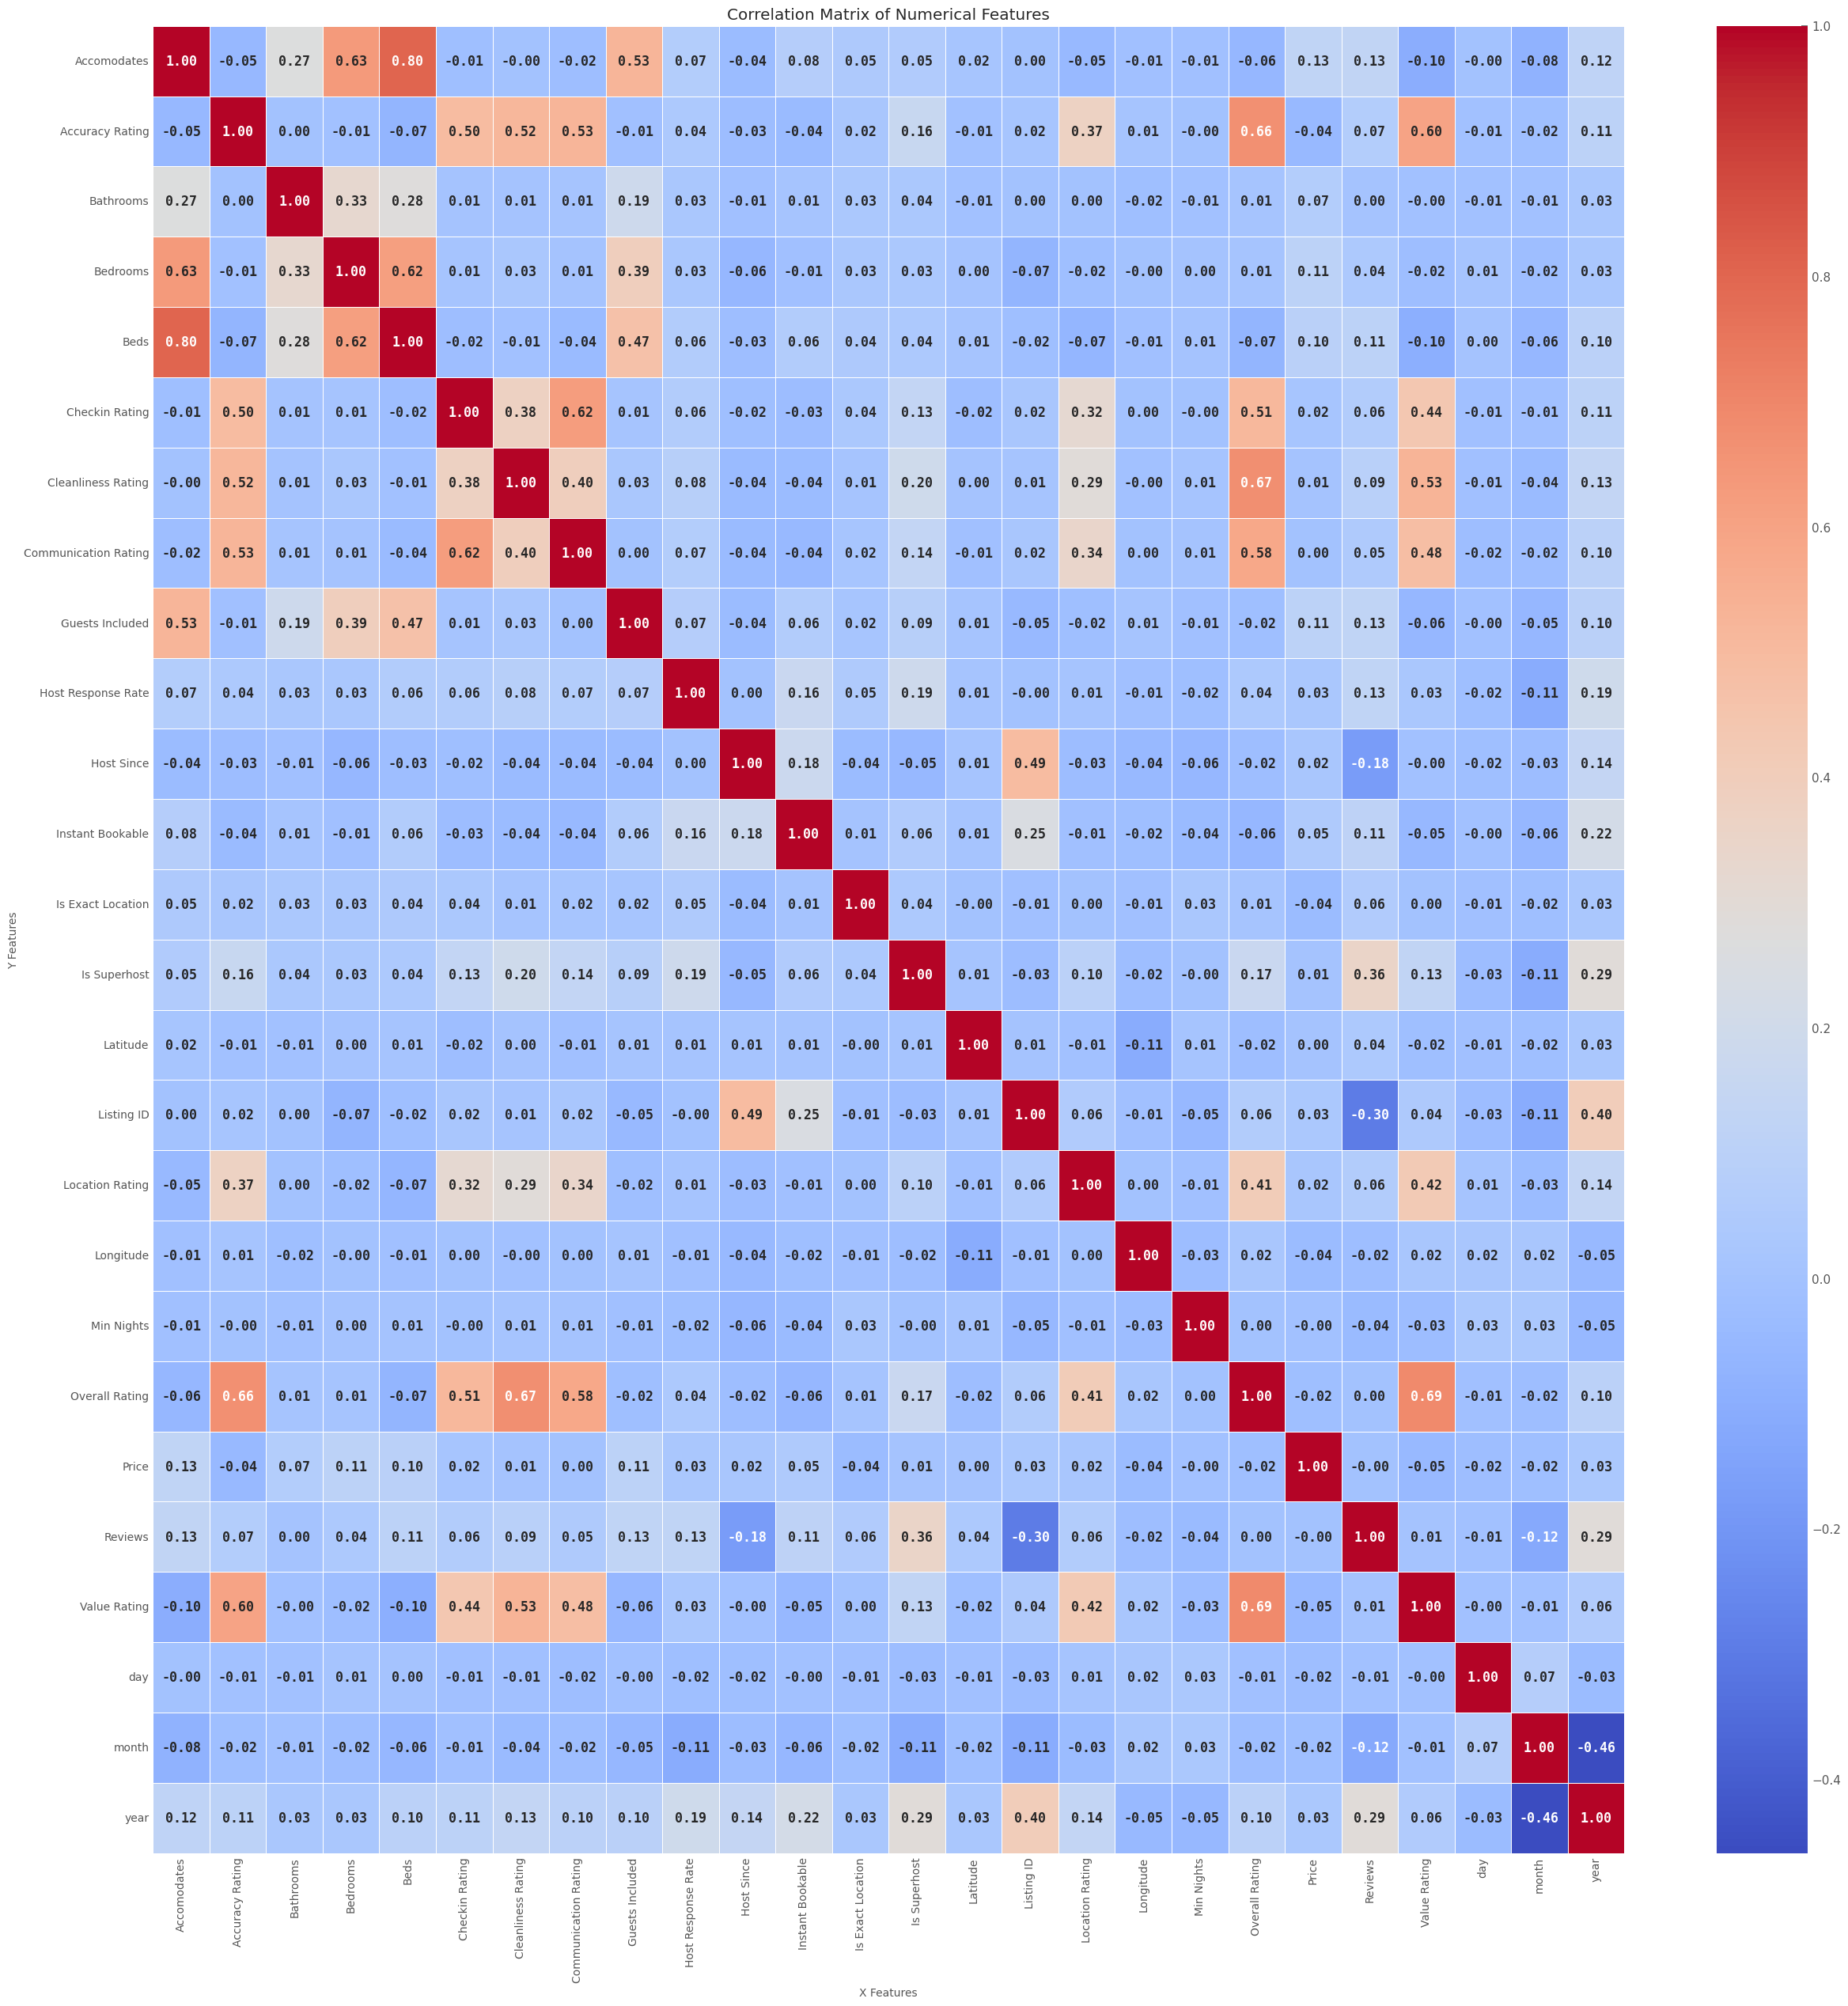

In [119]:
plt.style.use('bmh')
plt.figure(figsize=(30, 30))
correlation_matrix = df[df_num.union(df_dummy.columns)].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5 , annot_kws={"size": 12, "weight": "bold", "family": "monospace"})
plt.xlabel("X Features", fontsize=10)
plt.ylabel("Y Features", fontsize=10)
plt.title("Heatmap Example", fontsize=10)
plt.title("Correlation Matrix of Numerical Features")
plt.tick_params(axis='both', labelsize=10)
plt.show()

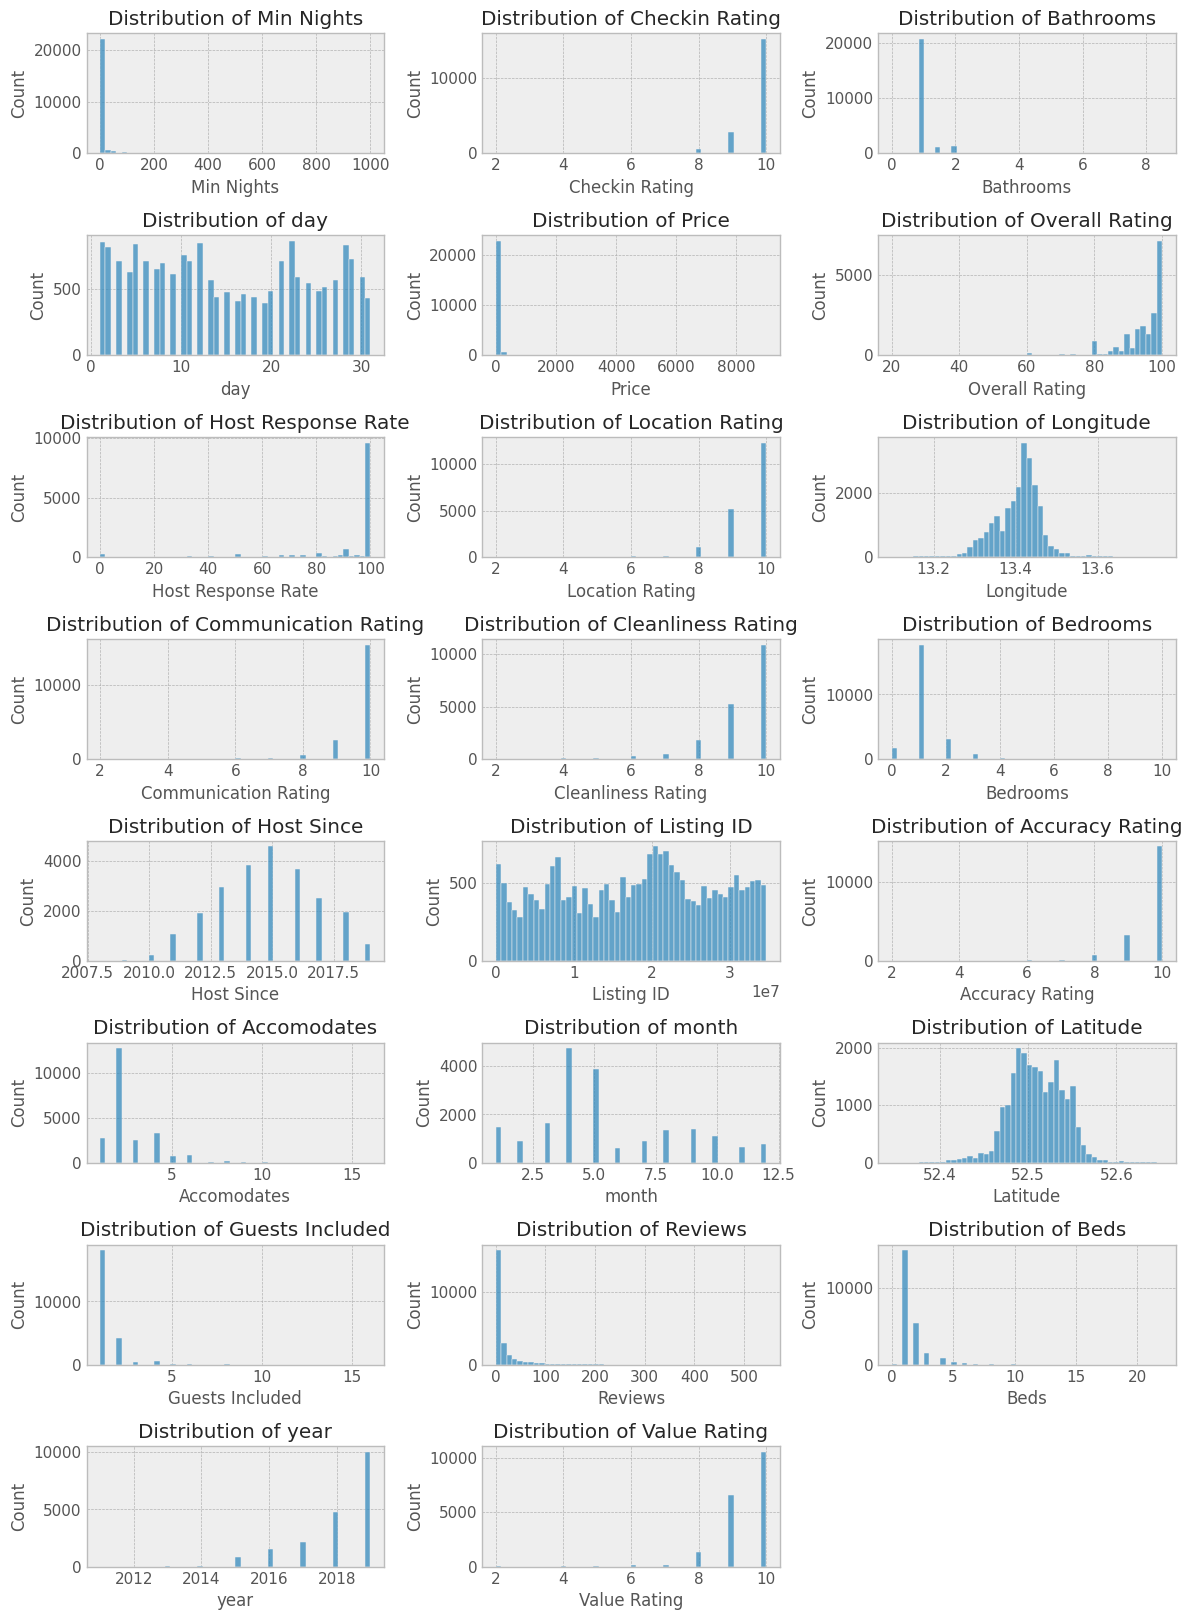

In [120]:
plt.figure(figsize=(12, 30))
plt.subplots_adjust(hspace = 0.5)
for i, col in enumerate(df_num_non_dummy, 1):
  plt.subplot(15, 3, i)
  sns.histplot(df[col].dropna(), bins=50, kde=False)
  plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

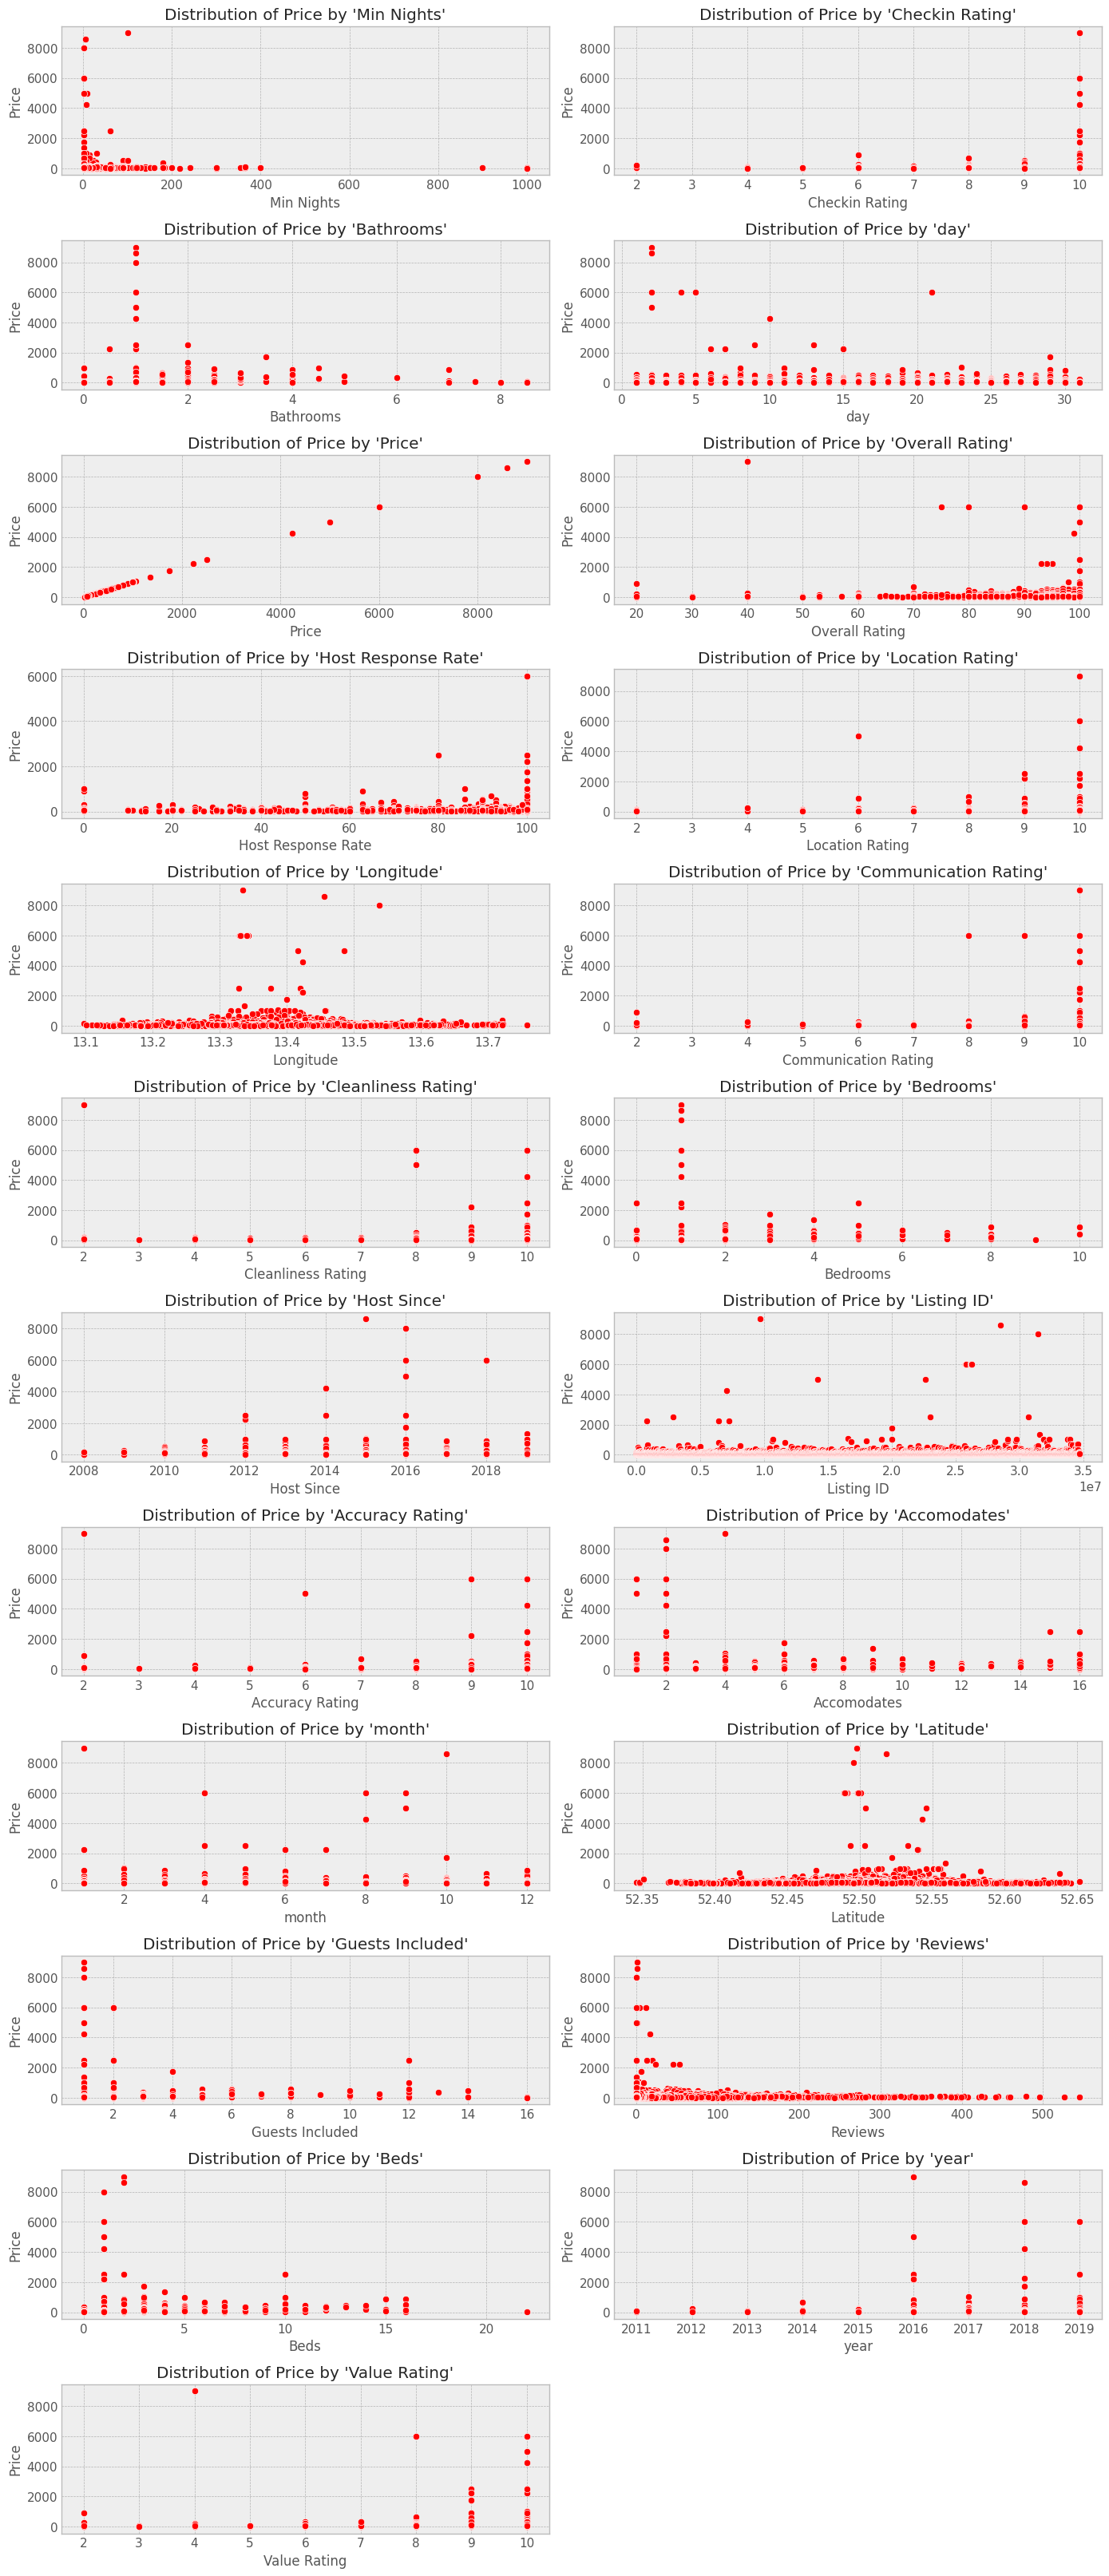

In [121]:
bar_plot_columns = ['Bedrooms', 'Bathrooms', 'Beds']
plt.figure(figsize=(14, 40))
plt.subplots_adjust(hspace = 0.5)
i = 1
for col in df_num_non_dummy.columns:
  plt.subplot(15, 2, i)
  sns.scatterplot(x=df[col], y=df['Price'], color='red')
  plt.title(f"Distribution of Price by '{col}'")

  # plt.subplot(3, 2, i+1)
  # sns.barplot(x=df[col], y=df['Price'], errcolor="red")
  # plt.title(f"Distribution of Price by '{col}'")
  # plt.axvline(df[col].mean(), color='red', linestyle='dashed', linewidth=2)
  # plt.axvline(df[col].median(), color='green', linestyle='dashed', linewidth=2)

  i = i + 1
plt.tight_layout()
plt.show()

In [33]:
# from sklearn.preprocessing import LabelEncoder

# le = LabelEncoder()
# for col in df_categorial:
#   df[f"{col} Encoded"] = le.fit_transform(df[col])

# df.drop(columns=df_categorial.columns, inplace=True)
# df.head()


Listing ID  Overall Rating  Accuracy Rating  Cleanliness Rating  \
0        2695           100.0             10.0                10.0   
1        3176            92.0              9.0                 9.0   
2        7071            96.0             10.0                10.0   
3        9991           100.0             10.0                10.0   
4       14325            93.0             10.0                10.0   

   Checkin Rating  Communication Rating  Location Rating  Value Rating  Price  \
0            10.0                  10.0              9.0          10.0   17.0   
1             9.0                   9.0             10.0           9.0   90.0   
2            10.0                  10.0             10.0          10.0   33.0   
3            10.0                  10.0             10.0          10.0  180.0   
4             9.0                  10.0              9.0           9.0   70.0   

   Reviews  Bedrooms  Beds  Bathrooms  Host Response Rate  Is Superhost  \
0      7.0       1.0   1.0        1.0                50.0         False   
1    144.0       1.0   2.0        1.0                50.0         False   
2    229.0       1.0   2.0        1.0               100.0          True   
3      6.0       4.0   7.0        2.5               100.0         False   
4     23.0       0.0   1.0        1.0               100.0         False   

   Latitude  Longitude  Accomodates  Guests Included  Min Nights  \
0  52.54851   13.40455            2                1           2   
1  52.53500   13.41758            4                2          62   
2  52.54316   13.41509            2                1           2   
3  52.53303   13.41605            7                5           6   
4  52.54785   13.40556            1                1          90   

   Instant Bookable  Host Since  Is Exact Location    year  month   day  \
0             False      2008.0               True  2019.0    4.0  21.0   
1             False      2008.0               True  2018.0   10.0  29.0   
2             False      2009.0               True  2019.0    5.0   8.0   
3             False      2009.0              False  2018.0    7.0  23.0   
4             False      2009.0               True  2018.0   11.0   1.0   

   Postal Code Cleansed Encoded  Neighbourhood Grouped Cleansed Encoded  \
0                             0                                       6   
1                             0                                       6   
2                             0                                       6   
3                             0                                       6   
4                             0                                       6   

   Room Type Encoded  Host Response Rate Cleansed Encoded  \
0                  1                                    1   
1                  0                                    1   
2                  1                                    3   
3                  0                                    3   
4                  0                                    3   

   neighbourhood Encoded  Host Response Time Encoded  \
0                     65                           1   
1                     65                           1   
2                     65                           3   
3                     65                           1   
4                     65                           1   

   Property Type Cleansed Encoded  
0                               0  
1                               0  
2                               0  
3                               0  
4                               0

In [122]:
plt.figure(figsize=(30, 20))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Numerical Features")
plt.show()

ValueError: could not convert string to float: 'within a day'

<Figure size 3000x2000 with 0 Axes>

In [35]:
corr = df.corr(method = 'spearman')
corr.style.background_gradient(cmap='coolwarm')

In [36]:
from scipy import stats
df_corr= pd.DataFrame(columns=('v1','v2','abscorr','origcorr','pval'))

for i in df_num:
        for j in df_num:
                if i > j:
                        a=stats.spearmanr(df[i], df[j],nan_policy='omit')
                        b="{}/{}".format(i,j)
                        df_corr.loc[b] =[i,j,abs(a[0]),a[0],a[1]]

df_corr_filtered= df_corr.loc[(df_corr['abscorr']>0.7 ) & (df_corr['pval']<0.05)]
df_corr_filtered.sort_values(by=['abscorr'],ascending=False)

v1           v2   abscorr  origcorr  pval
Beds/Accomodates  Beds  Accomodates  0.718802  0.718802   0.0

### Outliers


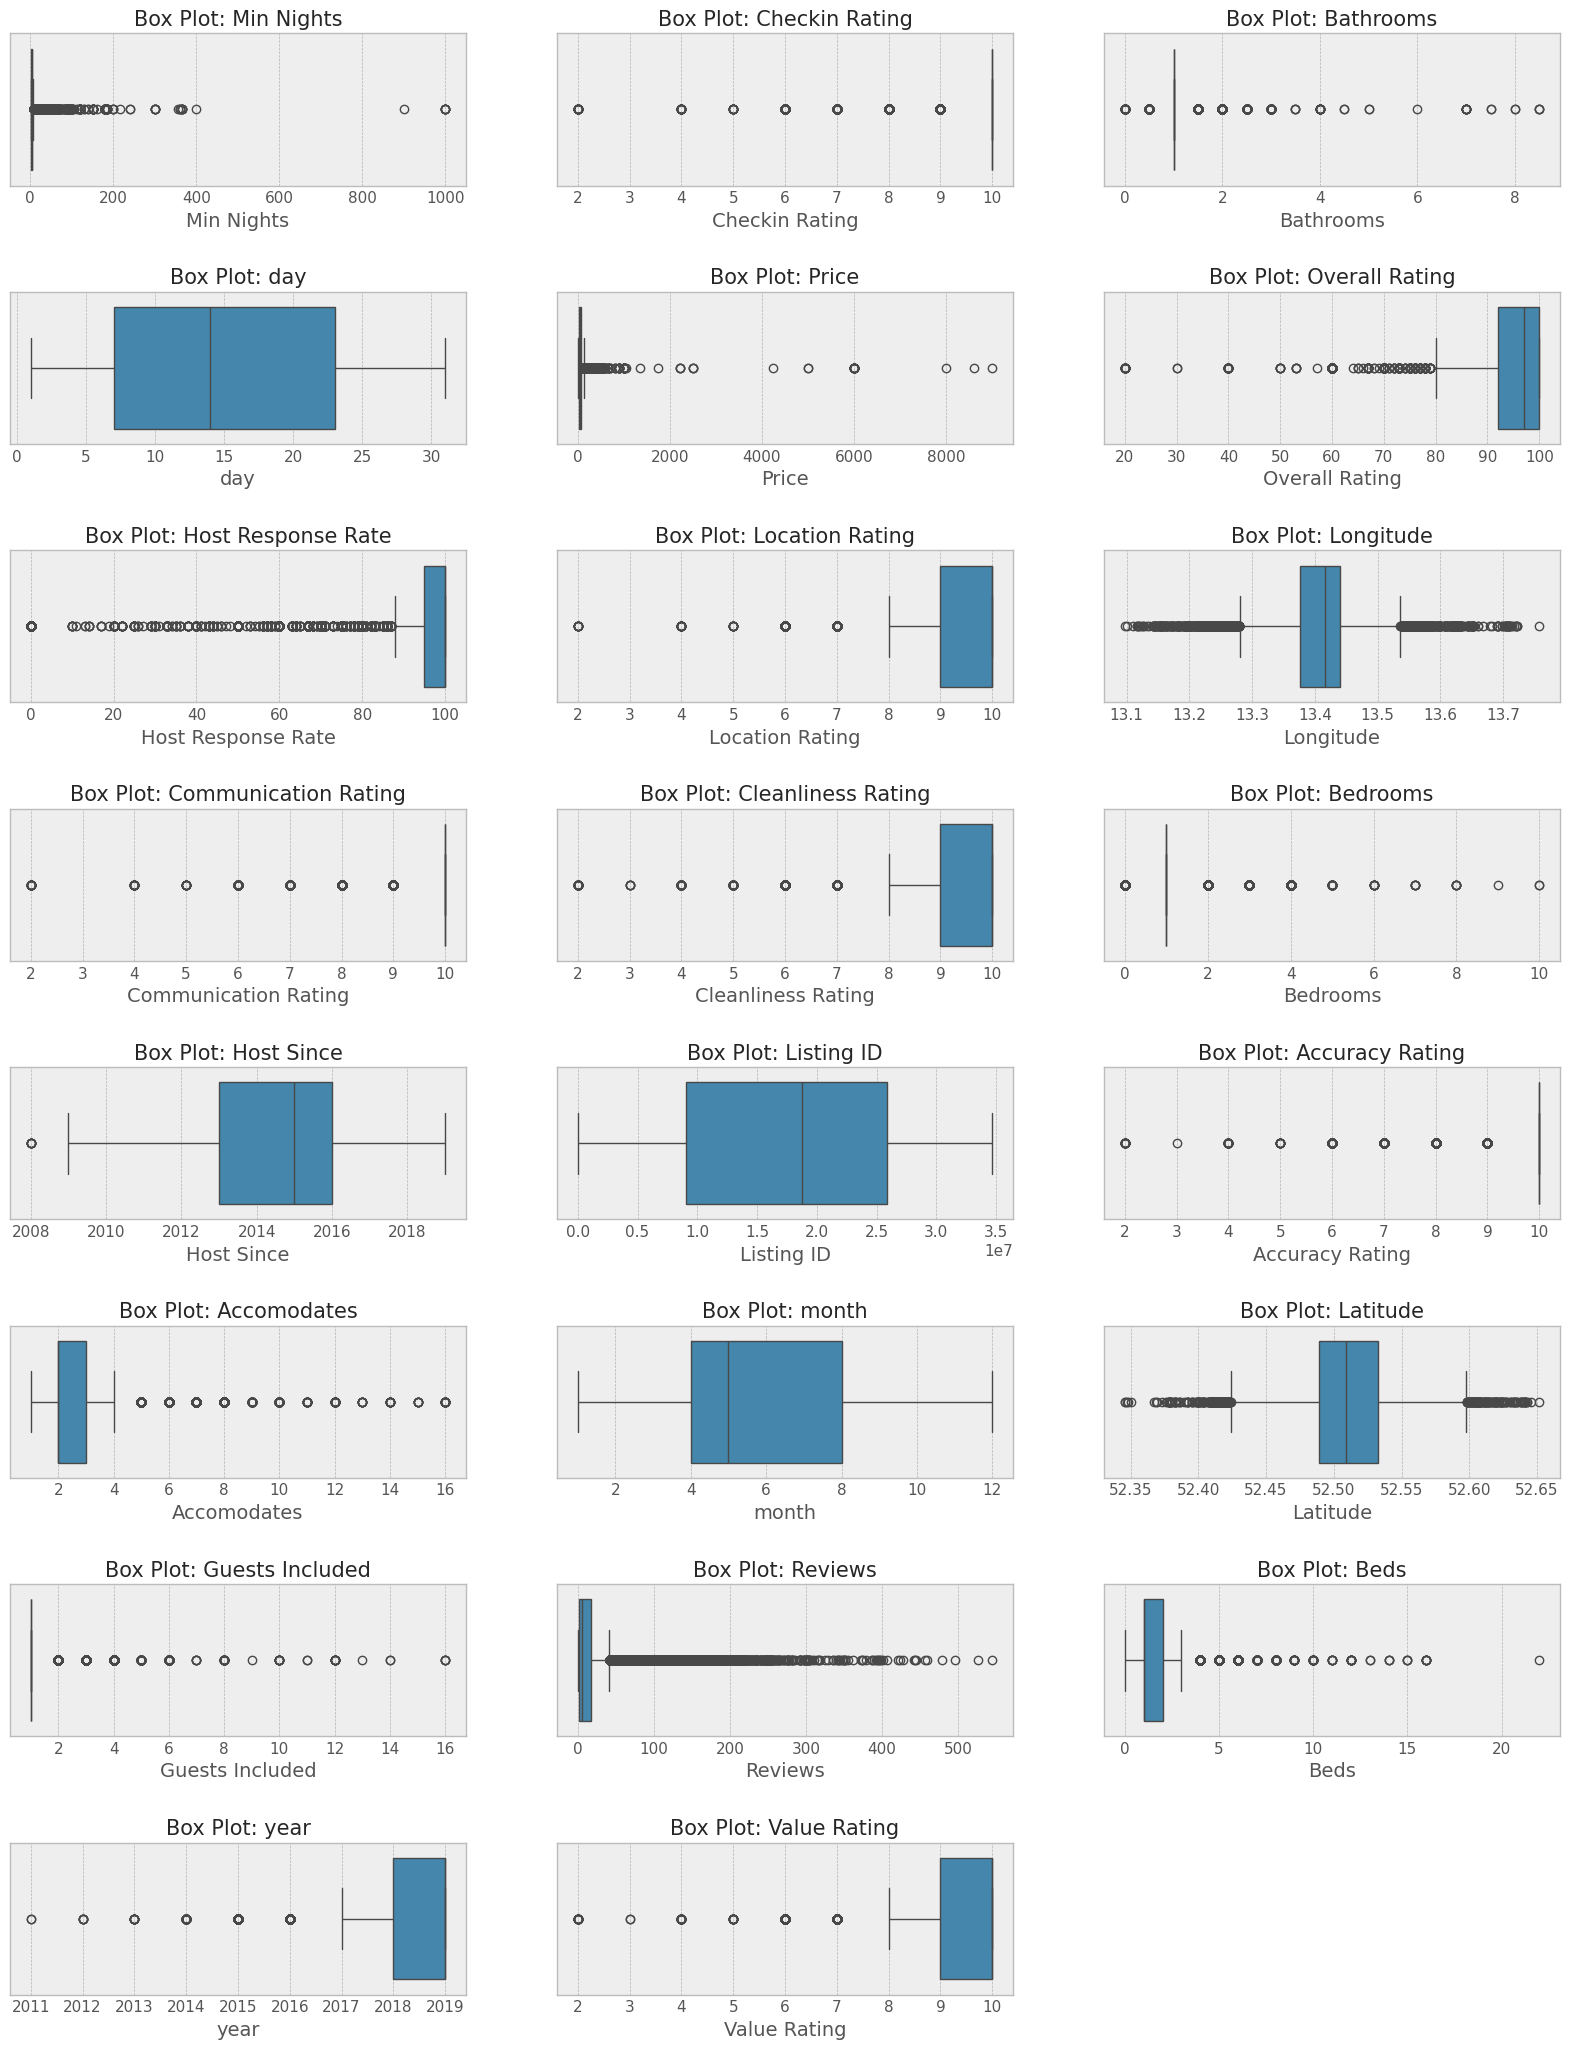

In [37]:
plt.figure(figsize=(20,200))

def outliers_boxplot(df):
    for i, col in enumerate(df.columns):
        if col != 'host_is_superhost':
            ax = plt.subplot(60, 3, i+1)
            sns.boxplot(data=df, x=col, ax=ax)
            plt.subplots_adjust(hspace = 0.7)
            plt.title('Box Plot: {}'.format(col), fontsize=15)
            plt.xlabel('{}'.format(col), fontsize=14)

outliers_boxplot(df_num_non_dummy)

### Missing values

<Axes: >

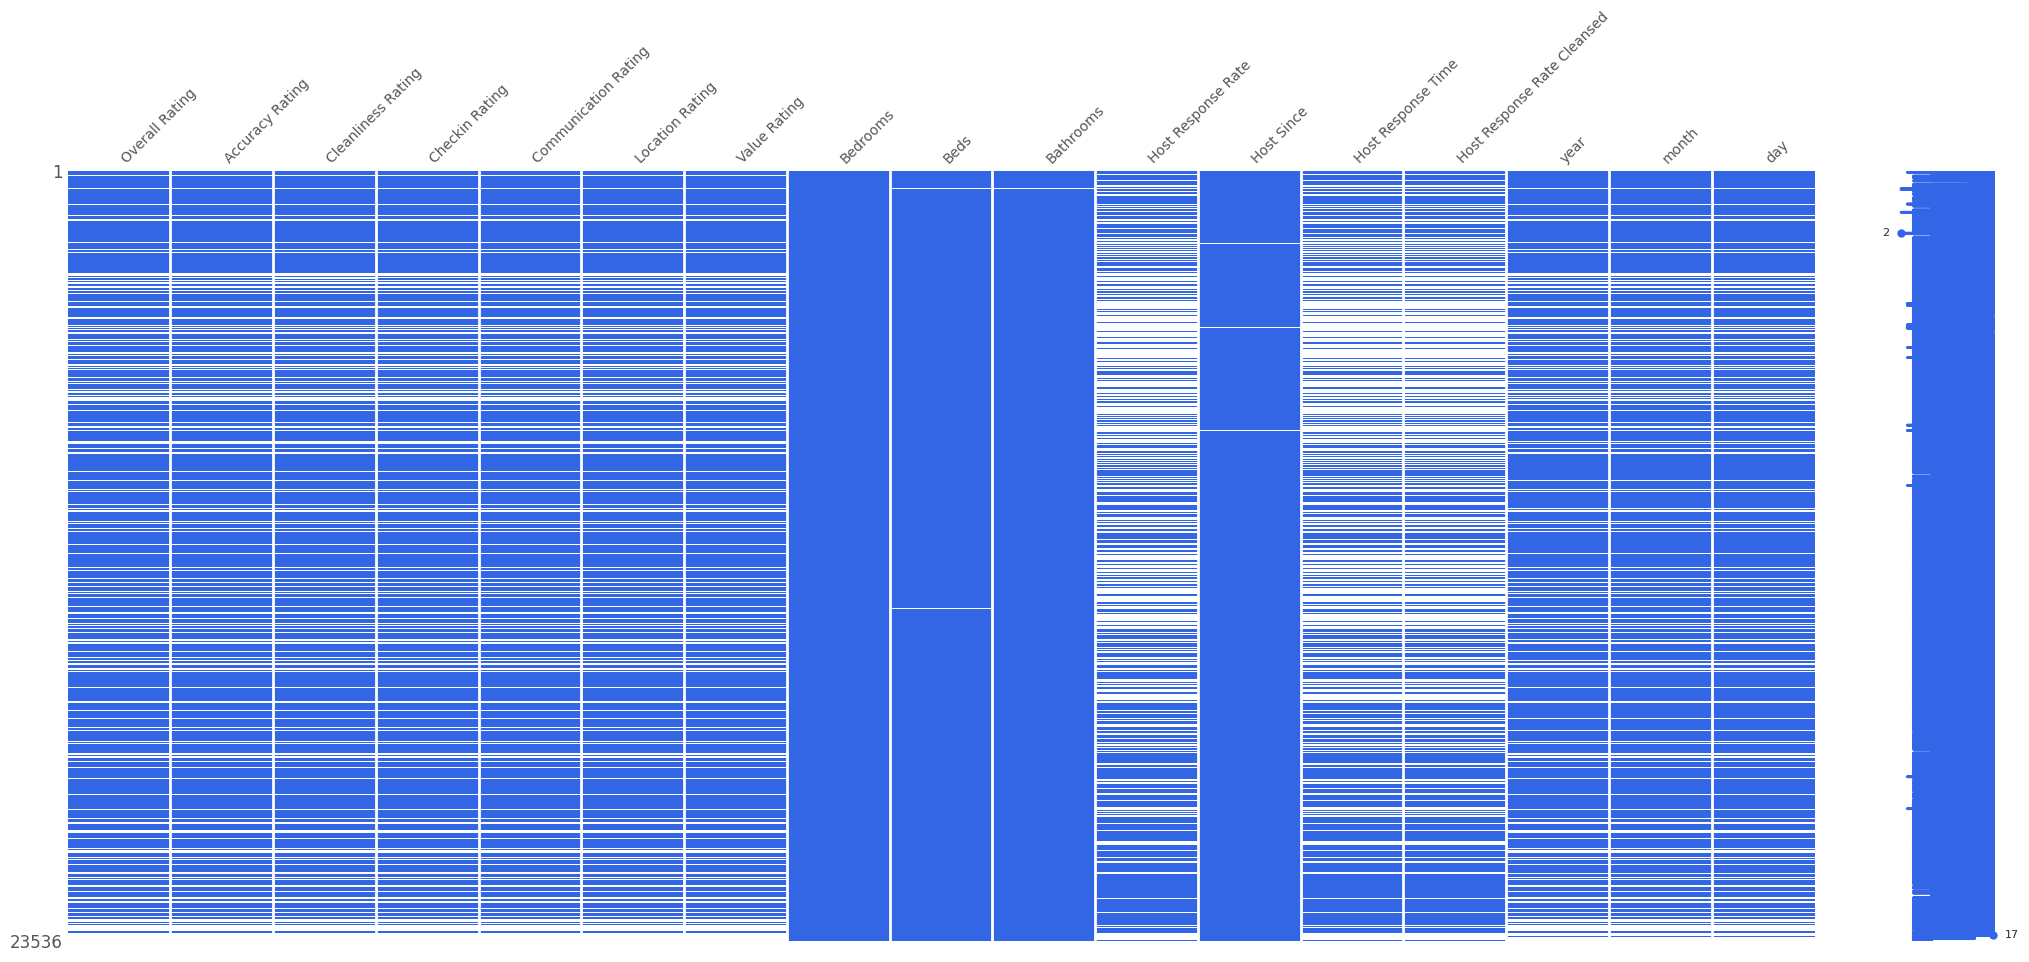

In [38]:
msno.matrix(df_nulls,color=(0.2, 0.4, 0.9),fontsize=10)

Dataframe containing missing value counts and their frequency:

In [39]:
mis_val = df_nulls.isna().sum()
mis_val_per = df_nulls.isna().sum()/len(df_nulls)*100
mis_val_per
mis_val_table = pd.concat([mis_val, mis_val_per], axis=1)
mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,:] != 0].sort_values(
     '% of Total Values', ascending=False).round(1)
mis_val_table_ren_columns

Missing Values  % of Total Values
Host Response Time                    10490               44.6
Host Response Rate                    10490               44.6
Host Response Rate Cleansed           10490               44.6
Value Rating                           4668               19.8
Checkin Rating                         4666               19.8
Location Rating                        4665               19.8
Communication Rating                   4650               19.8
Accuracy Rating                        4648               19.7
Cleanliness Rating                     4644               19.7
Overall Rating                         4622               19.6
month                                  4156               17.7
year                                   4156               17.7
day                                    4156               17.7
Beds                                     35                0.1
Bathrooms                                29                0.1
Host Since                               21                0.1
Bedrooms                                 20                0.1

Creating a dataframe with each of the missing values as 1, while non missing values are 0:

In [40]:
pd.set_option('display.max_columns', None)
df_missing_data = (df.isna()).astype('int64')
df_missing_data.describe()

Listing ID  Overall Rating  Accuracy Rating  Cleanliness Rating  \
count     23536.0    23536.000000     23536.000000        23536.000000   
mean          0.0        0.196380         0.197485            0.197315   
std           0.0        0.397268         0.398110            0.397980   
min           0.0        0.000000         0.000000            0.000000   
25%           0.0        0.000000         0.000000            0.000000   
50%           0.0        0.000000         0.000000            0.000000   
75%           0.0        0.000000         0.000000            0.000000   
max           0.0        1.000000         1.000000            1.000000   

       Checkin Rating  Communication Rating  Location Rating  Value Rating  \
count    23536.000000          23536.000000     23536.000000  23536.000000   
mean         0.198249              0.197570         0.198207      0.198334   
std          0.398690              0.398174         0.398657      0.398754   
min          0.000000              0.000000         0.000000      0.000000   
25%          0.000000              0.000000         0.000000      0.000000   
50%          0.000000              0.000000         0.000000      0.000000   
75%          0.000000              0.000000         0.000000      0.000000   
max          1.000000              1.000000         1.000000      1.000000   

         Price  Reviews      Bedrooms          Beds     Bathrooms  \
count  23536.0  23536.0  23536.000000  23536.000000  23536.000000   
mean       0.0      0.0      0.000850      0.001487      0.001232   
std        0.0      0.0      0.029139      0.038535      0.035081   
min        0.0      0.0      0.000000      0.000000      0.000000   
25%        0.0      0.0      0.000000      0.000000      0.000000   
50%        0.0      0.0      0.000000      0.000000      0.000000   
75%        0.0      0.0      0.000000      0.000000      0.000000   
max        0.0      0.0      1.000000      1.000000      1.000000   

       Host Response Rate  Is Superhost  Latitude  Longitude  Accomodates  \
count        23536.000000       23536.0   23536.0    23536.0      23536.0   
mean             0.445700           0.0       0.0        0.0          0.0   
std              0.497053           0.0       0.0        0.0          0.0   
min              0.000000           0.0       0.0        0.0          0.0   
25%              0.000000           0.0       0.0        0.0          0.0   
50%              0.000000           0.0       0.0        0.0          0.0   
75%              1.000000           0.0       0.0        0.0          0.0   
max              1.000000           0.0       0.0        0.0          0.0   

       Guests Included  Min Nights  Instant Bookable    Host Since  \
count          23536.0     23536.0           23536.0  23536.000000   
mean               0.0         0.0               0.0      0.000892   
std                0.0         0.0               0.0      0.029858   
min                0.0         0.0               0.0      0.000000   
25%                0.0         0.0               0.0      0.000000   
50%                0.0         0.0               0.0      0.000000   
75%                0.0         0.0               0.0      0.000000   
max                0.0         0.0               0.0      1.000000   

       Is Exact Location          year         month           day  \
count            23536.0  23536.000000  23536.000000  23536.000000   
mean                 0.0      0.176581      0.176581      0.176581   
std                  0.0      0.381321      0.381321      0.381321   
min                  0.0      0.000000      0.000000      0.000000   
25%                  0.0      0.000000      0.000000      0.000000   
50%                  0.0      0.000000      0.000000      0.000000   
75%                  0.0      0.000000      0.000000      0.000000   
max                  0.0      1.000000      1.000000      1.000000   

       Postal Code Cleansed Encoded  Neighbourhood Grouped 

### Data Cleansing

<Axes: >

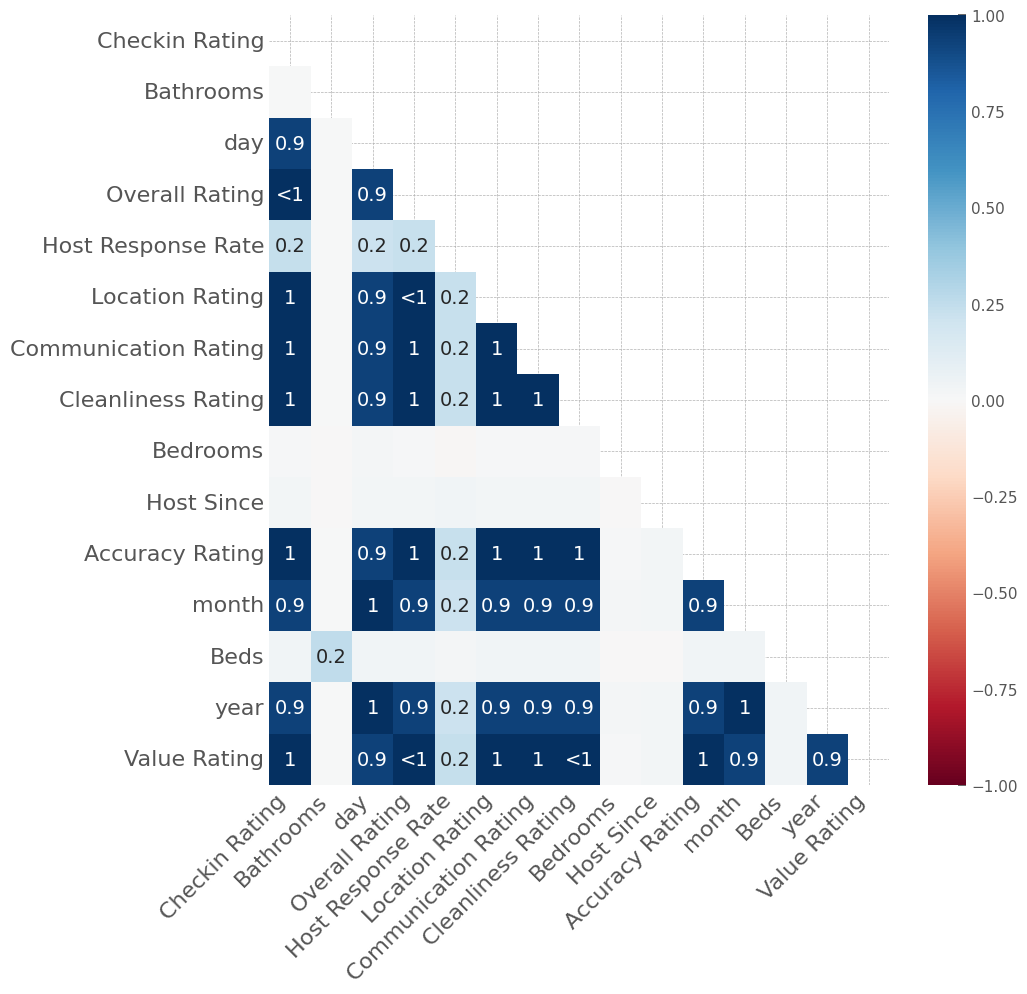

In [41]:
msno.heatmap(df_num_non_dummy,figsize=(10,10))

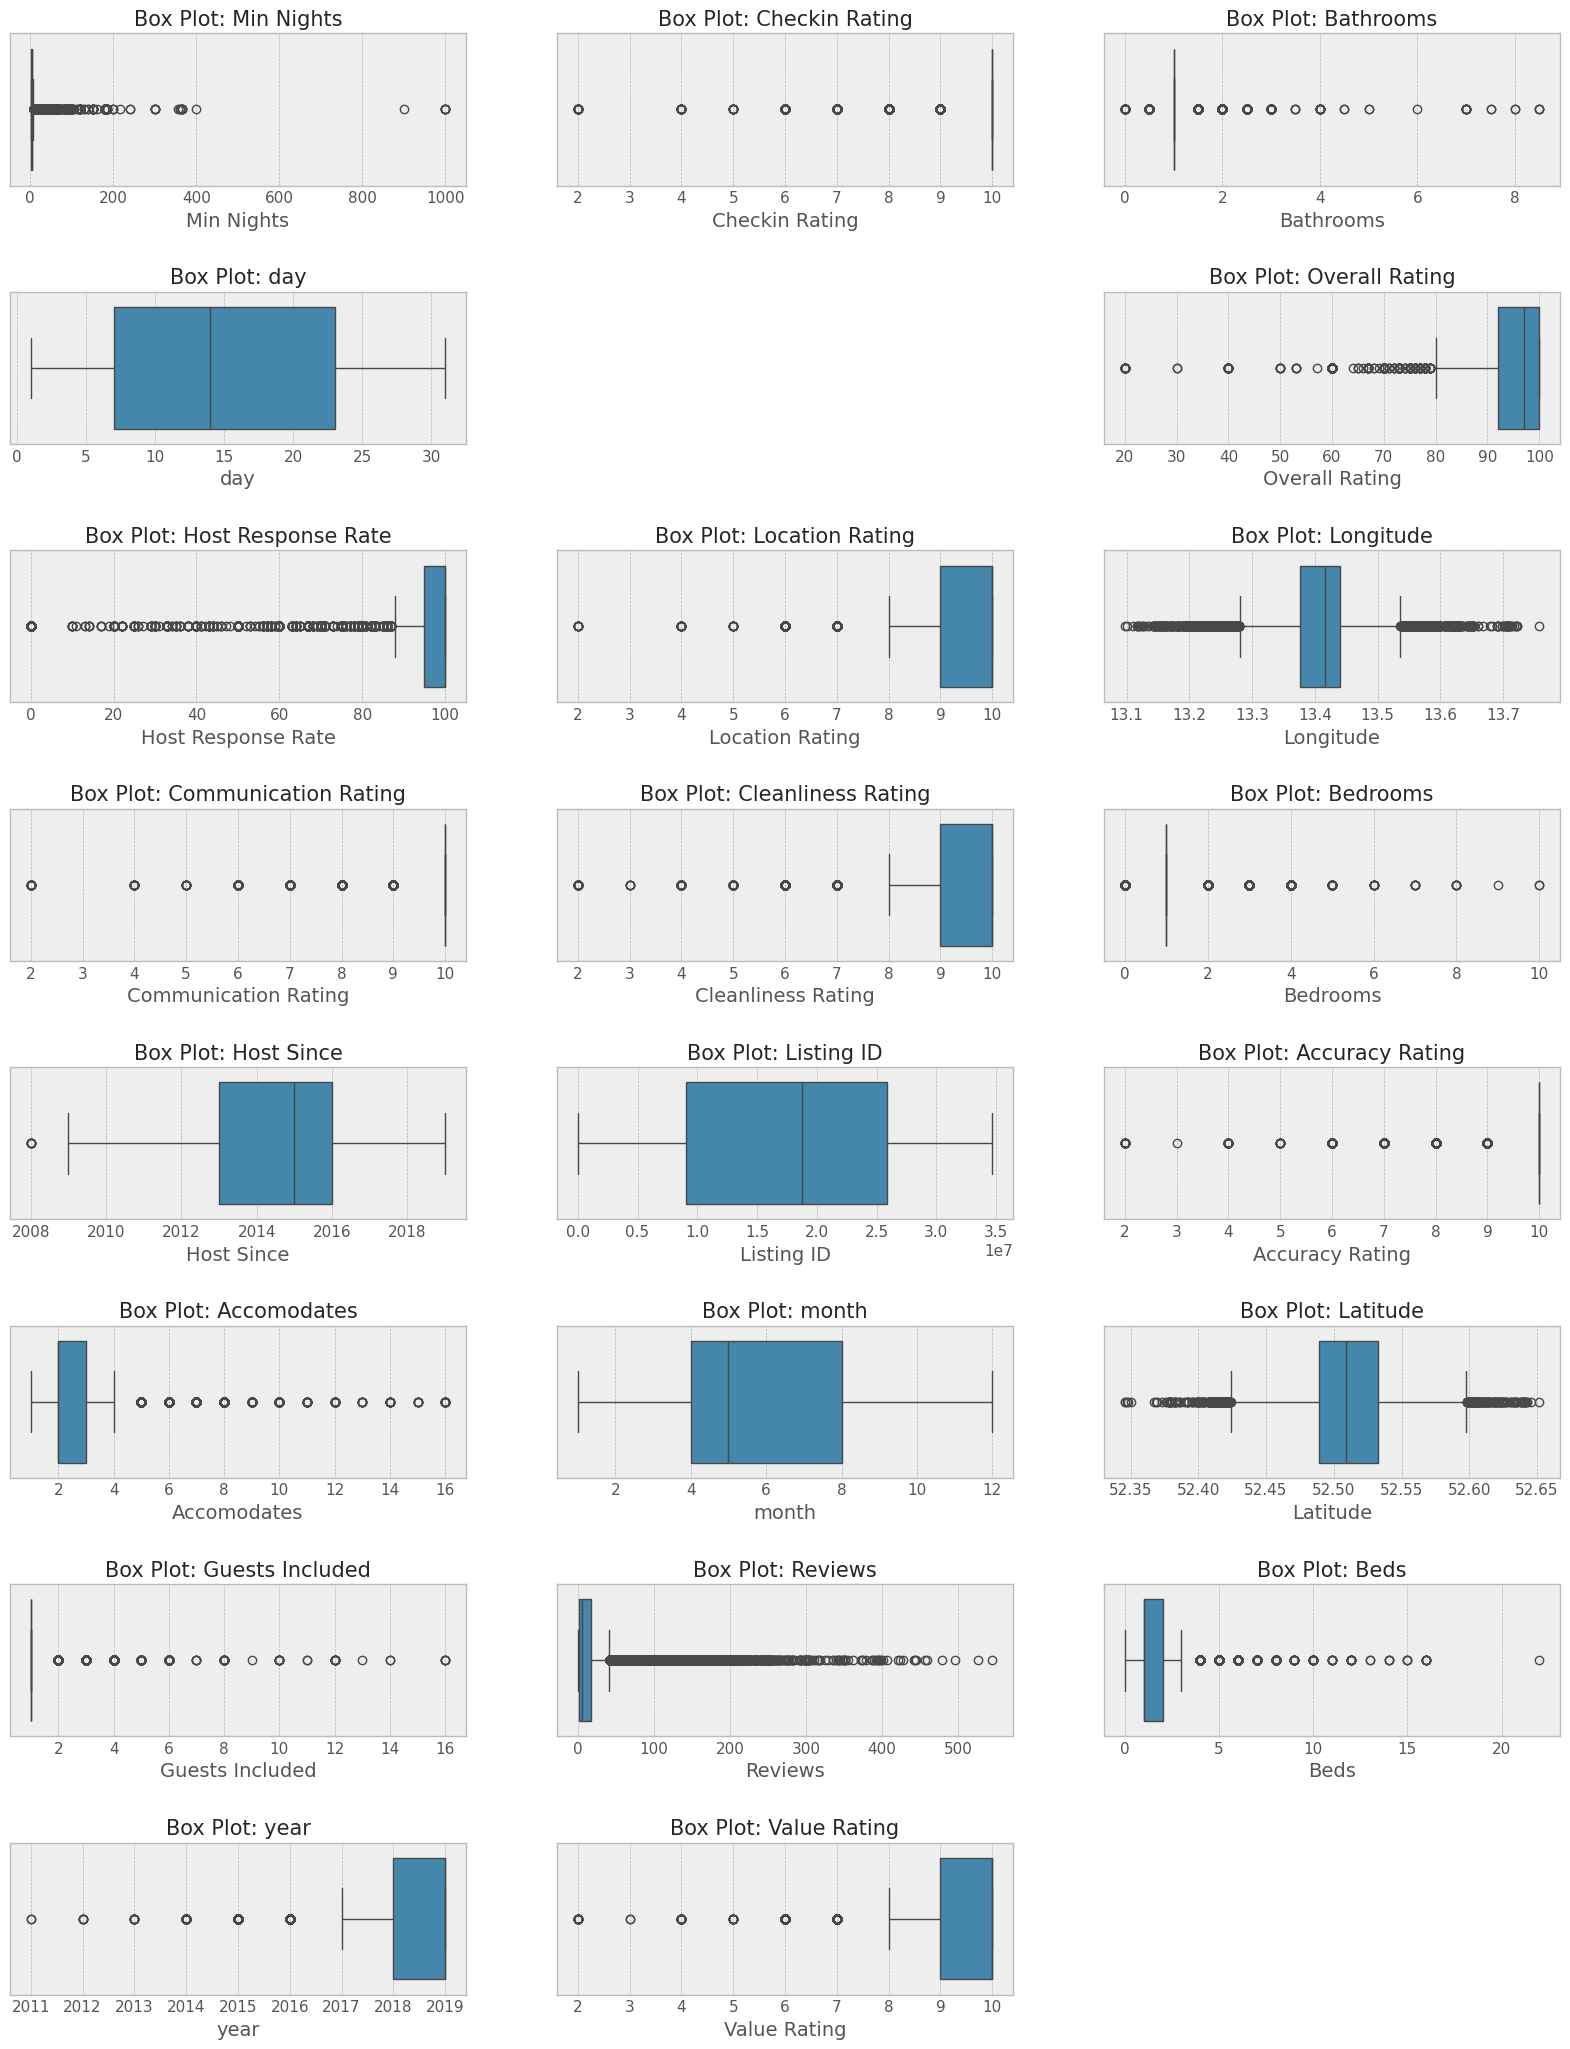

In [42]:
plt.figure(figsize=(20,200))

def outliers_boxplot(df):
    for i, col in enumerate(df.columns):
        if col != 'Price':
            ax = plt.subplot(60, 3, i+1)
            sns.boxplot(data=df, x=col, ax=ax)
            plt.subplots_adjust(hspace = 0.7)
            plt.title('Box Plot: {}'.format(col), fontsize=15)
            plt.xlabel('{}'.format(col), fontsize=14)

outliers_boxplot(df_num_non_dummy)

### outliers_df
The data is skewed and not normaly distributed, we'll use the IQR method to identify outliers to set up a boundary before Q1 and after Q3. Any values that fall outside of this boundary are considered outliers:

In [43]:
def outliers_df(df):
    total_outliers = pd.DataFrame(columns=['Outlier count', 'Percent'])

    for col in df:  # Ensure processing numeric columns only
      if (col != "Price"):
        temp = pd.DataFrame(df[col])
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR
        # Filter rows that are outliers in either direction
        temp_outliers = temp[(temp[col] > upper_limit) | (temp[col] < lower_limit)]
        num_outliers = len(temp_outliers)
        total_outliers.loc[col] = [num_outliers, num_outliers / len(df) * 100]

    return total_outliers[total_outliers['Percent'] > 0]

# Assume con_df is your DataFrame
# Call the function and sort results
outliers_df = outliers_df(df_num_non_dummy).sort_values('Percent', ascending=False)
outliers_df

Outlier count    Percent
Bedrooms                     5810.0  24.685588
Guests Included              5447.0  23.143270
Accuracy Rating              4367.0  18.554555
Checkin Rating               3700.0  15.720598
Communication Rating         3423.0  14.543678
Reviews                      2983.0  12.674201
Bathrooms                    2813.0  11.951903
Min Nights                   2520.0  10.707002
year                         2473.0  10.507308
Host Response Rate           2188.0   9.296397
Accomodates                  2116.0   8.990483
Beds                         1611.0   6.844833
Cleanliness Rating            941.0   3.998131
Longitude                     775.0   3.292828
Overall Rating                465.0   1.975697
Value Rating                  427.0   1.814242
Latitude                      331.0   1.406356
Location Rating               303.0   1.287390
Host Since                      7.0   0.029742

### new_outliers_df
Labeling every outlier with 'Outlier' in order to seperate the outliers from nulls (temporarily, and then to 0/1):

In [44]:
def outliers(df):
    label_out_df = df.copy()
    for col in label_out_df:
      if (col != "Price"):
        if col in outliers_df.index:
            Q1 = label_out_df[col].quantile(0.25)
            Q3 = label_out_df[col].quantile(0.75)
            lower_limit = Q1 - 1.5 * (Q3-Q1)
            upper_limit = Q3 + 1.5 * (Q3-Q1)
            label_out_df[col] = np.where(label_out_df[col] > upper_limit,'Outlier',np.where(label_out_df[col] < lower_limit,'Outlier',label_out_df[col]))
    return label_out_df
new_df_outliers = outliers(df)
new_df_outliers.head(10)

Listing ID Overall Rating Accuracy Rating Cleanliness Rating  \
0        2695          100.0            10.0               10.0   
1        3176           92.0         Outlier                9.0   
2        7071           96.0            10.0               10.0   
3        9991          100.0            10.0               10.0   
4       14325           93.0            10.0               10.0   
5       16401            nan             nan                nan   
6       16644           94.0            10.0               10.0   
7       17904           96.0            10.0               10.0   
8       20858           88.0         Outlier                9.0   
9       21869           95.0         Outlier               10.0   

  Checkin Rating Communication Rating Location Rating Value Rating  Price  \
0           10.0                 10.0             9.0         10.0   17.0   
1        Outlier              Outlier            10.0          9.0   90.0   
2           10.0                 10.0            10.0         10.0   33.0   
3           10.0                 10.0            10.0         10.0  180.0   
4        Outlier                 10.0             9.0          9.0   70.0   
5            nan                  nan             nan          nan  120.0   
6           10.0                 10.0             9.0          9.0   90.0   
7           10.0                 10.0            10.0          9.0   49.0   
8        Outlier              Outlier            10.0          9.0  129.0   
9           10.0              Outlier             9.0          9.0   70.0   

   Reviews Bedrooms     Beds Bathrooms Host Response Rate  Is Superhost  \
0      7.0      1.0      1.0       1.0            Outlier         False   
1  Outlier      1.0      2.0       1.0            Outlier         False   
2  Outlier      1.0      2.0       1.0              100.0          True   
3      6.0  Outlier  Outlier   Outlier              100.0         False   
4     23.0  Outlier      1.0       1.0              100.0         False   
5      0.0      1.0      2.0       1.0                nan         False   
6  Outlier      1.0      3.0       1.0                nan         False   
7  Outlier      nan      1.0       1.0              100.0         False   
8  Outlier  Outlier      2.0       1.0              100.0         False   
9  Outlier      1.0      2.0       1.0                nan         False   

   Latitude Longitude Accomodates Guests Included Min Nights  \
0  52.54851  13.40455           2               1          2   
1    52.535  13.41758           4         Outlier    Outlier   
2  52.54316  13.41509           2               1          2   
3  52.53303  13.41605     Outlier         Outlier          6   
4  52.54785  13.40556           1               1    Outlier   
5  52.51051  13.45785           2               1    Outlier   
6  52.50479   13.4351     Outlier         Outlier    Outlier   
7  52.49548  13.42182           2               1          5   
8  52.53695  13.40762           4         Outlier          3   
9  52.50273  13.43462           4         Outlier    Outlier   

   Instant Bookable Host Since  Is Exact Location     year  month   day  \
0             False    Outlier               True   2019.0    4.0  21.0   
1             False    Outlier               True   2018.0   10.0  29.0   
2             False     2009.0               True   2019.0    5.0   8.0   
3             False     2009.0              False   2018.0    7.0  23.0   
4             False     2009.0               True   2018.0   11.0   1.0   
5             False     2009.0               True      nan    NaN   NaN   
6             False     2009.0               True   2017.0   12.0  14.0   
7             False     2010.0              False   2019.0    4.0  17.0   
8             False     2010.0               True   2019.0    4.0  15.0   
9             False     2009.0               True  Outlier    6.0   5.0   

   Postal Code Cleansed Encoded  Neighbourhood Grouped Clean

In [45]:
new_df_outliers['Host Since']

0        Outlier
1        Outlier
2         2009.0
3         2009.0
4         2009.0
          ...   
23531     2018.0
23532     2019.0
23533     2014.0
23534     2019.0
23535     2018.0
Name: Host Since, Length: 23536, dtype: object

Creating a dataframe with outliers as 1 and non-outliers as 0:

In [46]:
df_outliers = new_df_outliers.isin(['Outlier'])
df_outliers = df_outliers.astype('int')
df_outliers

Listing ID  Overall Rating  Accuracy Rating  Cleanliness Rating  \
0               0               0                0                   0   
1               0               0                1                   0   
2               0               0                0                   0   
3               0               0                0                   0   
4               0               0                0                   0   
...           ...             ...              ...                 ...   
23531           0               0                0                   0   
23532           0               0                0                   0   
23533           0               0                0                   0   
23534           0               0                0                   0   
23535           0               0                0                   0   

       Checkin Rating  Communication Rating  Location Rating  Value Rating  \
0                   0                     0                0             0   
1                   1                     1                0             0   
2                   0                     0                0             0   
3                   0                     0                0             0   
4                   1                     0                0             0   
...               ...                   ...              ...           ...   
23531               0                     0                0             0   
23532               0                     0                0             0   
23533               0                     0                0             0   
23534               0                     0                0             0   
23535               0                     0                0             0   

       Price  Reviews  Bedrooms  Beds  Bathrooms  Host Response Rate  \
0          0        0         0     0          0                   1   
1          0        1         0     0          0                   1   
2          0        1         0     0          0                   0   
3          0        0         1     1          1                   0   
4          0        0         1     0          0                   0   
...      ...      ...       ...   ...        ...                 ...   
23531      0        0         0     0          0                   1   
23532      0        0         1     0          0                   0   
23533      0        0         0     0          1                   0   
23534      0        0         1     1          0                   0   
23535      0        0         1     0          0                   0   

       Is Superhost  Latitude  Longitude  Accomodates  Guests Included  \
0                 0         0          0            0                0   
1                 0         0          0            0                1   
2                 0         0          0            0                0   
3                 0         0          0            1                1   
4                 0         0          0            0                0   
...             ...       ...        ...          ...              ...   
23531             0         1          1            0                0   
23532             0         1          0            0                1   
23533             0         0          0            0                0   
23534             0         0          1            1                0   
23535             0         0          0            0                0   

       Min Nights  Instant Bookable  Host Since  Is Exact Location  year  \
0               0                 0           1                  0     0   
1               1                 0           1                  0     0   
2               0                 0           0                  0     0   
3               0                 0           0                  0     0   
4               1                 0           0

Now that we have a dataframe saving all the outliers we'll convert all the outliers to nulls, just so I can see differences in distribution with and without outliers and then decide which of the outliers to remove or not:

In [47]:
def capping(df):
    temp = df.copy()
    for col in temp:
        if col in outliers_df.index and col != "Price":
            Q1 = temp[col].quantile(0.25)
            Q3 = temp[col].quantile(0.75)
            lower_limit = Q1 - 1.5 * (Q3-Q1)
            upper_limit = Q3 + 1.5 * (Q3-Q1)
            temp[col] = np.where(temp[col] > upper_limit,np.nan,np.where(temp[col] < lower_limit,np.nan,temp[col]))
    return temp
temp = capping(df)
temp

Listing ID  Overall Rating  Accuracy Rating  Cleanliness Rating  \
0            2695           100.0             10.0                10.0   
1            3176            92.0              NaN                 9.0   
2            7071            96.0             10.0                10.0   
3            9991           100.0             10.0                10.0   
4           14325            93.0             10.0                10.0   
...           ...             ...              ...                 ...   
23531    34678365             NaN              NaN                 NaN   
23532    34681094             NaN              NaN                 NaN   
23533    34681403             NaN              NaN                 NaN   
23534    34681413             NaN              NaN                 NaN   
23535    34682315             NaN              NaN                 NaN   

       Checkin Rating  Communication Rating  Location Rating  Value Rating  \
0                10.0                  10.0              9.0          10.0   
1                 NaN                   NaN             10.0           9.0   
2                10.0                  10.0             10.0          10.0   
3                10.0                  10.0             10.0          10.0   
4                 NaN                  10.0              9.0           9.0   
...               ...                   ...              ...           ...   
23531             NaN                   NaN              NaN           NaN   
23532             NaN                   NaN              NaN           NaN   
23533             NaN                   NaN              NaN           NaN   
23534             NaN                   NaN              NaN           NaN   
23535             NaN                   NaN              NaN           NaN   

       Price  Reviews  Bedrooms  Beds  Bathrooms  Host Response Rate  \
0       17.0      7.0       1.0   1.0        1.0                 NaN   
1       90.0      NaN       1.0   2.0        1.0                 NaN   
2       33.0      NaN       1.0   2.0        1.0               100.0   
3      180.0      6.0       NaN   NaN        NaN               100.0   
4       70.0     23.0       NaN   1.0        1.0               100.0   
...      ...      ...       ...   ...        ...                 ...   
23531   48.0      0.0       1.0   2.0        1.0                 NaN   
23532   30.0      0.0       NaN   2.0        1.0                 NaN   
23533   17.0      0.0       1.0   1.0        NaN                 NaN   
23534   52.0      0.0       NaN   NaN        1.0                 NaN   
23535   65.0      0.0       NaN   2.0        1.0                 NaN   

       Is Superhost  Latitude  Longitude  Accomodates  Guests Included  \
0             False  52.54851   13.40455          2.0              1.0   
1             False  52.53500   13.41758          4.0              NaN   
2              True  52.54316   13.41509          2.0              1.0   
3             False  52.53303   13.41605          NaN              NaN   
4             False  52.54785   13.40556          1.0              1.0   
...             ...       ...        ...          ...              ...   
23531         False       NaN        NaN          3.0              1.0   
23532         False       NaN   13.49340          2.0              NaN   
23533         False  52.45402   13.43864          1.0              1.0   
23534         False  52.47342        NaN          NaN              1.0   
23535         False  52.54929   13.46067          3.0              1.0   

       Min Nights  Instant Bookable  Host Since  Is Exact Location    year  \
0             2.0             False         NaN               True  2019.0   
1             NaN             False         NaN               True  2018.0   
2             2.0             False      2009.0               True  2019.0   
3             6.0             False      2009.0              False  2018.0   
4             NaN             False  

Min Nights


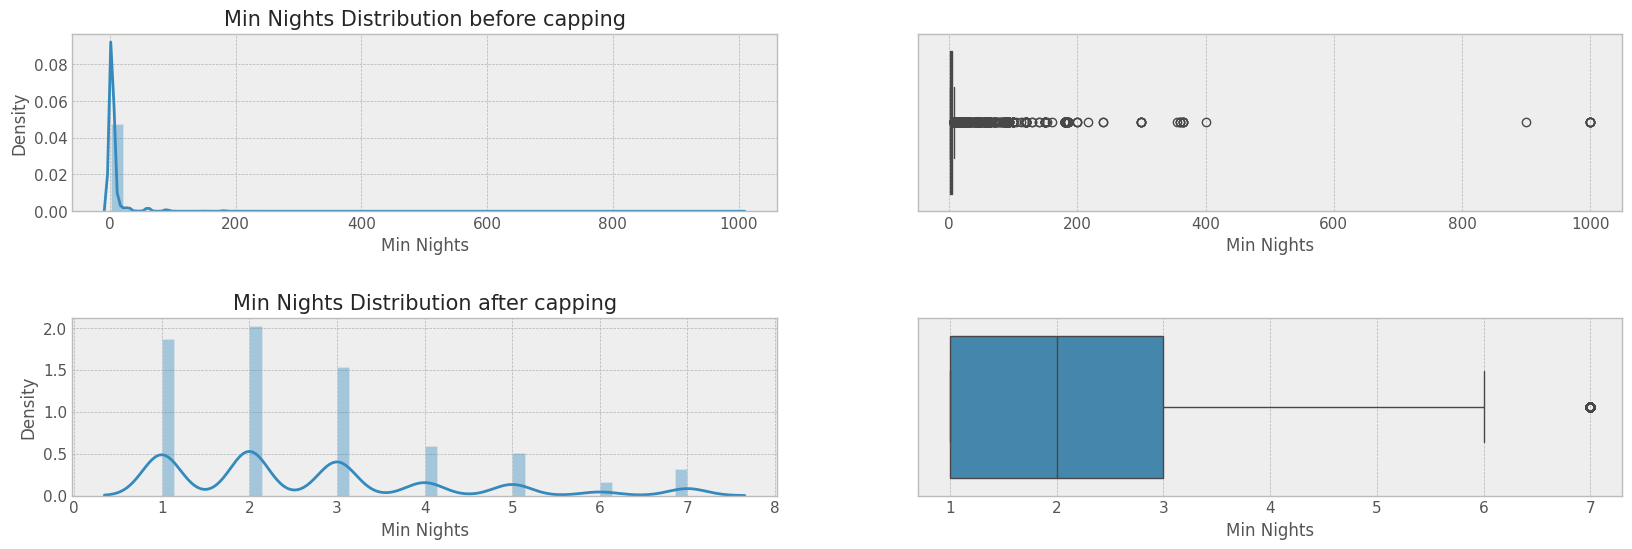

Checkin Rating


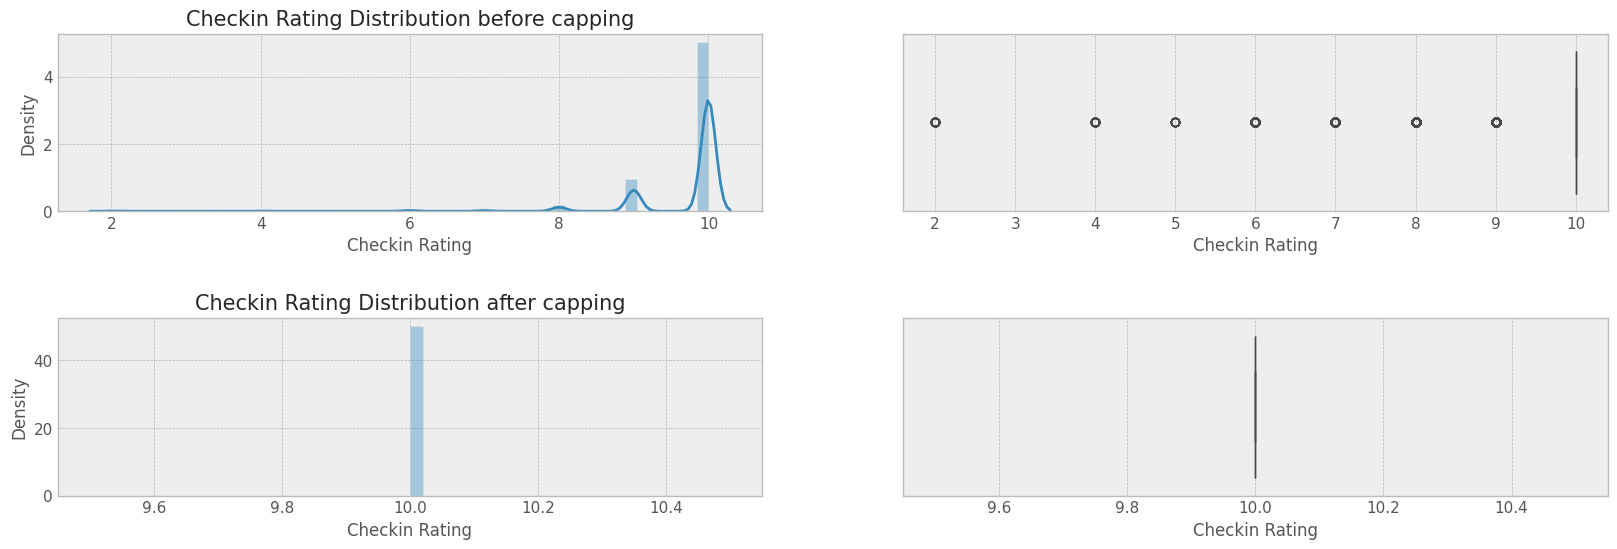

Bathrooms


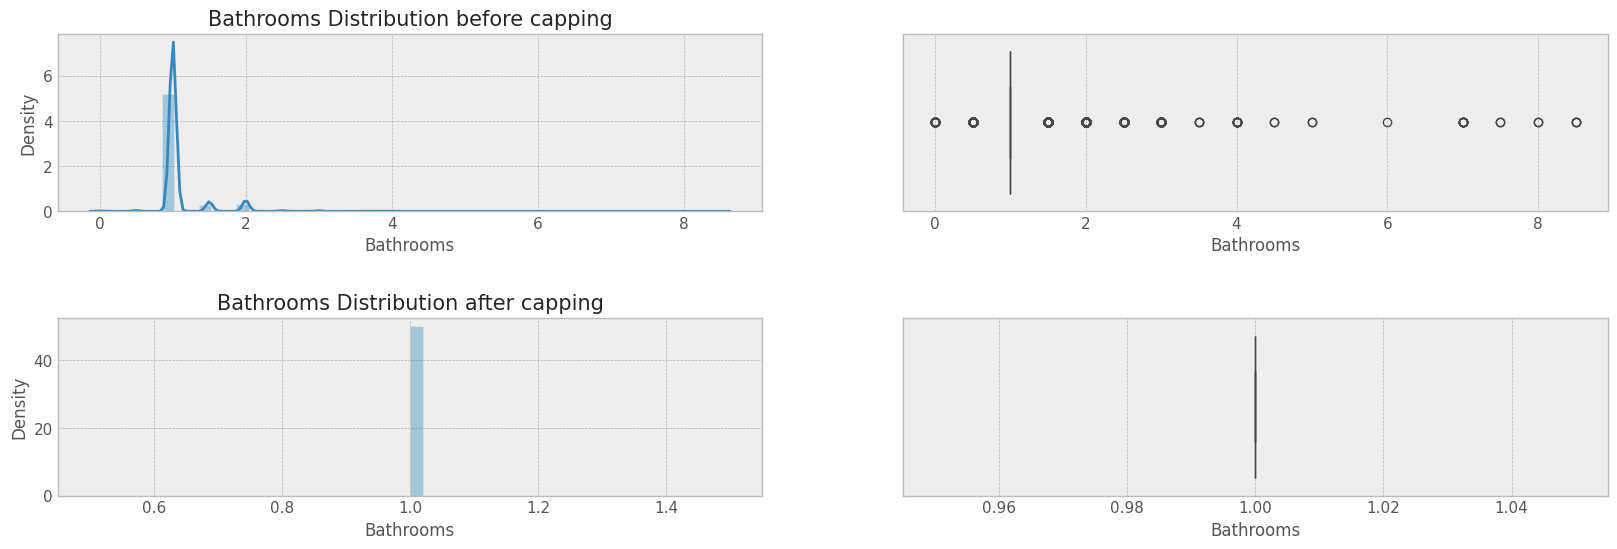

Overall Rating


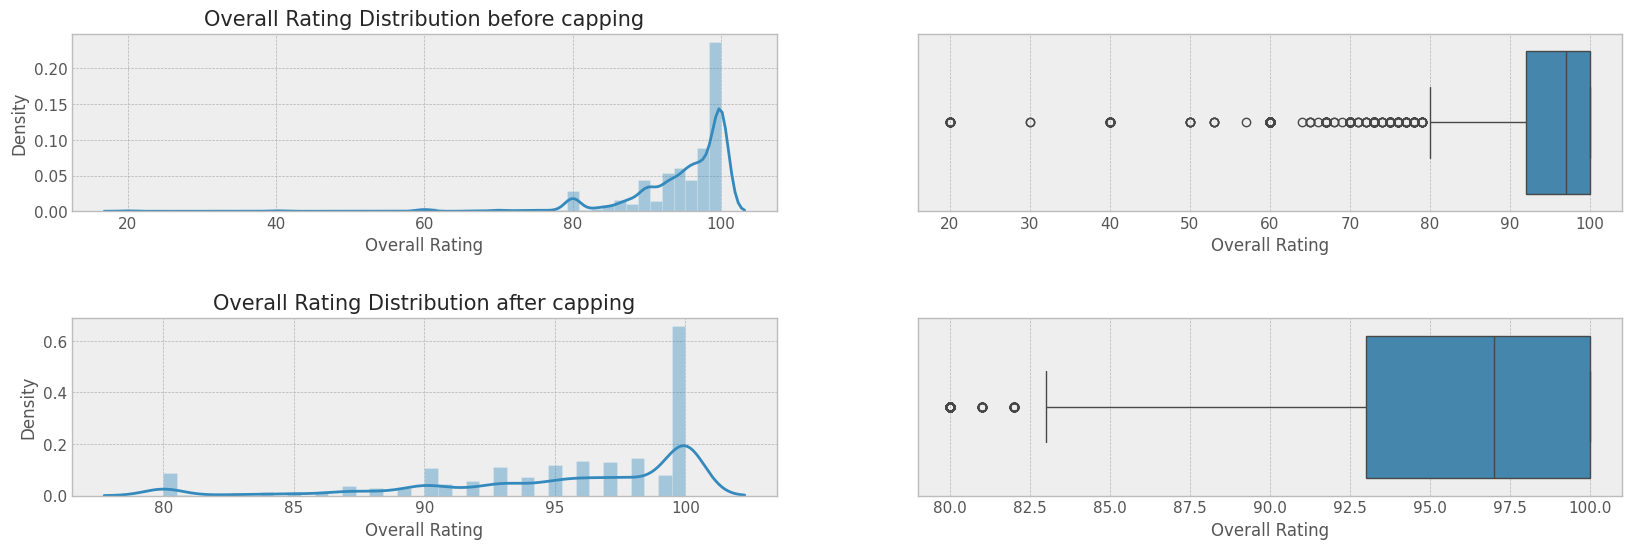

Host Response Rate


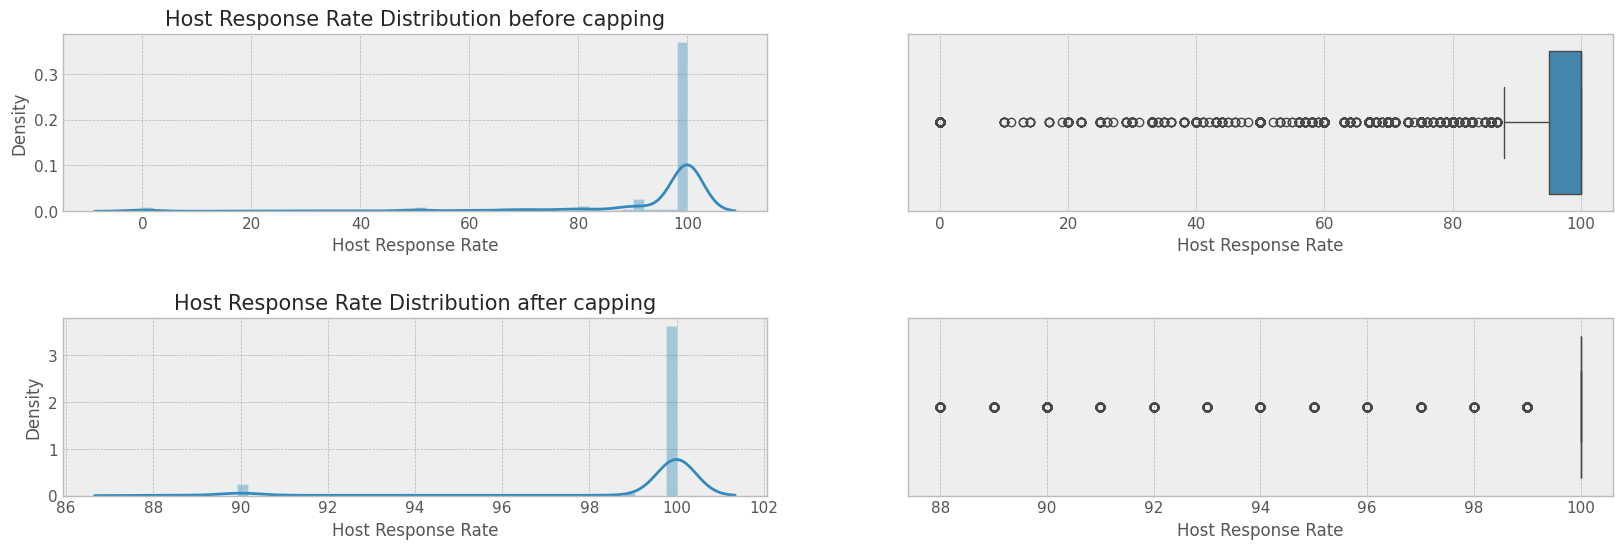

Location Rating


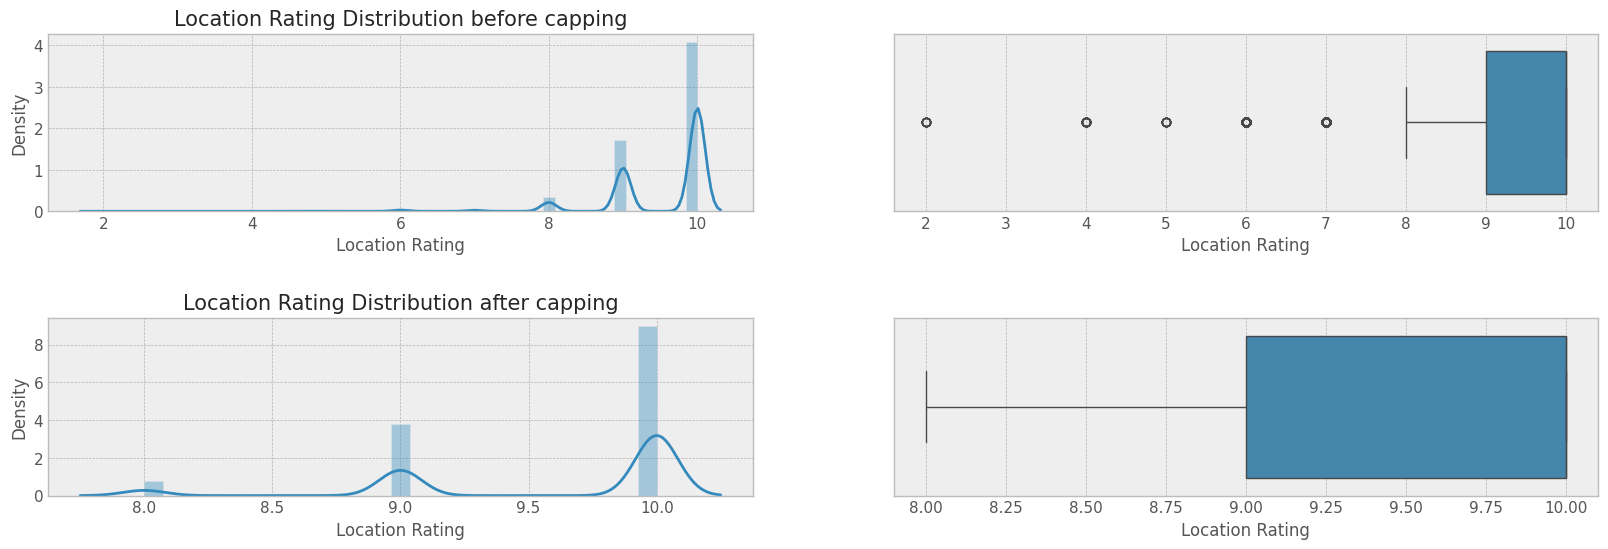

Longitude


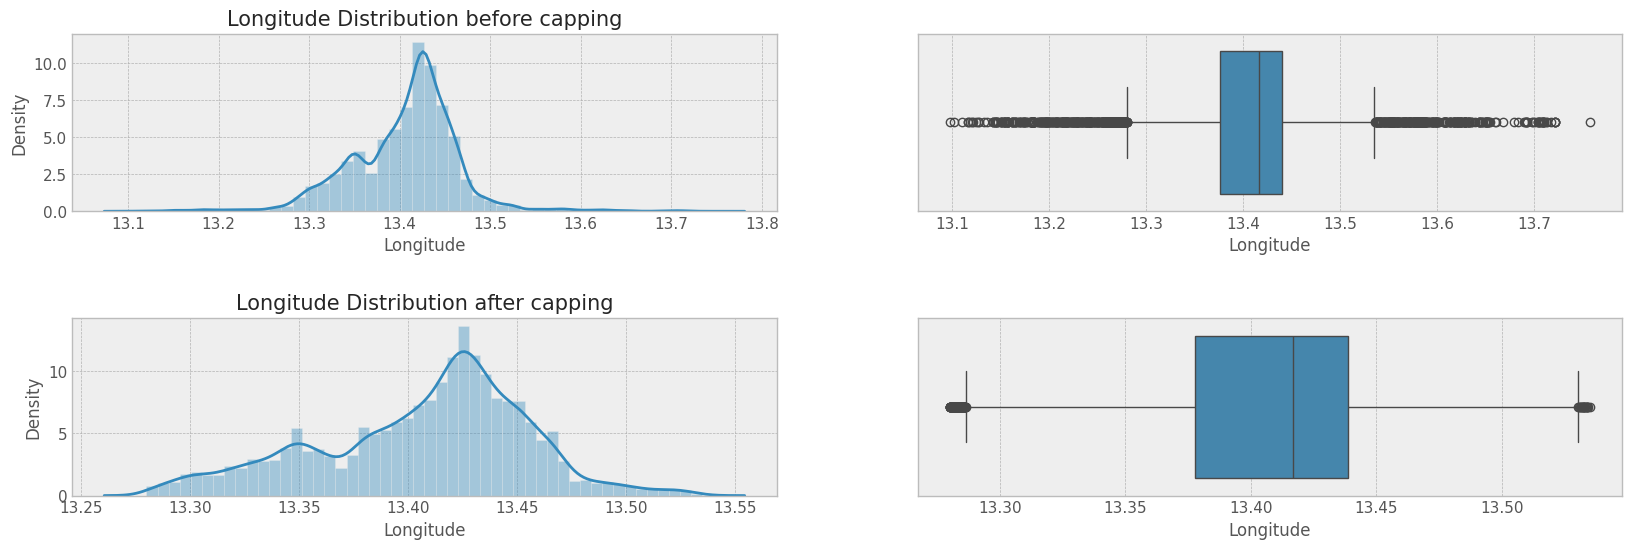

Communication Rating


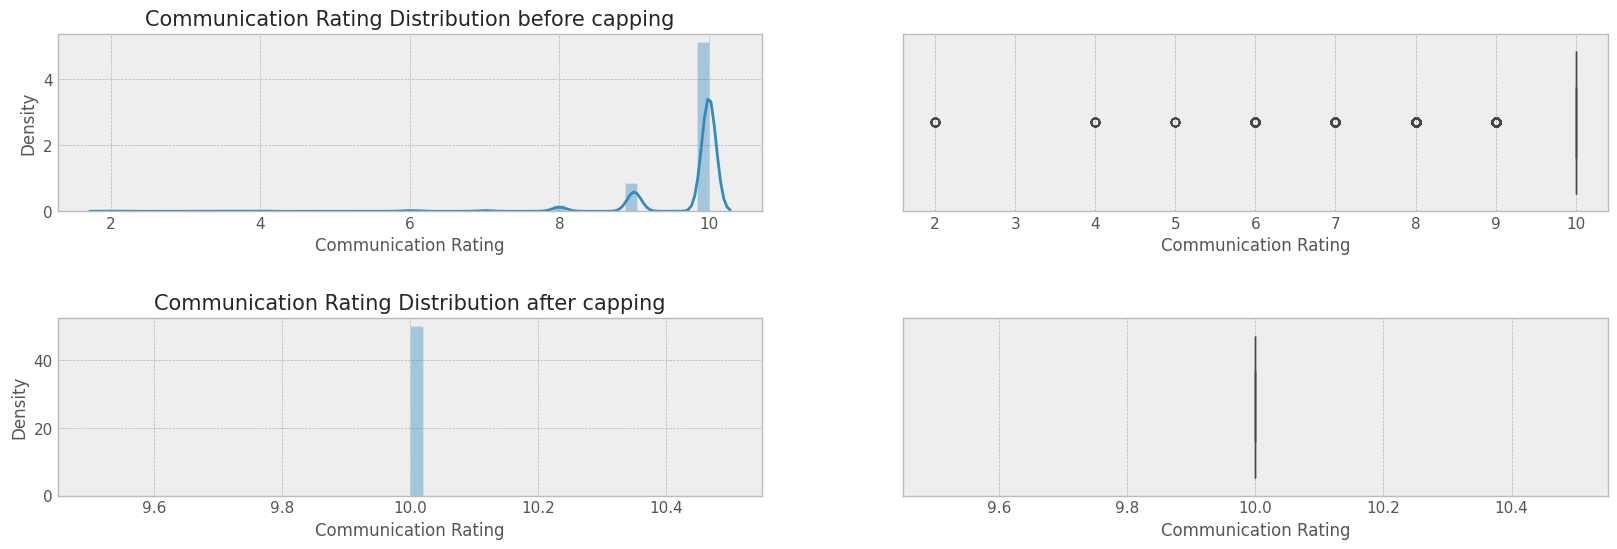

Cleanliness Rating


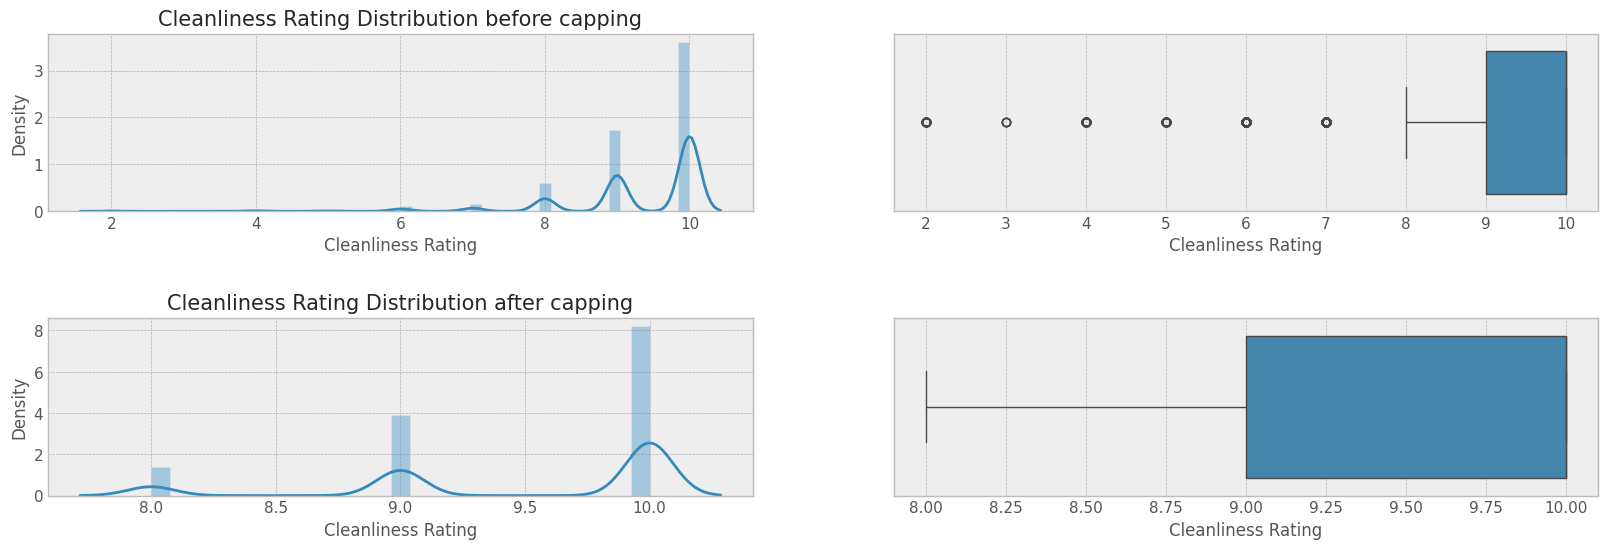

Bedrooms


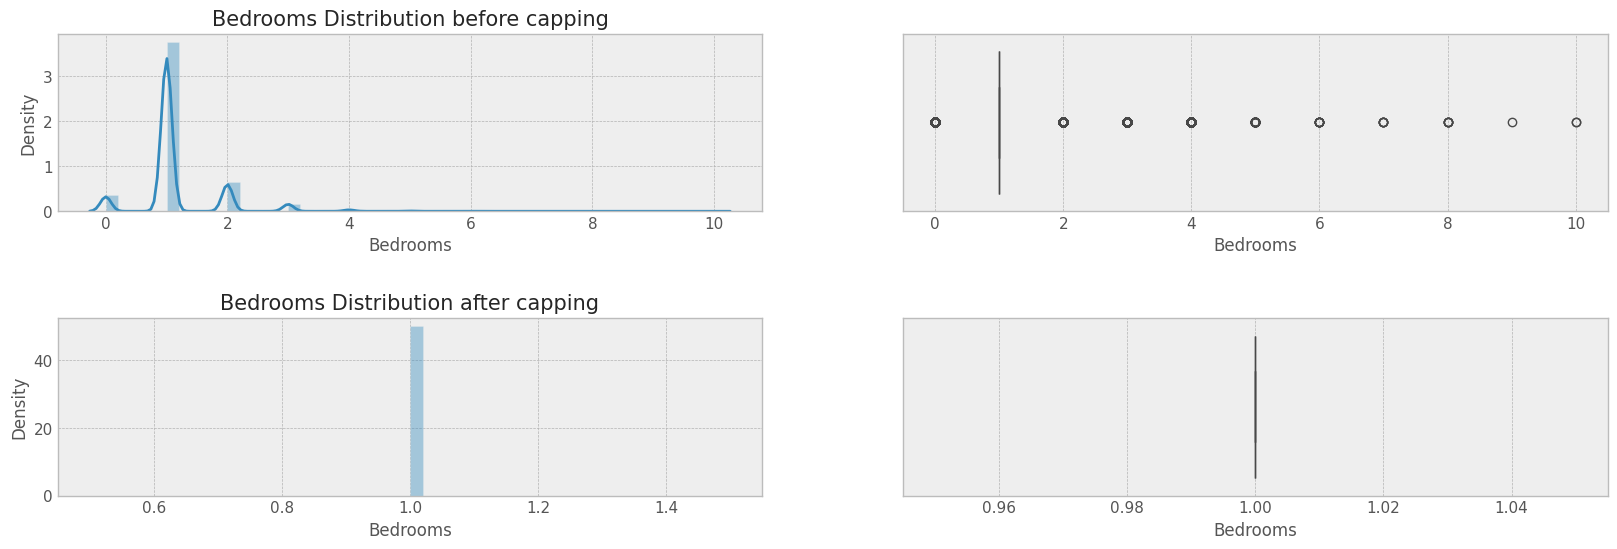

Host Since


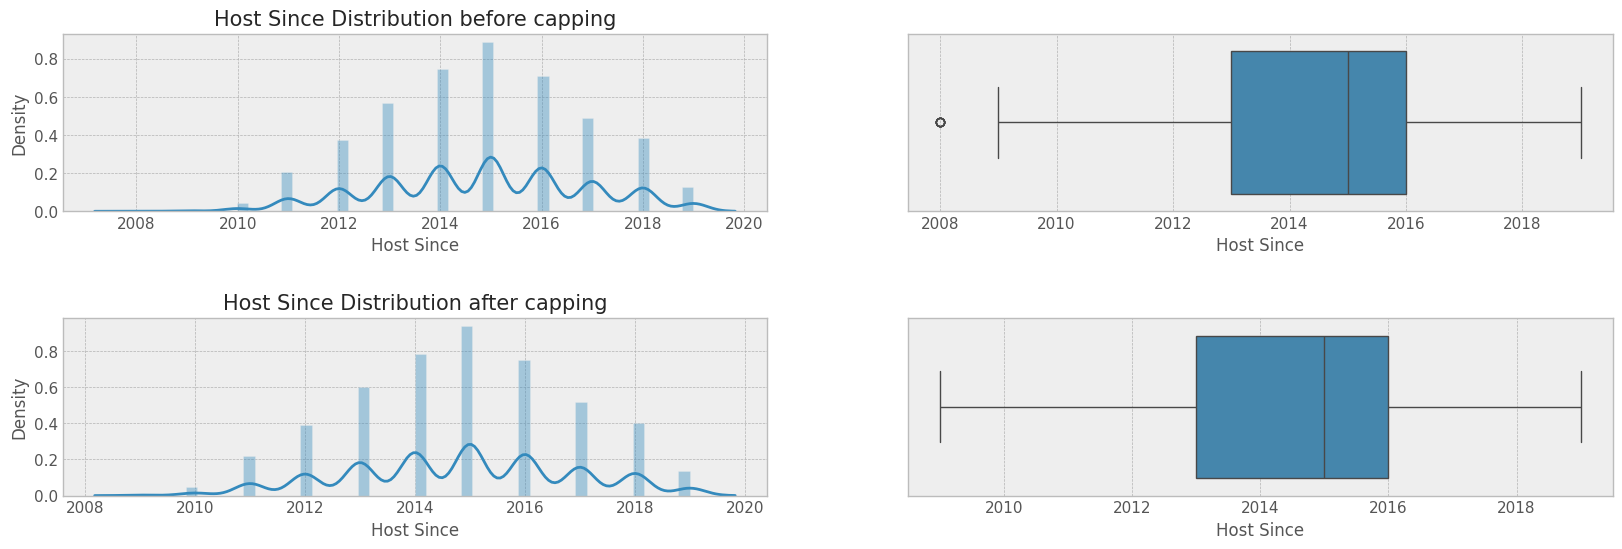

Accuracy Rating


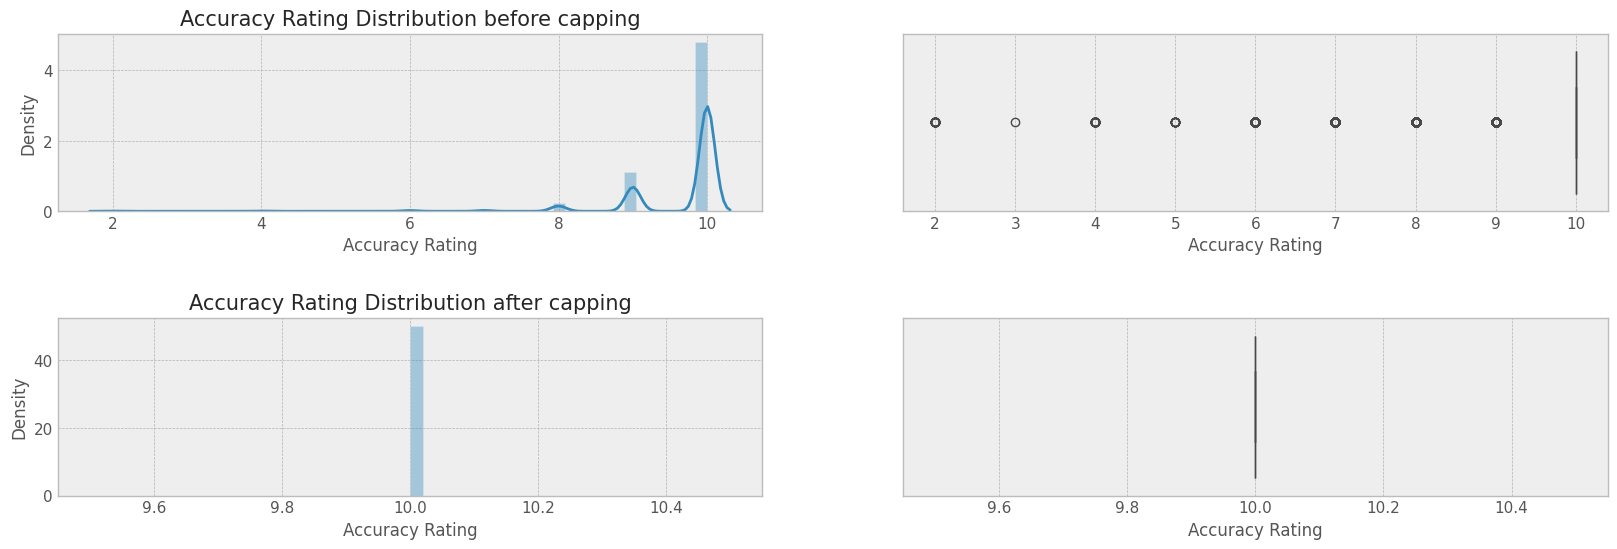

Accomodates


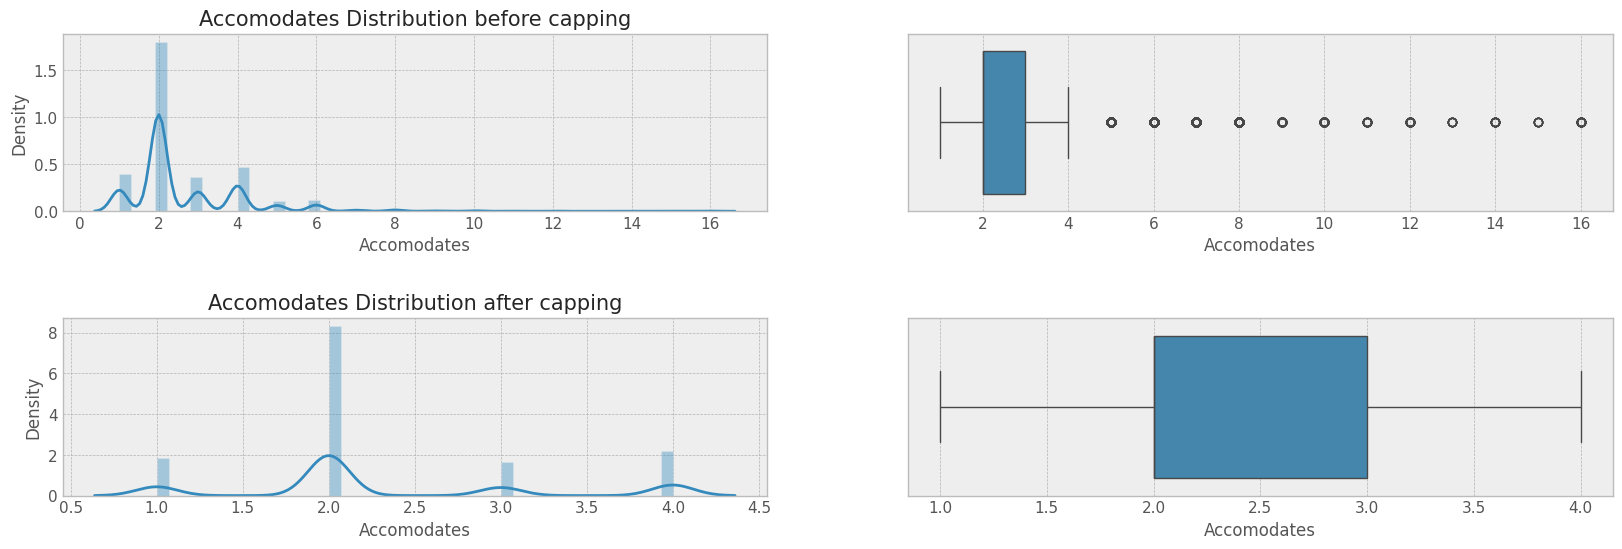

Latitude


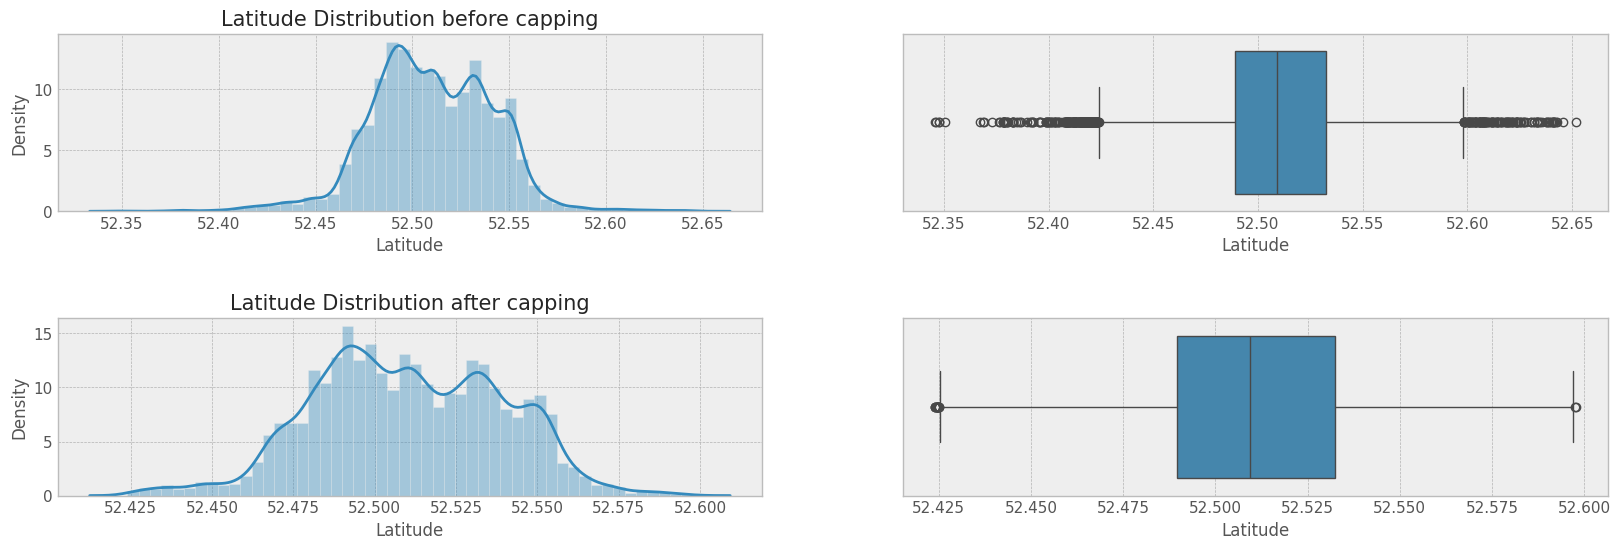

Guests Included


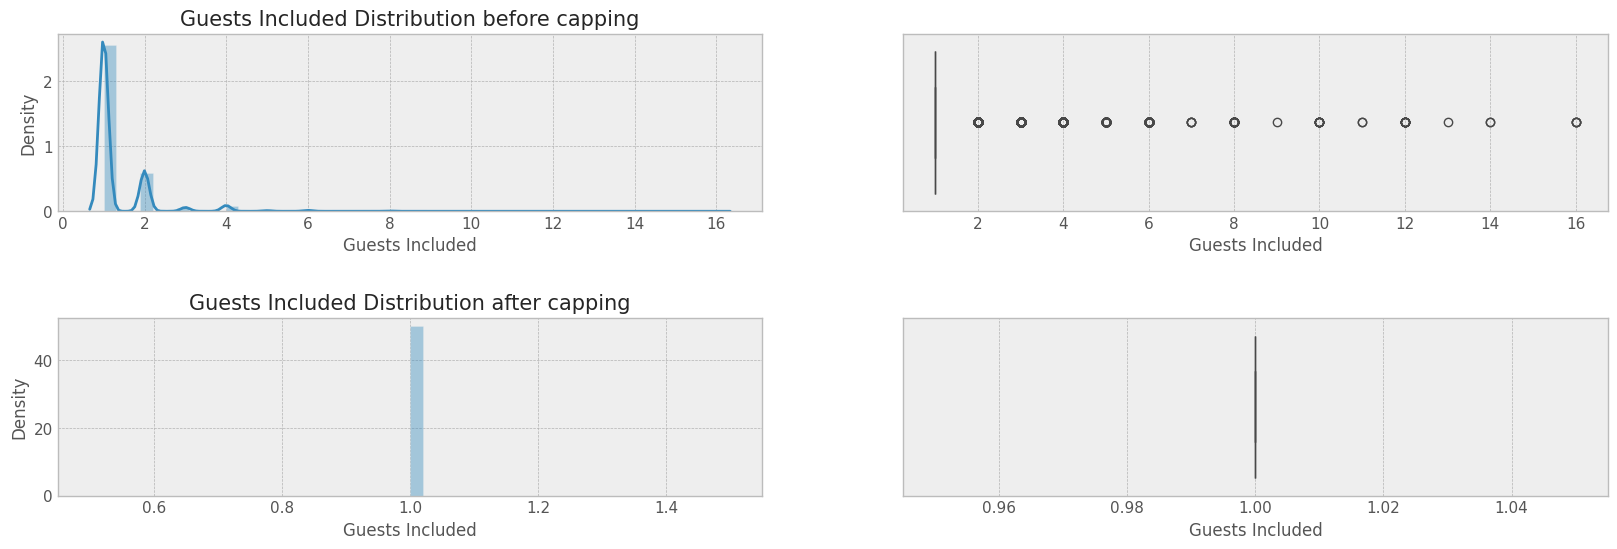

Reviews


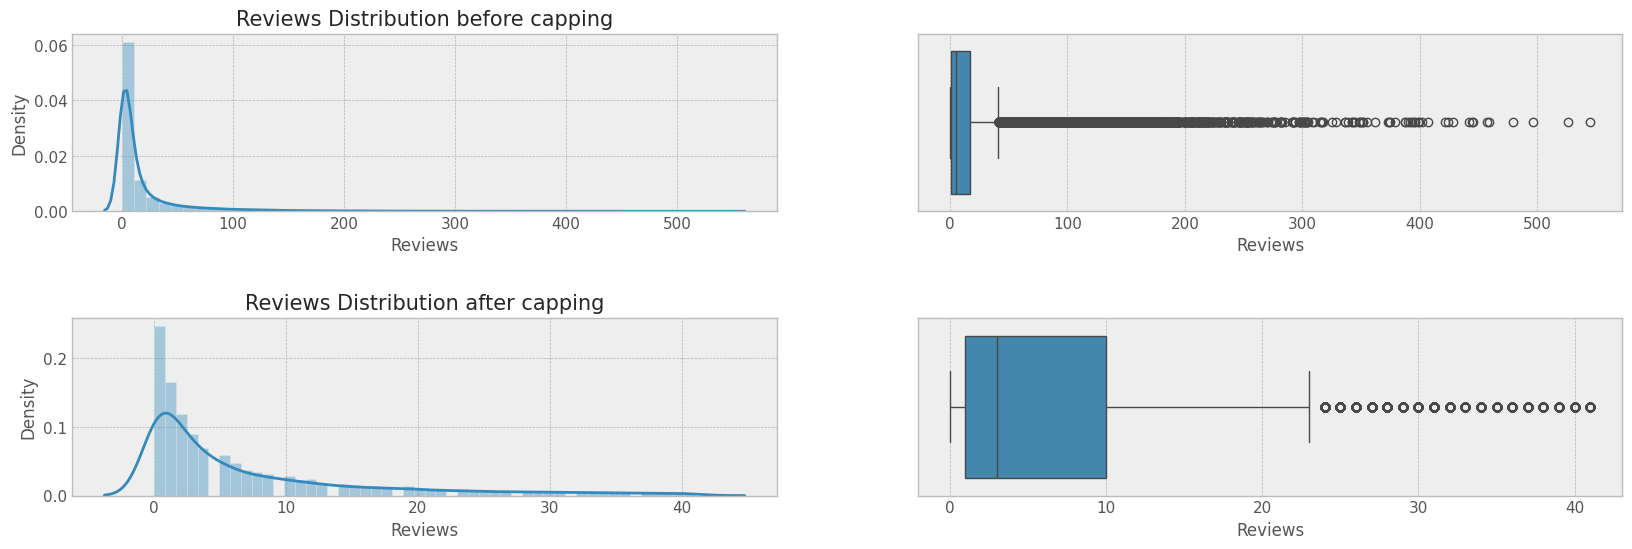

Beds


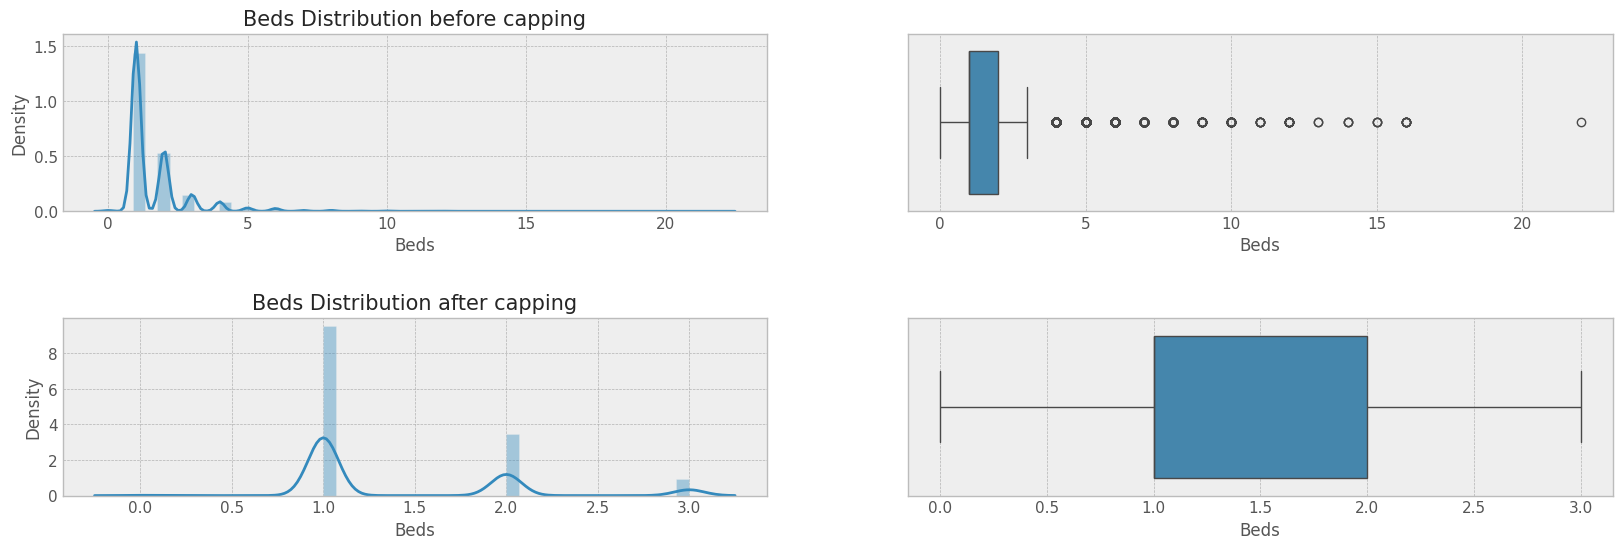

year


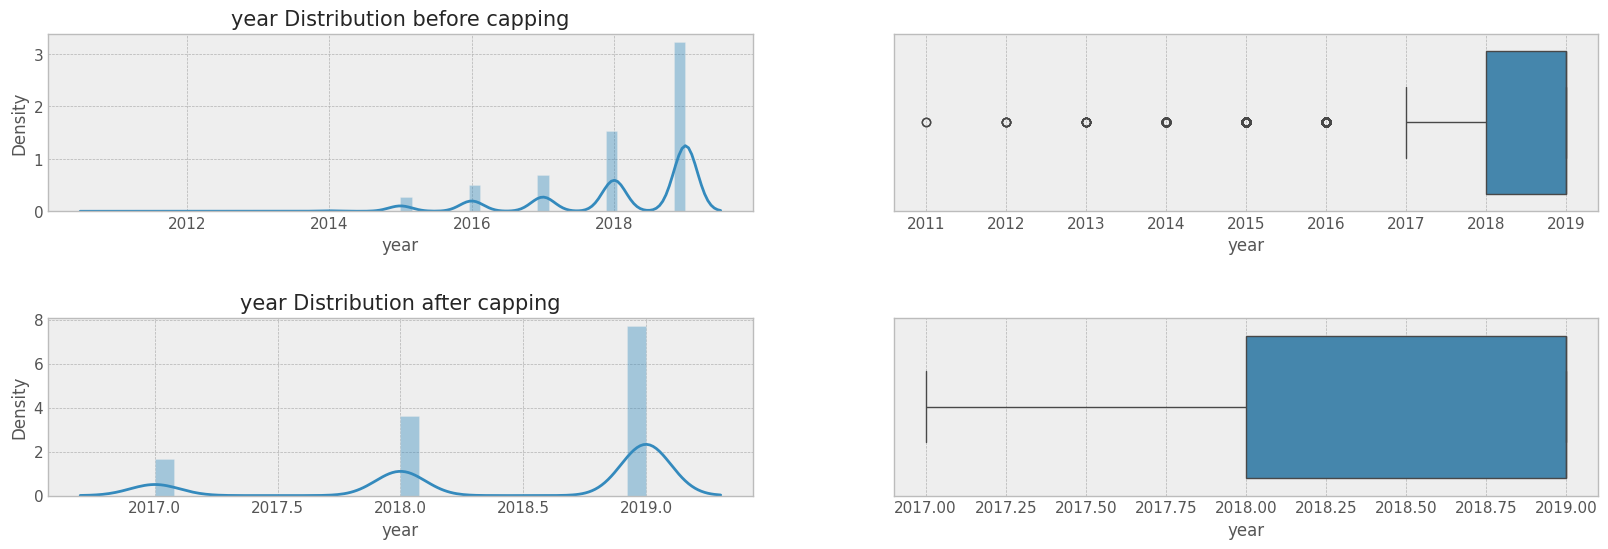

Value Rating


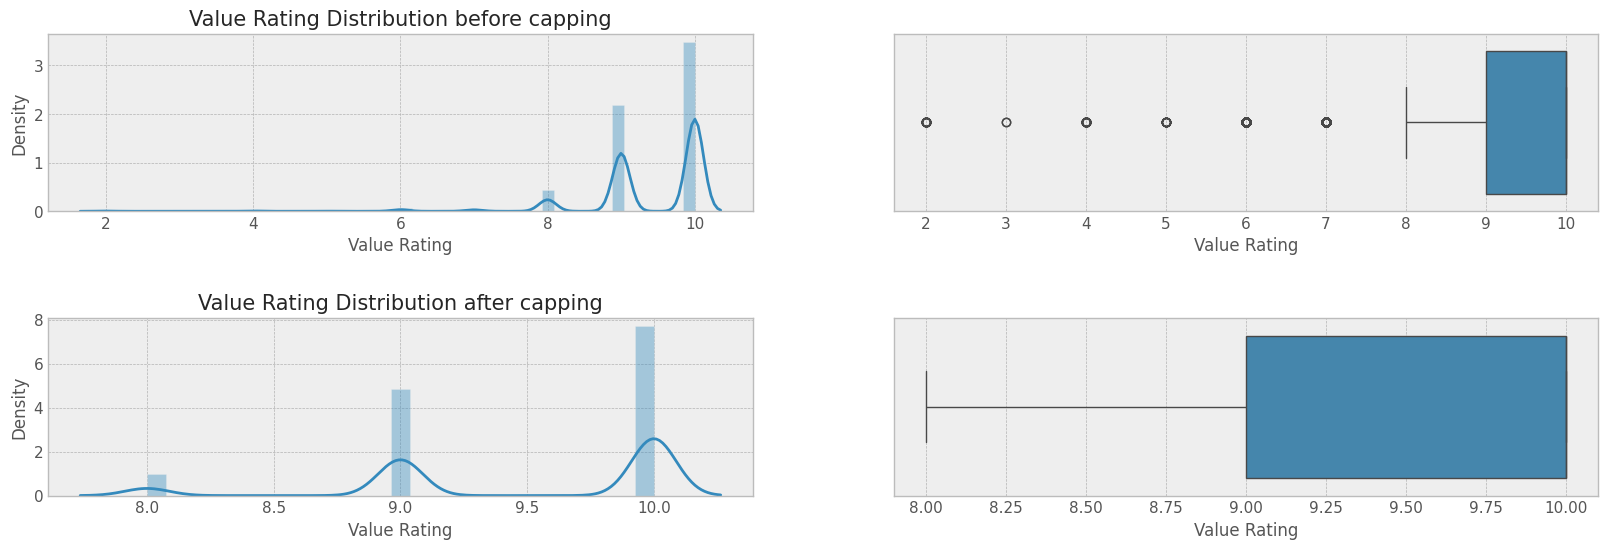

In [48]:
def dist_outliers(original_df, new, cols):
    for col in df_num_non_dummy:
        if col in cols:
          if col != "Price":
            print(col)
            plt.figure(figsize=(20,6))
            plt.subplot(2,2,1)
            sns.distplot(original_df[col])
            plt.title('{} Distribution before capping'.format(col), fontsize=15)
            plt.subplot(2,2,2)
            sns.boxplot(x=original_df[col])
            plt.subplots_adjust(hspace = 0.6)
            plt.subplot(2,2,3)
            sns.distplot(new[col])
            plt.title('{} Distribution after capping'.format(col), fontsize=15)
            plt.subplot(2,2,4)
            sns.boxplot(x=new[col])
            plt.show()
dist_outliers(df, temp, outliers_df.index)

We clearly need to filter some features that either the feature distribution has changed significantly, or cases where removing outliers results with only one value.

Checking if distribution (Kolmogorov–Smirnov) and/or correlation has changed significantly:

In [49]:
### differences between two correlation in Python: https://github.com/psinger/CorrelationStats
### We will only take from the code the Fisher method for two-tailed test
def cocor(x1,y1, x2,y2):
    xy1 = x1.corr(y1, method='spearman')
    xy2 = x2.corr(y2, method='spearman')
    n1 = len(x1)
    n2 = len(x2)
    xy_z = 0.5 * np.log((1 + xy1)/(1 - xy1))
    ab_z = 0.5 * np.log((1 + xy2)/(1 - xy2))
    if n2 is None:
        n2 = n1
    se_diff_r = np.sqrt(1/(n1 - 3) + 1/(n2 - 3))
    diff = xy_z - ab_z
    z = abs(diff / se_diff_r)
    p = (1 - norm.cdf(z)) * 2
    return z, p

In [50]:
# c=df_num_non_dummy
# names=c.columns
# #Creating df that reflects the correlation change
# out_df= pd.DataFrame(columns=['feature','outliers_cnt','distribution_changed','correlation_changed'])

# #A copy of numeric df
# no_outliers=df_num_non_dummy.copy()
# np.seterr(divide='ignore', invalid='ignore')
# for i in names:
# #   print(i)
# #     df with outliers
#     out=df[i]
# #     df with out outliers
#     non=df[i].loc[df_outliers[i]==0]
# #     lable with outliers
#     price_out=df['Price']
# #     lable with out outliers
#     price_non=df['Price'].loc[df_outliers[i]==0]
# #     cocor pvalue
#     p, pvalue = cocor(out,price_out, non,price_non)
#     cor_change=np.where(pvalue<0.05,'+','-')
# #     outliers count
#     mv=df_outliers.sum()
# #    ks pvalue
#     pval=ks_2samp(out, non)[1]
#     dist_change=np.where(pval<0.05,'+','-')
#     out_df=out_df.append({'feature':i,'outliers_cnt':mv,'distribution_changed':dist_change,'correlation_changed': cor_change},ignore_index=True)
# out_df.head(10)
c=df_num_non_dummy
names=c.columns
#Creating df that reflects the correlation change
out_df= pd.DataFrame(columns=['feature','outliers_cnt','distribution_changed','correlation_changed'])

#A copy of numeric df
no_outliers=df_num_non_dummy.copy()
np.seterr(divide='ignore', invalid='ignore')
# Create a list to store the data for the new DataFrame
rows_list = []

for i in names:
    #     df with outliers
    out=df[i]
    #     df with out outliers
    non=df[i].loc[df_outliers[i]==0]
    #     lable with outliers
    price_out=df['Price']
    #     lable with out outliers
    price_non=df['Price'].loc[df_outliers[i]==0]
    #     cocor pvalue
    p, pvalue = cocor(out,price_out, non,price_non)
    cor_change=np.where(pvalue<0.05,'+','-')
    #     outliers count
    mv=df_outliers.sum()
    #    ks pvalue
    pval=ks_2samp(out, non)[1]
    dist_change=np.where(pval<0.05,'+','-')

    # Instead of using append, add a dictionary to the list
    rows_list.append({'feature': i, 'outliers_cnt': mv, 'distribution_changed': dist_change, 'correlation_changed': cor_change})

# After the loop, create the DataFrame from the list of dictionaries
out_df = pd.DataFrame(rows_list)
out_df.head(10)



feature                                       outliers_cnt  \
0            Min Nights  Listing ID                                   0...   
1        Checkin Rating  Listing ID                                   0...   
2             Bathrooms  Listing ID                                   0...   
3                   day  Listing ID                                   0...   
4                 Price  Listing ID                                   0...   
5        Overall Rating  Listing ID                                   0...   
6    Host Response Rate  Listing ID                                   0...   
7       Location Rating  Listing ID                                   0...   
8             Longitude  Listing ID                                   0...   
9  Communication Rating  Listing ID                                   0...   

  distribution_changed correlation_changed  
0                    +                   +  
1                    -                   -  
2                    -                   -  
3                    -                   -  
4                    -                   -  
5                    -                   -  
6                    -                   +  
7                    -                   -  
8                    +                   -  
9                    -                   -

In [51]:
#All 'Yes' Vars in the 'Drop'colums shall be deleted, since the infect correlation and distribution.
#We don't want to delete vars that will change the distribution
out_df['drop']='yes'
out_df.loc[(out_df.distribution_changed=='+')& (out_df.correlation_changed=='+'),'drop'] = 'no'
out_df

feature                                       outliers_cnt  \
0             Min Nights  Listing ID                                   0...   
1         Checkin Rating  Listing ID                                   0...   
2              Bathrooms  Listing ID                                   0...   
3                    day  Listing ID                                   0...   
4                  Price  Listing ID                                   0...   
5         Overall Rating  Listing ID                                   0...   
6     Host Response Rate  Listing ID                                   0...   
7        Location Rating  Listing ID                                   0...   
8              Longitude  Listing ID                                   0...   
9   Communication Rating  Listing ID                                   0...   
10    Cleanliness Rating  Listing ID                                   0...   
11              Bedrooms  Listing ID                                   0...   
12            Host Since  Listing ID                                   0...   
13            Listing ID  Listing ID                                   0...   
14       Accuracy Rating  Listing ID                                   0...   
15           Accomodates  Listing ID                                   0...   
16                 month  Listing ID                                   0...   
17              Latitude  Listing ID                                   0...   
18       Guests Included  Listing ID                                   0...   
19               Reviews  Listing ID                                   0...   
20                  Beds  Listing ID                                   0...   
21                  year  Listing ID                                   0...   
22          Value Rating  Listing ID                                   0...   

   distribution_changed correlation_changed drop  
0                     +                   +   no  
1                     -                   -  yes  
2                     -                   -  yes  
3                     -                   -  yes  
4                     -                   -  yes  
5                     -                   -  yes  
6                     -                   +  yes  
7                     -                   -  yes  
8                     +                   -  yes  
9                     -                   -  yes  
10                    -                   +  yes  
11                    -                   -  yes  
12                    -                   -  yes  
13                    -                   -  yes  
14                    -                   -  yes  
15                    +                   +   no  
16                    -                   -  yes  
17                    -                   -  yes  
18                    +                   -  yes  
19                    +                   +   no  
20                    -                   +  yes  
21                    -                   -  yes  
22                    -                   -  yes

In [52]:
out_df.groupby('drop').size()

drop
no      3
yes    20
dtype: int64

There are 20 features in total where removal of the outliers does not affect neither correlation nor distribution.

In [53]:
relevant_columns_features=out_df.loc[out_df['drop']=='yes']['feature']
relevant_columns_features

1           Checkin Rating
2                Bathrooms
3                      day
4                    Price
5           Overall Rating
6       Host Response Rate
7          Location Rating
8                Longitude
9     Communication Rating
10      Cleanliness Rating
11                Bedrooms
12              Host Since
13              Listing ID
14         Accuracy Rating
16                   month
17                Latitude
18         Guests Included
20                    Beds
21                    year
22            Value Rating
Name: feature, dtype: object

Let's see the distribution with and without outliers for does specific 18 features:

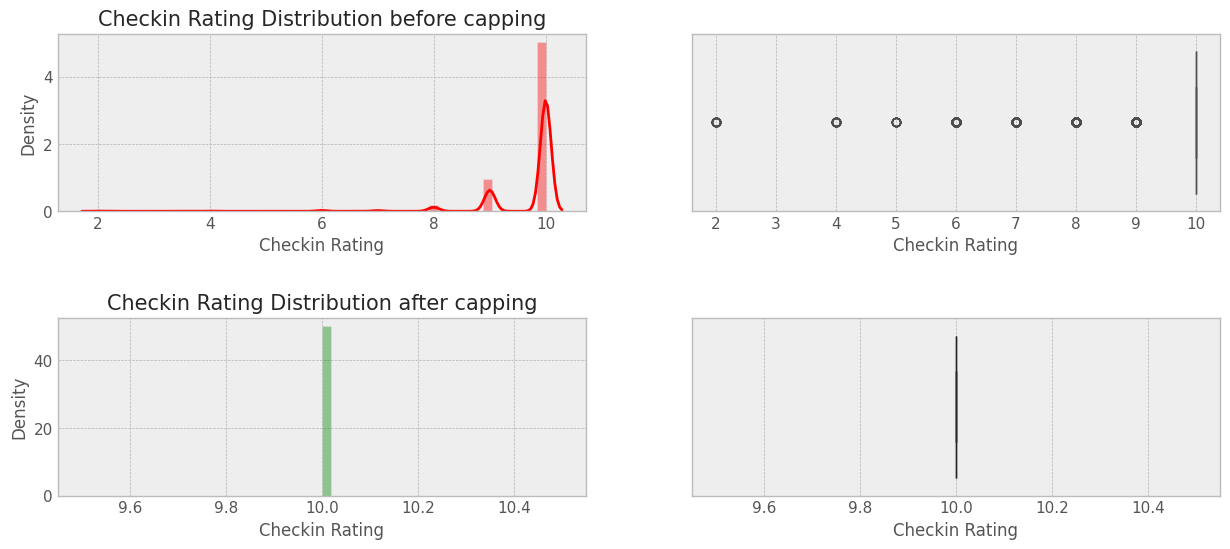

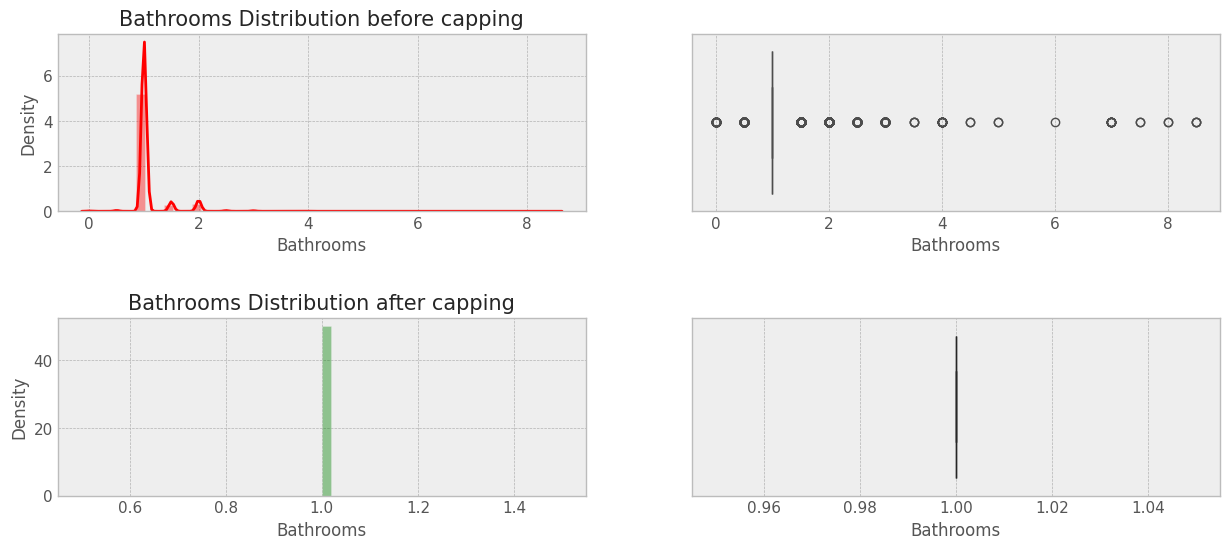

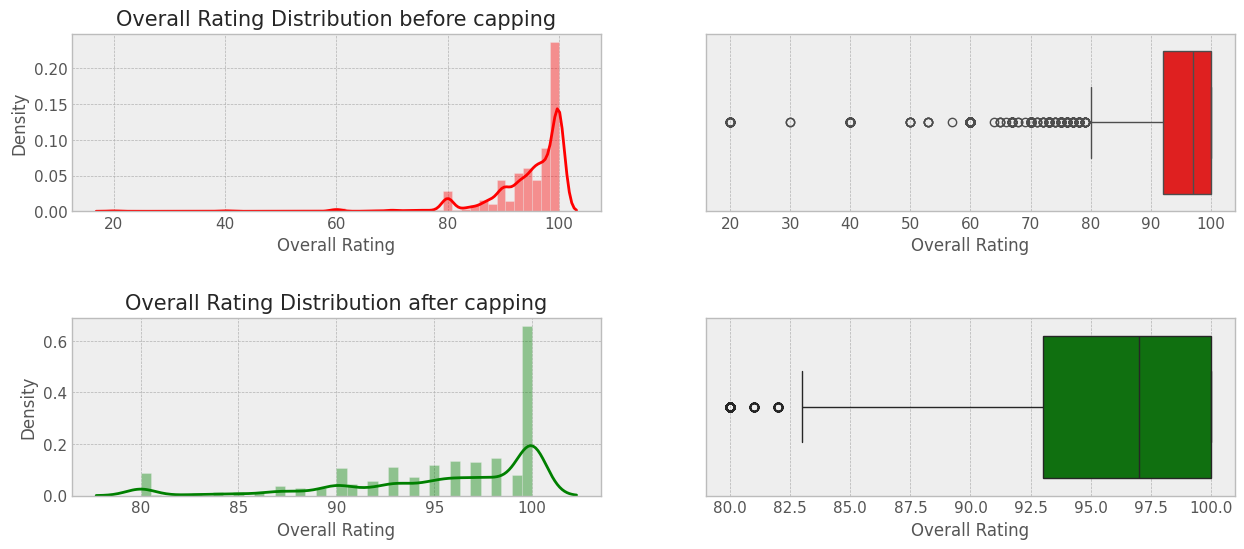

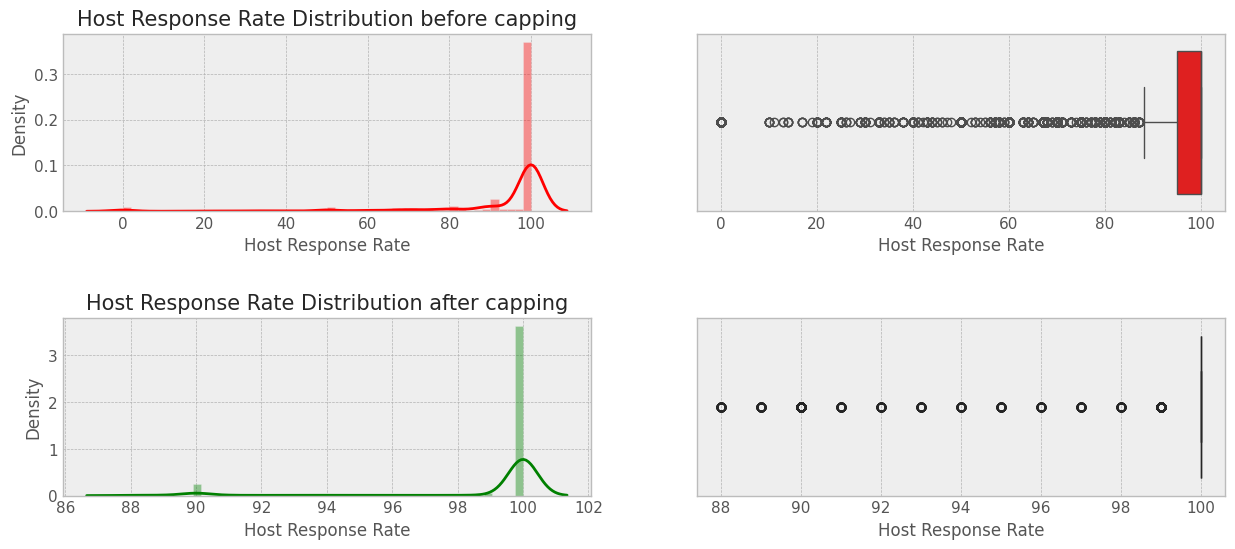

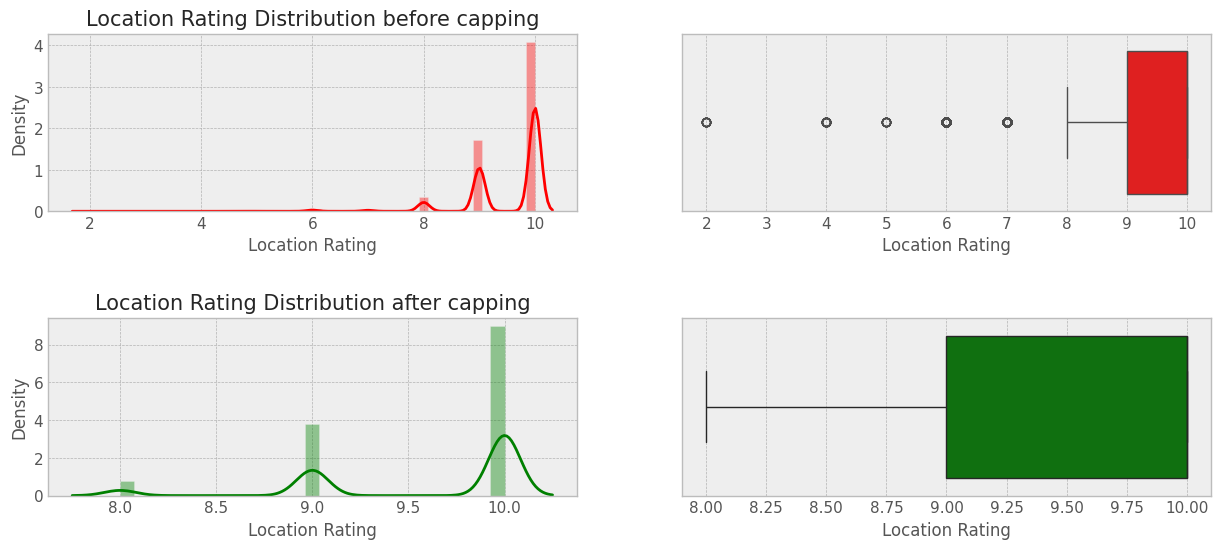

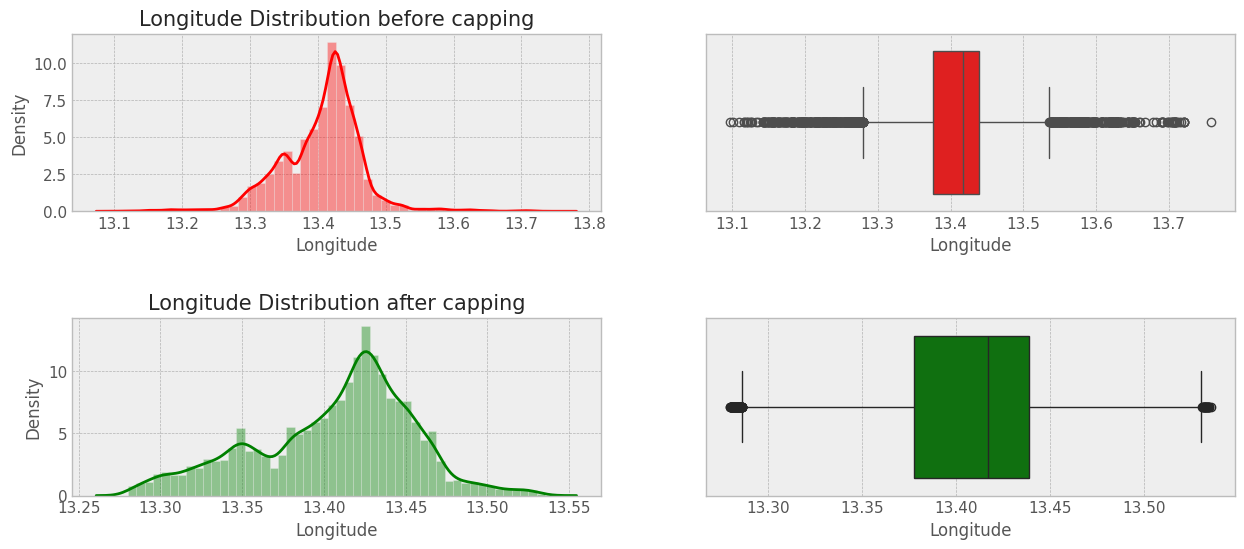

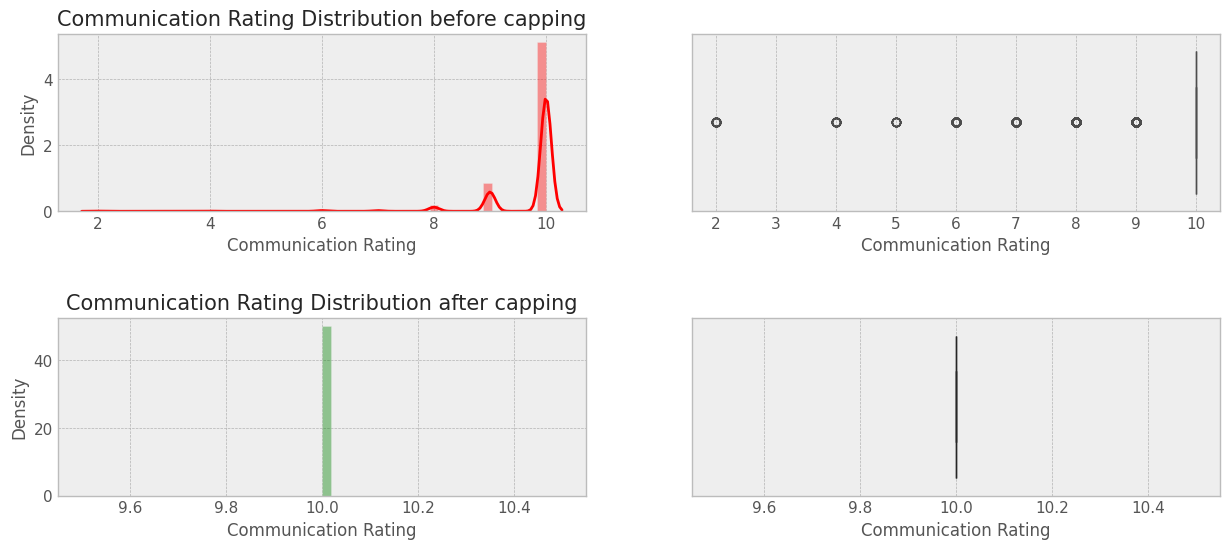

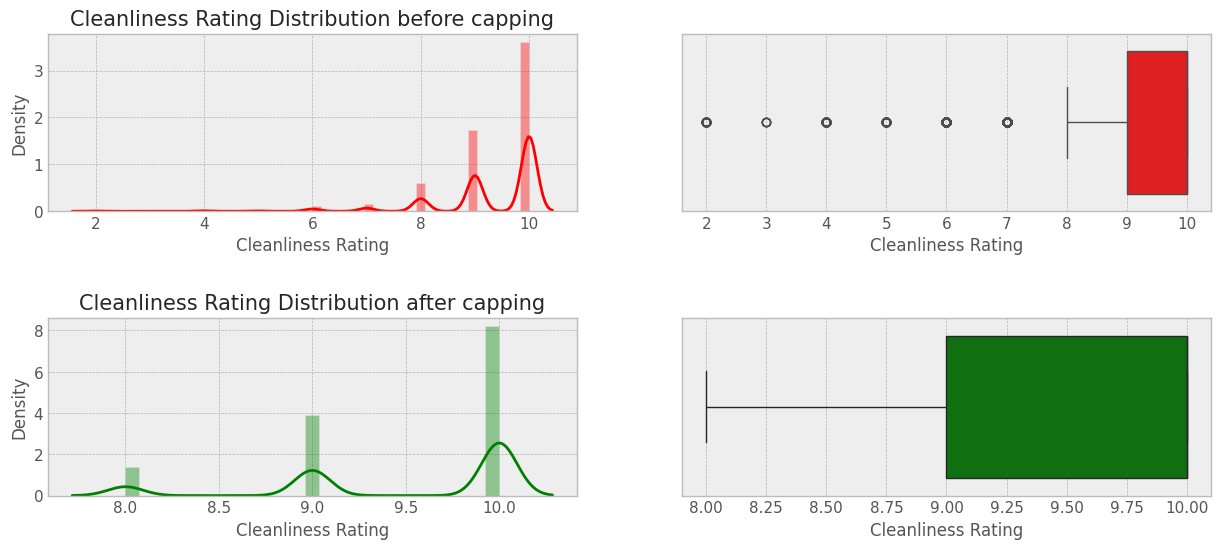

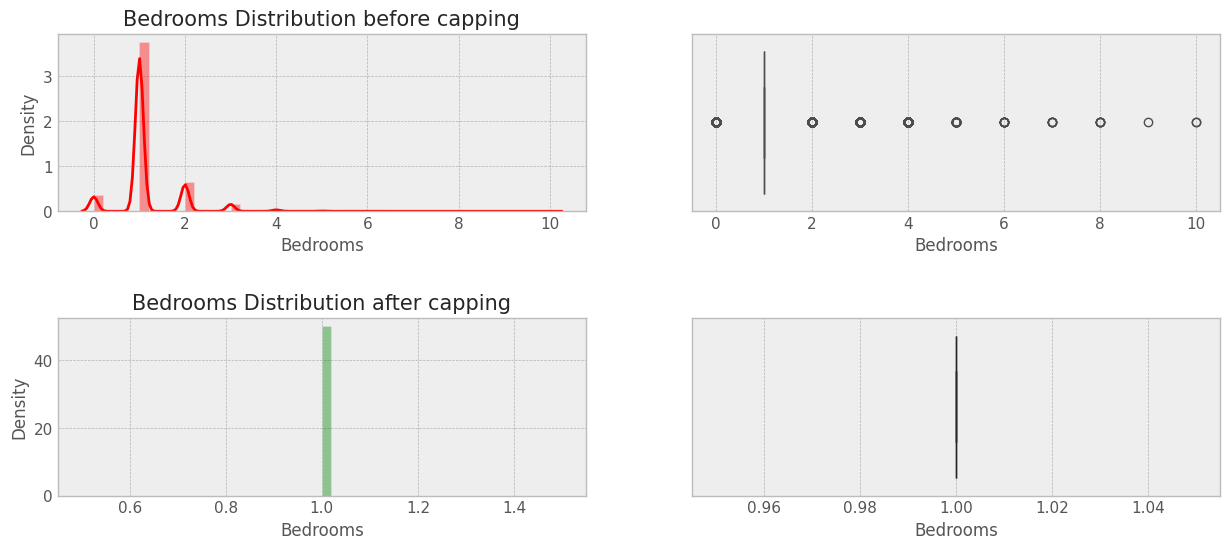

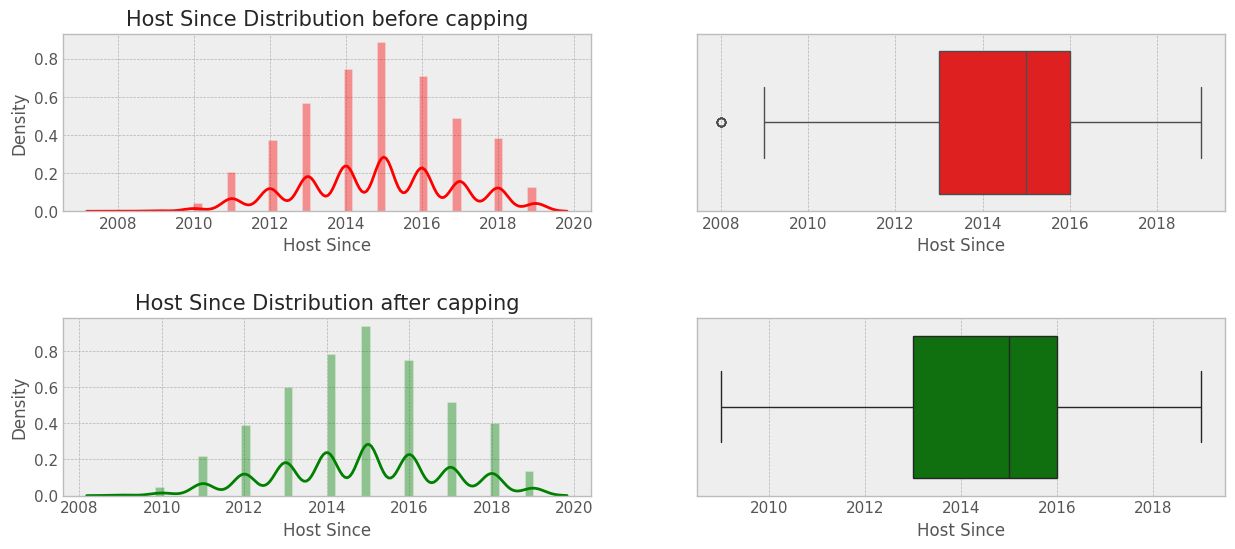

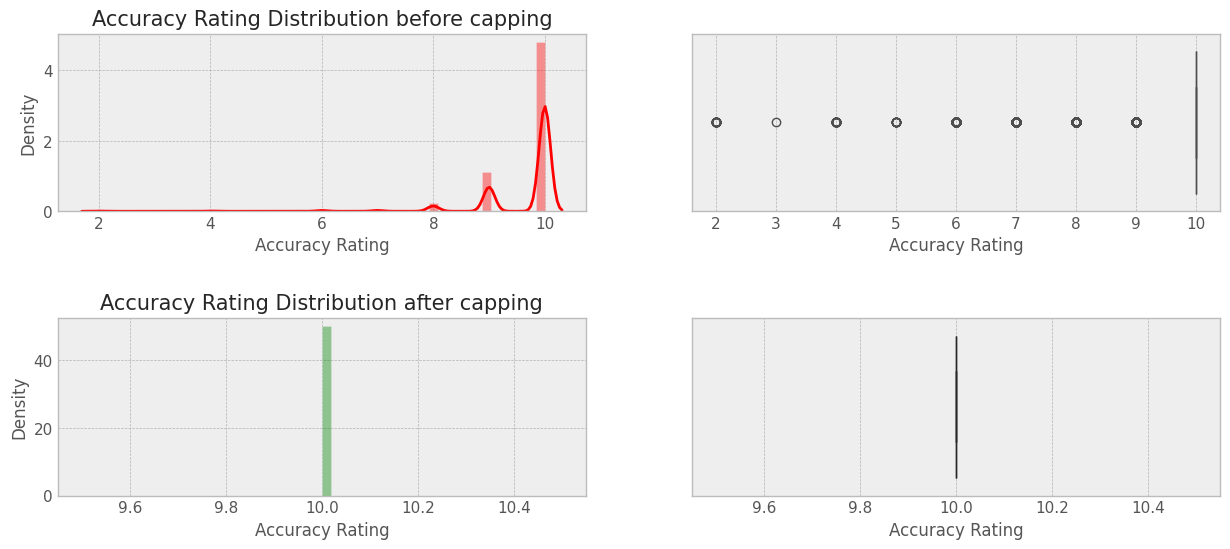

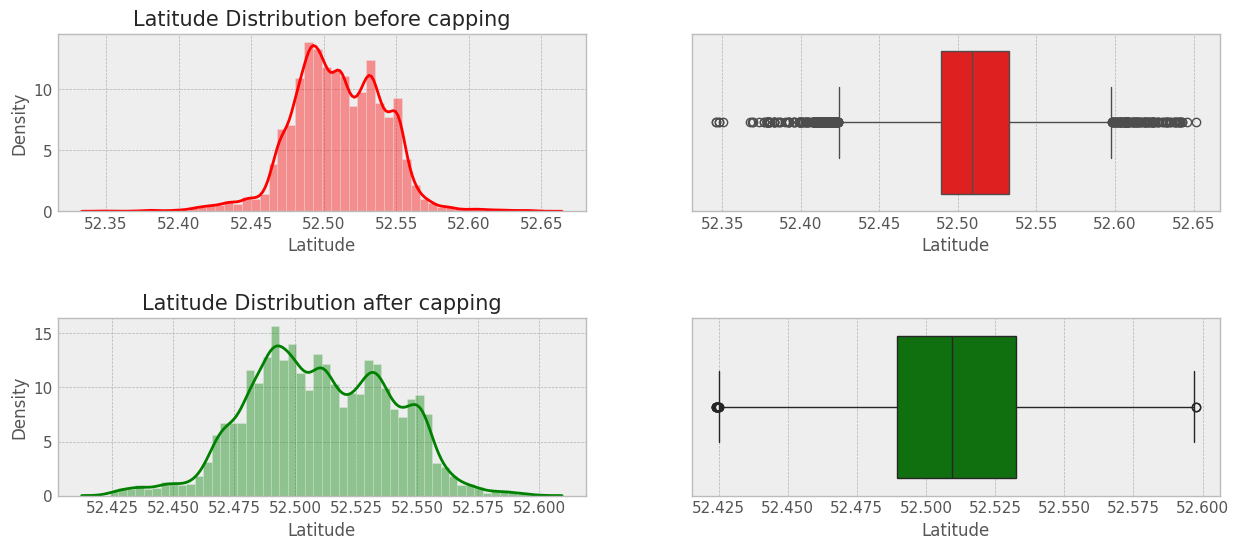

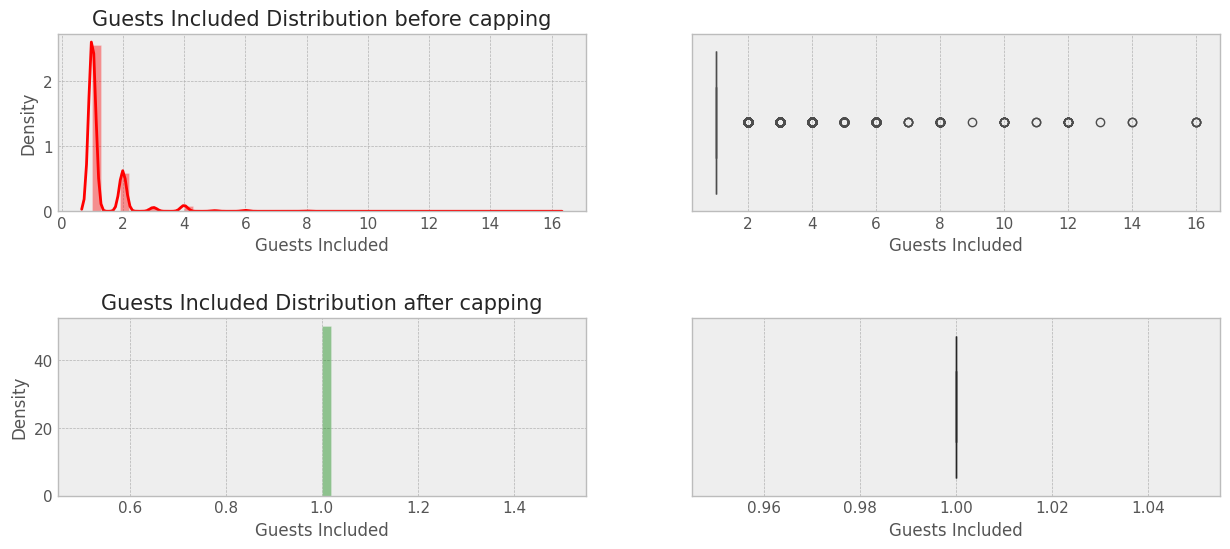

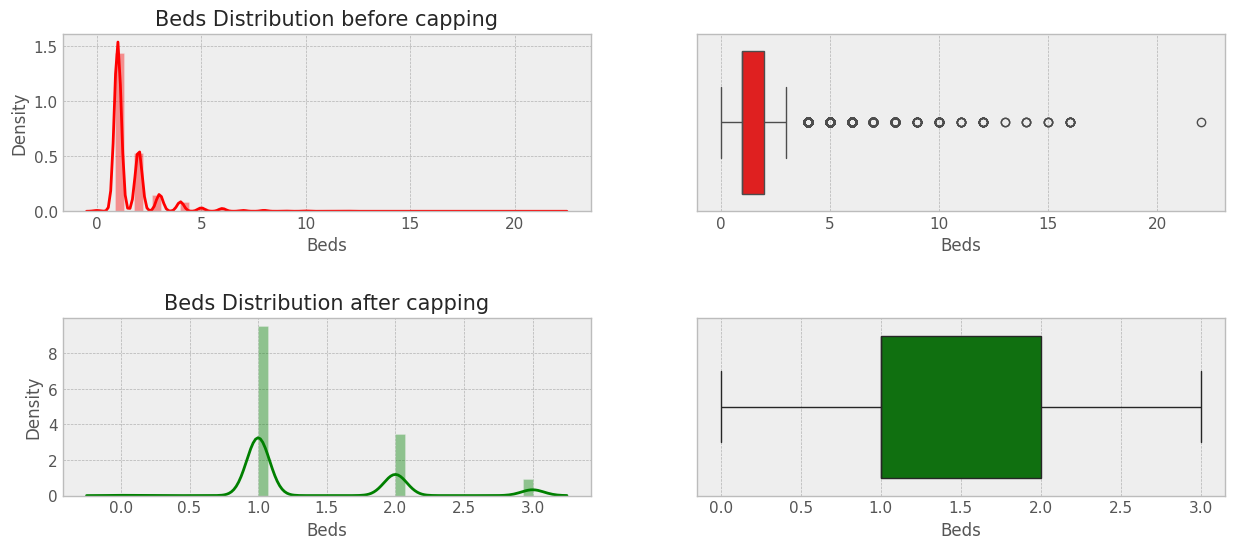

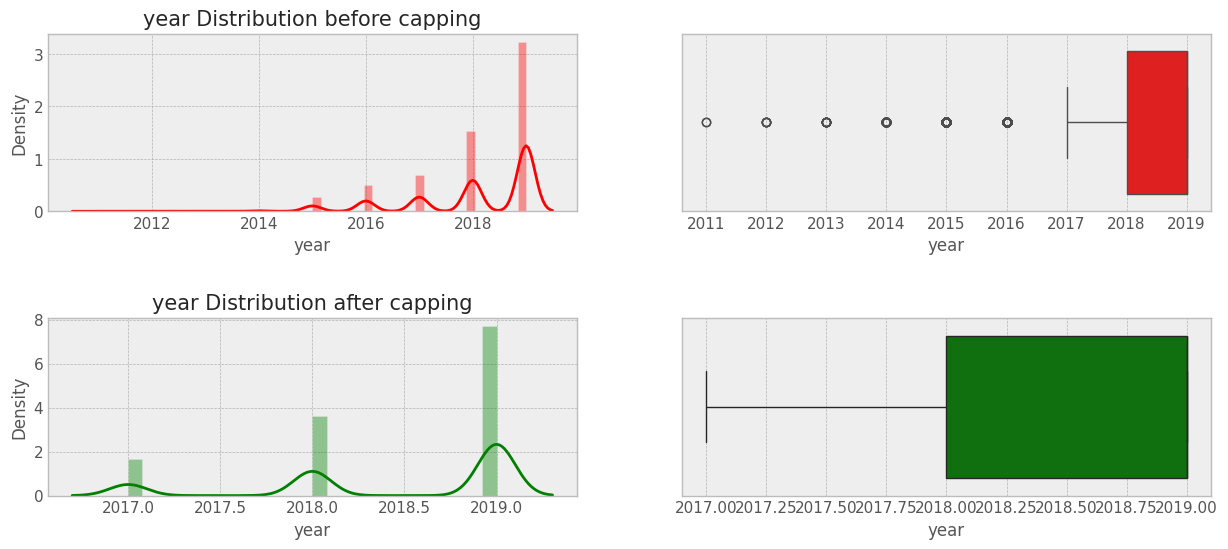

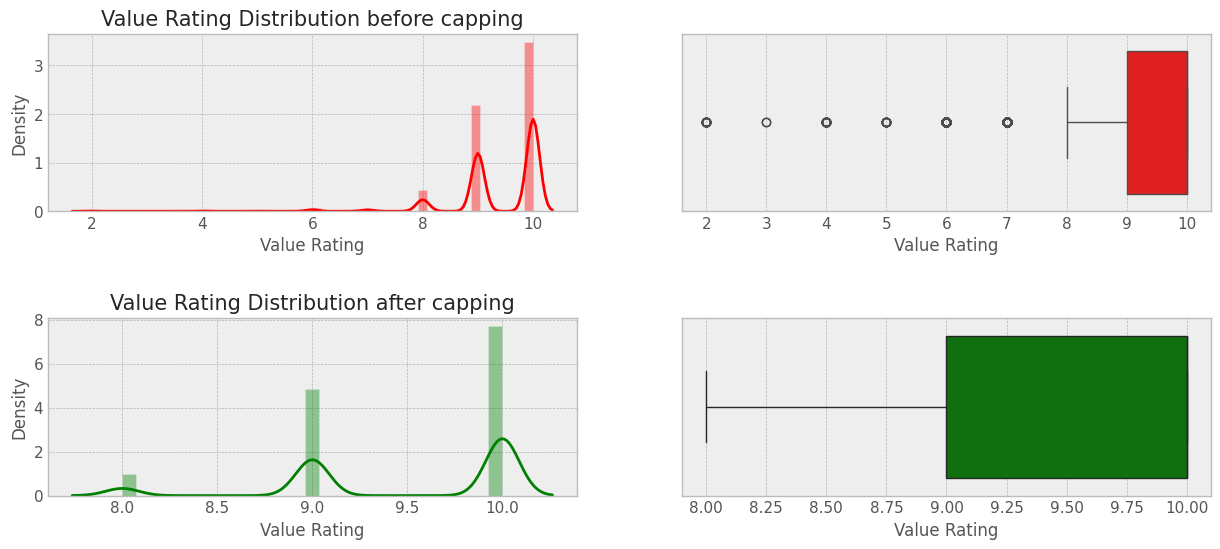

In [54]:
def dist_compare_after_capping(original_df, new, cols):
    for col in relevant_columns_features:
        if col in cols:
            plt.figure(figsize=(15,6))
            plt.subplot(2,2,1)
            sns.distplot(original_df[col],color='red')
            plt.title('{} Distribution before capping'.format(col), fontsize=15)
            plt.subplot(2,2,2)
            sns.boxplot(x=original_df[col],color='red')
            plt.subplots_adjust(hspace = 0.6)
            plt.subplot(2,2,3)
            sns.distplot(new[col],color='green')
            plt.title('{} Distribution after capping'.format(col), fontsize=15)
            plt.subplot(2,2,4)
            sns.boxplot(x=new[col],color='green')
            plt.show()
dist_compare_after_capping(df, temp, outliers_df.index)

In [55]:
remove_outliers=['Bathrooms', 'Accomodates', 'Min Nights', 'Host Response Rate']
remove_outliers

['Bathrooms', 'Accomodates', 'Min Nights', 'Host Response Rate']

Removing outleirs that don't change correlation

In [56]:
#relevant_columns=out_df.loc[out_df['drop']=='yes']['feature']
manipulated_data= df.copy()
for j in range(len(df)):
    for col in remove_outliers:
        if df_outliers.loc[j,col] == 1:
            manipulated_data.loc[j,col] = 0

###**Missing Values**

In [63]:
manipulated_data.head()

Listing ID  Overall Rating  Accuracy Rating  Cleanliness Rating  \
0        2695           100.0             10.0                10.0   
1        3176            92.0              9.0                 9.0   
2        7071            96.0             10.0                10.0   
3        9991           100.0             10.0                10.0   
4       14325            93.0             10.0                10.0   

   Checkin Rating  Communication Rating  Location Rating  Value Rating  Price  \
0            10.0                  10.0              9.0          10.0   17.0   
1             9.0                   9.0             10.0           9.0   90.0   
2            10.0                  10.0             10.0          10.0   33.0   
3            10.0                  10.0             10.0          10.0  180.0   
4             9.0                  10.0              9.0           9.0   70.0   

   Reviews  Bedrooms  Beds  Bathrooms  Host Response Rate  Is Superhost  \
0      7.0       1.0   1.0        1.0                 0.0         False   
1    144.0       1.0   2.0        1.0                 0.0         False   
2    229.0       1.0   2.0        1.0               100.0          True   
3      6.0       4.0   7.0        0.0               100.0         False   
4     23.0       0.0   1.0        1.0               100.0         False   

   Latitude  Longitude  Accomodates  Guests Included  Min Nights  \
0  52.54851   13.40455            2                1           2   
1  52.53500   13.41758            4                2           0   
2  52.54316   13.41509            2                1           2   
3  52.53303   13.41605            0                5           6   
4  52.54785   13.40556            1                1           0   

   Instant Bookable  Host Since  Is Exact Location    year  month   day  \
0             False      2008.0               True  2019.0    4.0  21.0   
1             False      2008.0               True  2018.0   10.0  29.0   
2             False      2009.0               True  2019.0    5.0   8.0   
3             False      2009.0              False  2018.0    7.0  23.0   
4             False      2009.0               True  2018.0   11.0   1.0   

   Postal Code Cleansed Encoded  Neighbourhood Grouped Cleansed Encoded  \
0                             0                                       6   
1                             0                                       6   
2                             0                                       6   
3                             0                                       6   
4                             0                                       6   

   Room Type Encoded  Host Response Rate Cleansed Encoded  \
0                  1                                    1   
1                  0                                    1   
2                  1                                    3   
3                  0                                    3   
4                  0                                    3   

   neighbourhood Encoded  Host Response Time Encoded  \
0                     65                           1   
1                     65                           1   
2                     65                           3   
3                     65                           1   
4                     65                           1   

   Property Type Cleansed Encoded  
0                               0  
1                               0  
2                               0  
3                               0  
4                               0

In [64]:
#Getting a new/updated missing dataset from 'manipulated data' - this time we will call it df_nulls
df_nulls = manipulated_data.copy()
for col in df_nulls:
    if df_nulls[col].isna().sum() == 0:
        del df_nulls[col]
df_nulls


Overall Rating  Accuracy Rating  Cleanliness Rating  Checkin Rating  \
0               100.0             10.0                10.0            10.0   
1                92.0              9.0                 9.0             9.0   
2                96.0             10.0                10.0            10.0   
3               100.0             10.0                10.0            10.0   
4                93.0             10.0                10.0             9.0   
...               ...              ...                 ...             ...   
23531             NaN              NaN                 NaN             NaN   
23532             NaN              NaN                 NaN             NaN   
23533             NaN              NaN                 NaN             NaN   
23534             NaN              NaN                 NaN             NaN   
23535             NaN              NaN                 NaN             NaN   

       Communication Rating  Location Rating  Value Rating  Bedrooms  Beds  \
0                      10.0              9.0          10.0       1.0   1.0   
1                       9.0             10.0           9.0       1.0   2.0   
2                      10.0             10.0          10.0       1.0   2.0   
3                      10.0             10.0          10.0       4.0   7.0   
4                      10.0              9.0           9.0       0.0   1.0   
...                     ...              ...           ...       ...   ...   
23531                   NaN              NaN           NaN       1.0   2.0   
23532                   NaN              NaN           NaN       2.0   2.0   
23533                   NaN              NaN           NaN       1.0   1.0   
23534                   NaN              NaN           NaN       3.0   4.0   
23535                   NaN              NaN           NaN       2.0   2.0   

       Bathrooms  Host Response Rate  Host Since    year  month   day  
0            1.0                 0.0      2008.0  2019.0    4.0  21.0  
1            1.0                 0.0      2008.0  2018.0   10.0  29.0  
2            1.0               100.0      2009.0  2019.0    5.0   8.0  
3            0.0               100.0      2009.0  2018.0    7.0  23.0  
4            1.0               100.0      2009.0  2018.0   11.0   1.0  
...          ...                 ...         ...     ...    ...   ...  
23531        1.0                 0.0      2018.0     NaN    NaN   NaN  
23532        1.0                 NaN      2019.0     NaN    NaN   NaN  
23533        0.0                 NaN      2014.0     NaN    NaN   NaN  
23534        1.0                 NaN      2019.0     NaN    NaN   NaN  
23535        1.0                 NaN      2018.0     NaN    NaN   NaN  

[23536 rows x 15 columns]

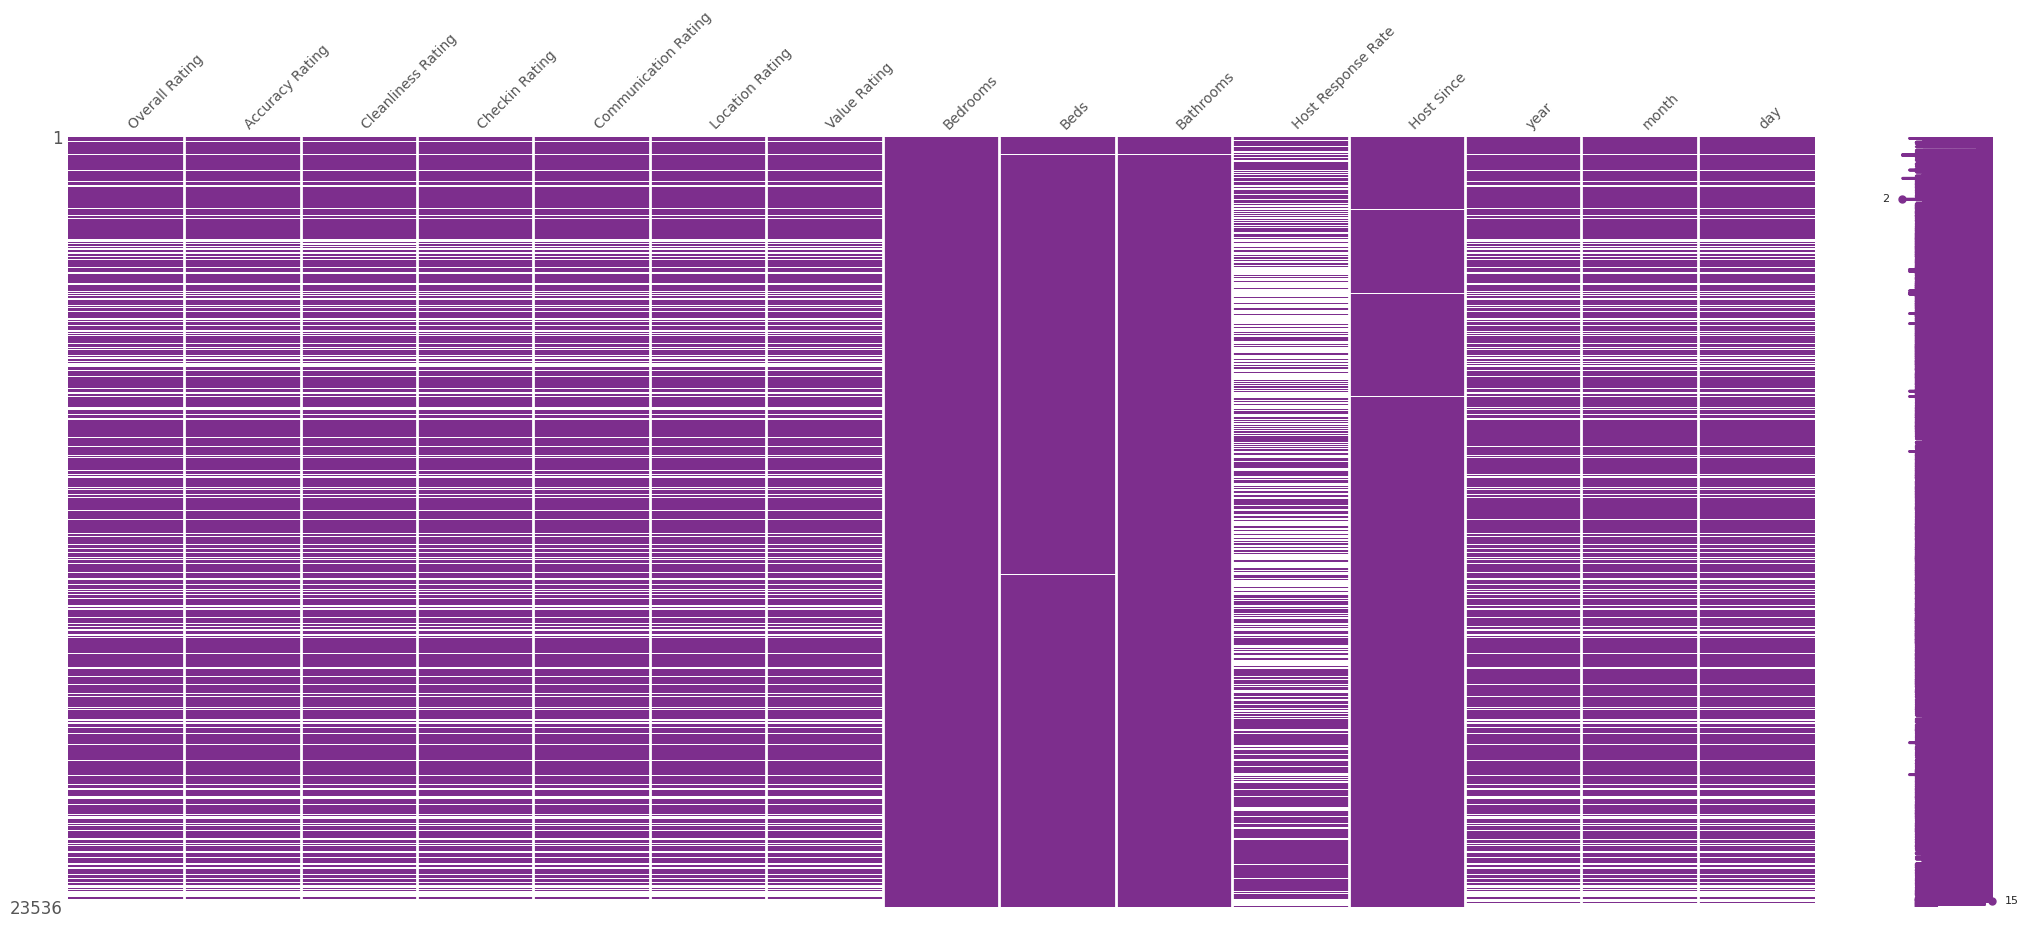

In [69]:
msno.matrix(df_nulls,color=(0.4940,0.1840,0.5560),fontsize=10);

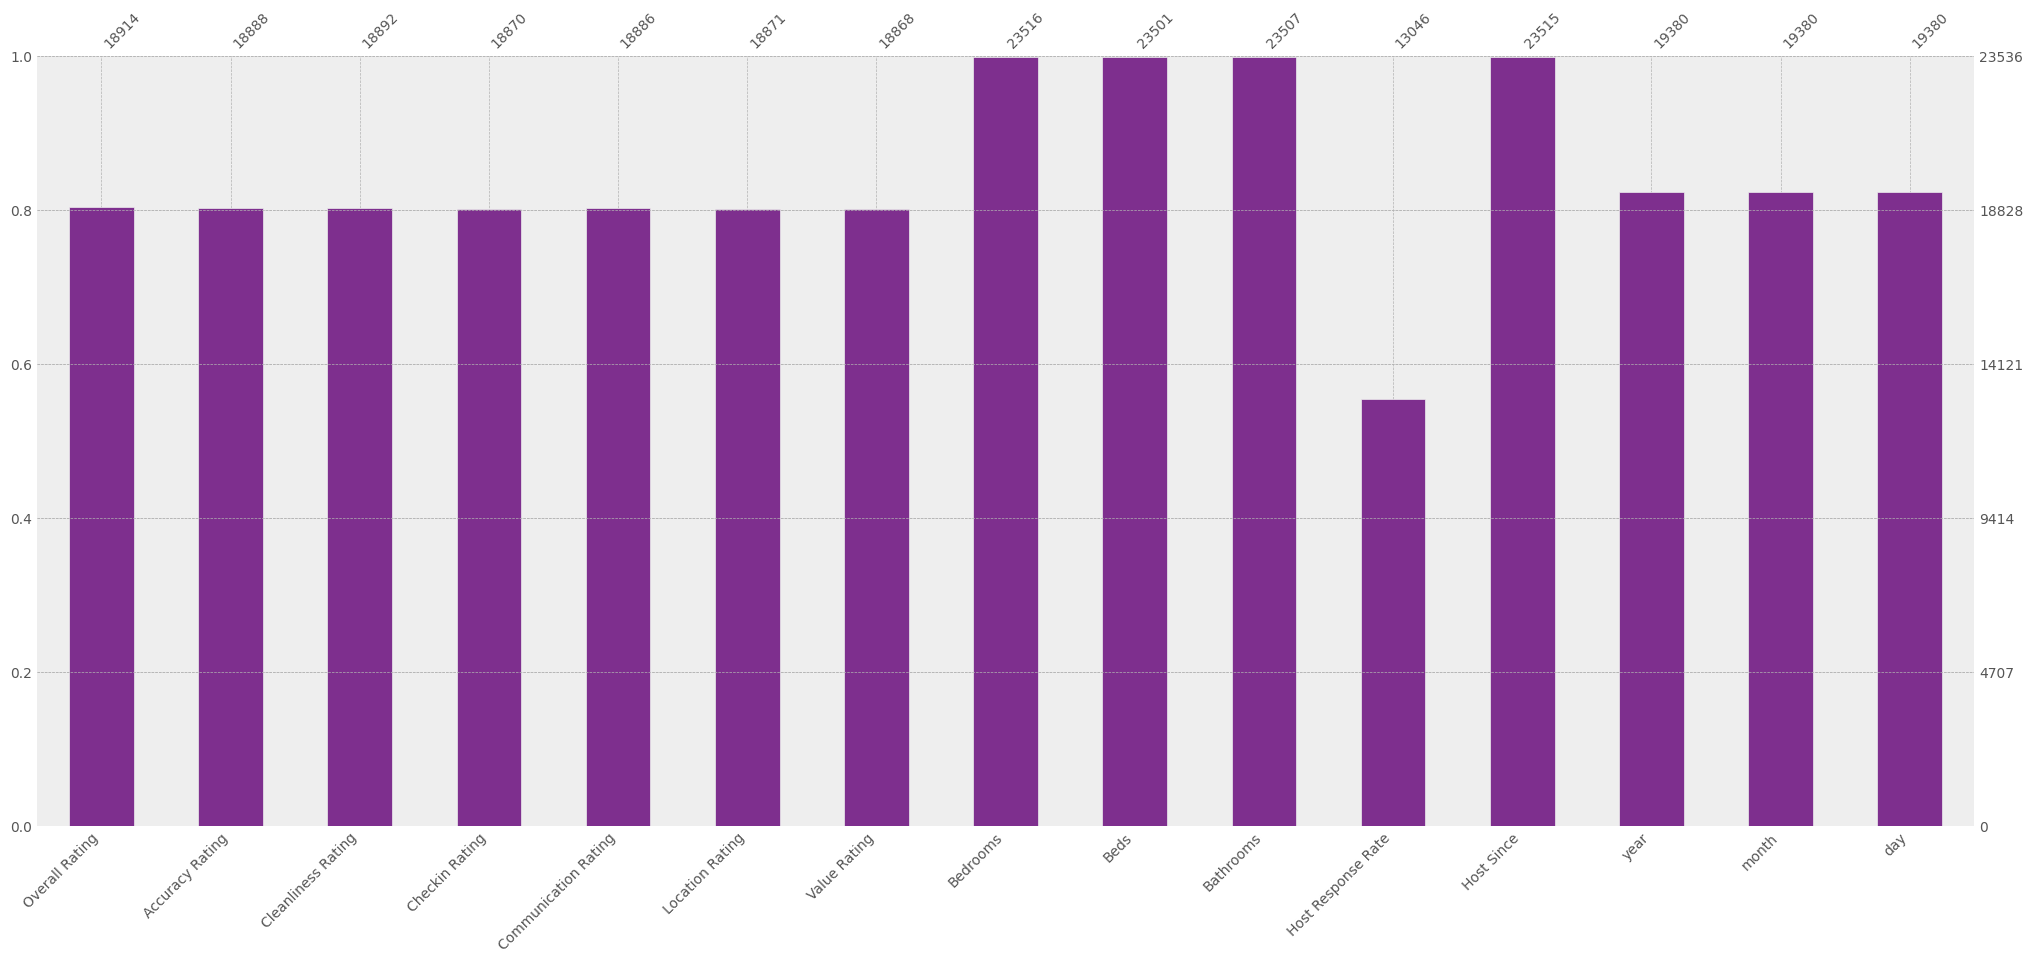

In [71]:
msno.bar(df_nulls,color=(0.4940,0.1840,0.5560),fontsize=10);

Updated missing values count and frequency after outliers removal:

In [80]:
mis_val = df_nulls.isna().sum()
mis_val_per = df_nulls.isna().sum()/len(df_nulls)*100
mis_val_table = pd.concat([mis_val, mis_val_per], axis=1)
mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,:] != 0].sort_values(
     '% of Total Values', ascending=False).round(1)
mis_val_table_ren_columns

Missing Values  % of Total Values
Host Response Rate             10490               44.6
Value Rating                    4668               19.8
Checkin Rating                  4666               19.8
Location Rating                 4665               19.8
Communication Rating            4650               19.8
Accuracy Rating                 4648               19.7
Cleanliness Rating              4644               19.7
Overall Rating                  4622               19.6
year                            4156               17.7
month                           4156               17.7
day                             4156               17.7
Beds                              35                0.1
Bathrooms                         29                0.1
Host Since                        21                0.1
Bedrooms                          20                0.1

In [81]:
mis_val_table_ren_columns.sum()

Missing Values       55626.0
% of Total Values      236.3
dtype: float64

Creating a dataframe with missing values as 1 and existing values as 0:



In [82]:
df_missing_data = manipulated_data.isin([np.nan])
df_missing_data = df_missing_data.astype('int')
df_missing_data

Listing ID  Overall Rating  Accuracy Rating  Cleanliness Rating  \
0               0               0                0                   0   
1               0               0                0                   0   
2               0               0                0                   0   
3               0               0                0                   0   
4               0               0                0                   0   
...           ...             ...              ...                 ...   
23531           0               1                1                   1   
23532           0               1                1                   1   
23533           0               1                1                   1   
23534           0               1                1                   1   
23535           0               1                1                   1   

       Checkin Rating  Communication Rating  Location Rating  Value Rating  \
0                   0                     0                0             0   
1                   0                     0                0             0   
2                   0                     0                0             0   
3                   0                     0                0             0   
4                   0                     0                0             0   
...               ...                   ...              ...           ...   
23531               1                     1                1             1   
23532               1                     1                1             1   
23533               1                     1                1             1   
23534               1                     1                1             1   
23535               1                     1                1             1   

       Price  Reviews  Bedrooms  Beds  Bathrooms  Host Response Rate  \
0          0        0         0     0          0                   0   
1          0        0         0     0          0                   0   
2          0        0         0     0          0                   0   
3          0        0         0     0          0                   0   
4          0        0         0     0          0                   0   
...      ...      ...       ...   ...        ...                 ...   
23531      0        0         0     0          0                   0   
23532      0        0         0     0          0                   1   
23533      0        0         0     0          0                   1   
23534      0        0         0     0          0                   1   
23535      0        0         0     0          0                   1   

       Is Superhost  Latitude  Longitude  Accomodates  Guests Included  \
0                 0         0          0            0                0   
1                 0         0          0            0                0   
2                 0         0          0            0                0   
3                 0         0          0            0                0   
4                 0         0          0            0                0   
...             ...       ...        ...          ...              ...   
23531             0         0          0            0                0   
23532             0         0          0            0                0   
23533             0         0          0            0                0   
23534             0         0          0            0                0   
23535             0         0          0            0                0   

       Min Nights  Instant Bookable  Host Since  Is Exact Location  year  \
0               0                 0           0                  0     0   
1               0                 0           0                  0     0   
2               0                 0           0                  0     0   
3               0                 0           0                  0     0   
4               0                 0           0

Creating df including numeric features of the later data - manipulated_data

In [83]:
#Selecting numeric data
numeric_manipulated_data = manipulated_data.select_dtypes(include=[np.number])
numeric_manipulated_data.columns

Index(['Listing ID', 'Overall Rating', 'Accuracy Rating', 'Cleanliness Rating',
       'Checkin Rating', 'Communication Rating', 'Location Rating',
       'Value Rating', 'Price', 'Reviews', 'Bedrooms', 'Beds', 'Bathrooms',
       'Host Response Rate', 'Latitude', 'Longitude', 'Accomodates',
       'Guests Included', 'Min Nights', 'Host Since', 'year', 'month', 'day',
       'Postal Code Cleansed Encoded',
       'Neighbourhood Grouped Cleansed Encoded', 'Room Type Encoded',
       'Host Response Rate Cleansed Encoded', 'neighbourhood Encoded',
       'Host Response Time Encoded', 'Property Type Cleansed Encoded'],
      dtype='object')

Difference in the distribution of a variable when another variable is with or without MV:

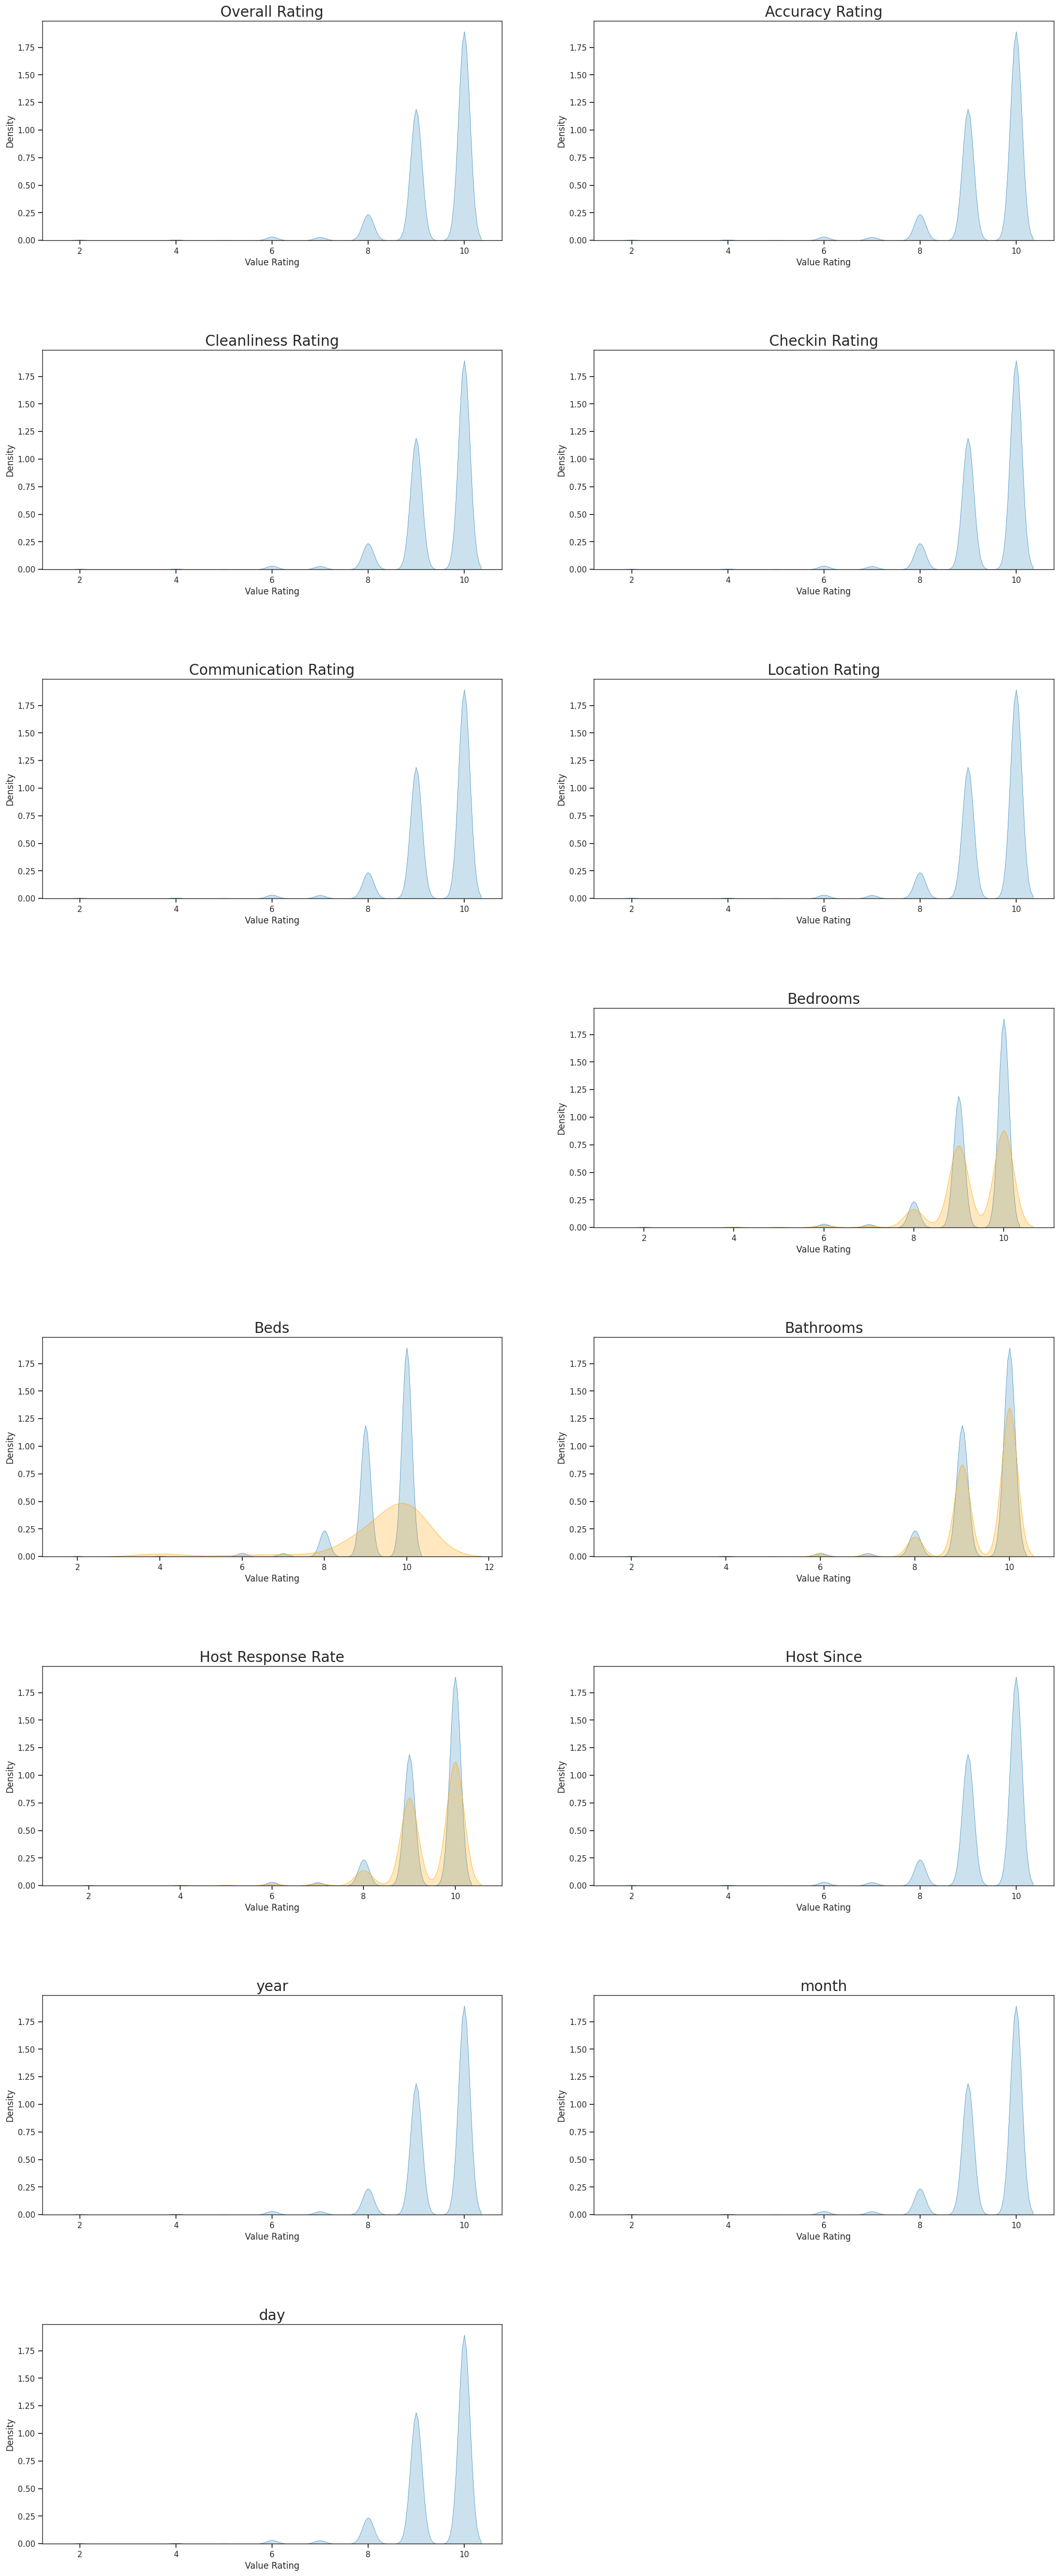

In [84]:
#c = numeric_manipulated_data.columns
colist = df_nulls.columns
#names = missing_names
#sns.set(font_scale = 0.8)
#sns.set_style("whitegrid")
sns.set_style("ticks")
sns.set
a=len(colist)
b=2
c=1
fig = plt.figure(figsize=(25,120))
plt.subplots_adjust(hspace=0.5)
for j in df_nulls:
        if j!=i :
            plt.subplot(a,b,c)
            plt.title('{}'.format(j),fontsize=20)
            plt.xlabel(i)
            sns.kdeplot(df[i],fill=True)
            sns.kdeplot(df[i].loc[df_nulls[j]==0],fill=True,color='orange')
        c=c+1

plt.show()

Exploring data the segnificunce of distribution change:



In [86]:
#le = preprocessing.LabelEncoder()
MV_df_final = pd.DataFrame(columns= ['Var', 'MV_pct', 'distribution_changed'])
#df[m] = le.fit_transform(df[m].astype(str))
m=numeric_manipulated_data.copy()
#m = manipulated_data._get_numeric_data().columns.dropna().unique()
np.seterr(divide='ignore', invalid='ignore')
for i in m:
    # and i in mis_val_table_ren_columns.index.tolist():
    # column with NULLS
        null = m[i]
    # column without NULLS
        non = m[i].loc[df_missing_data[i]==0]
    # target value with NULLS
        price_null = m['Price']
    # target value without NULLS
        superhost_non = price_null.loc[df_missing_data[i]==0]
        mv = df_missing_data[i].sum()
    # perform Kolmogorov-Smirnov test
        pval = ks_2samp(null, non)[1]
        dis_change = np.where(pval<0.5,'+','-')
        # Instead of append, use concat to add a new row
        MV_df_final = pd.concat([MV_df_final, pd.DataFrame([{'Var': i, 'MV_pct': mv, 'distribution_changed': dis_change}])], ignore_index=True)
MV_df_final

Var MV_pct distribution_changed
0                               Listing ID      0                    -
1                           Overall Rating   4622                    -
2                          Accuracy Rating   4648                    -
3                       Cleanliness Rating   4644                    -
4                           Checkin Rating   4666                    -
5                     Communication Rating   4650                    -
6                          Location Rating   4665                    -
7                             Value Rating   4668                    -
8                                    Price      0                    -
9                                  Reviews      0                    -
10                                Bedrooms     20                    -
11                                    Beds     35                    -
12                               Bathrooms     29                    -
13                      Host Response Rate  10490                    -
14                                Latitude      0                    -
15                               Longitude      0                    -
16                             Accomodates      0                    -
17                         Guests Included      0                    -
18                              Min Nights      0                    -
19                              Host Since     21                    -
20                                    year   4156                    -
21                                   month   4156                    -
22                                     day   4156                    -
23            Postal Code Cleansed Encoded      0                    -
24  Neighbourhood Grouped Cleansed Encoded      0                    -
25                       Room Type Encoded      0                    -
26     Host Response Rate Cleansed Encoded      0                    -
27                   neighbourhood Encoded      0                    -
28              Host Response Time Encoded      0                    -
29          Property Type Cleansed Encoded      0                    -

<Axes: >

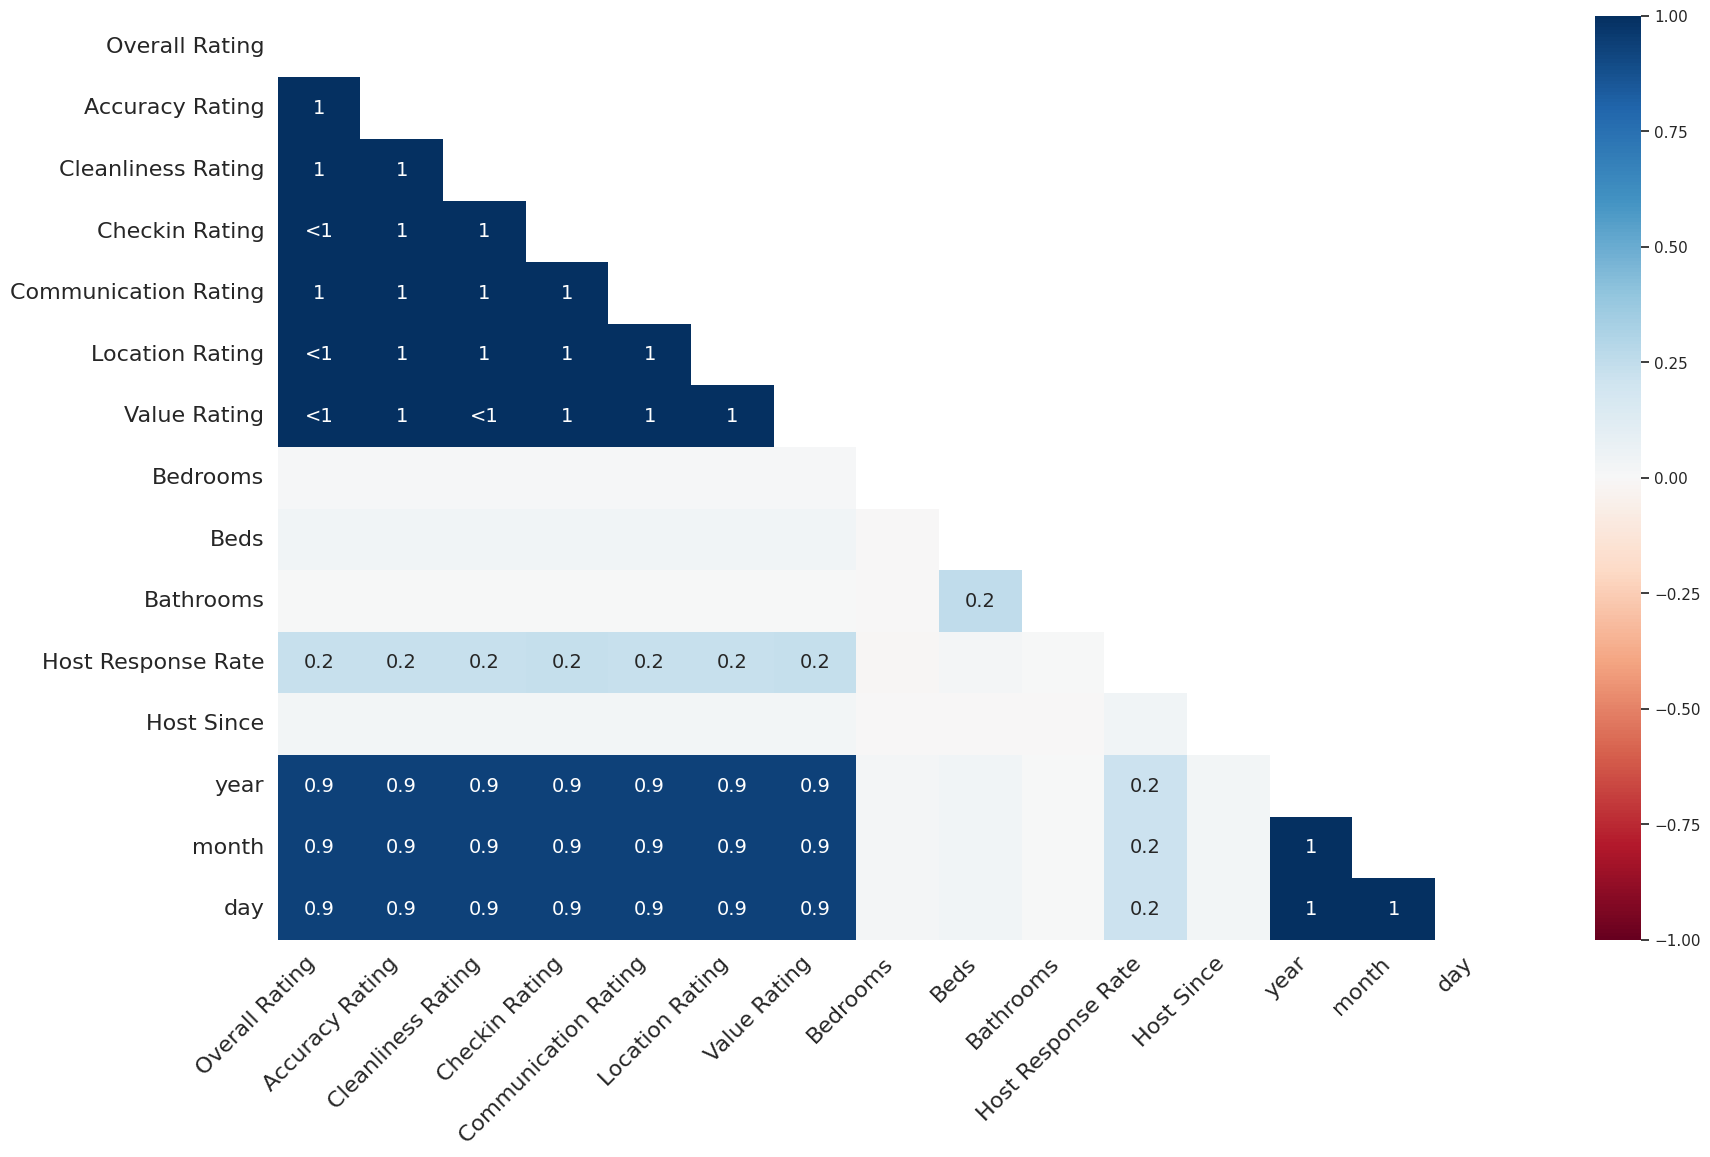

In [87]:
msno.heatmap(manipulated_data)

In [88]:
MV_df_final['drop']= 'Yes'
MV_df_final['MV_type']= 'MCAR/MAR'
MV_df_final.loc[(MV_df_final.distribution_changed== '+'),'drop']='No'
MV_df_final.loc[(MV_df_final.distribution_changed== '+'),'MV_type']='MNAR'
MV_df_final = MV_df_final[MV_df_final['MV_pct']>0].sort_values(by='MV_pct', ascending=False)
MV_df_final

Var MV_pct distribution_changed drop   MV_type
13    Host Response Rate  10490                    -  Yes  MCAR/MAR
7           Value Rating   4668                    -  Yes  MCAR/MAR
4         Checkin Rating   4666                    -  Yes  MCAR/MAR
6        Location Rating   4665                    -  Yes  MCAR/MAR
5   Communication Rating   4650                    -  Yes  MCAR/MAR
2        Accuracy Rating   4648                    -  Yes  MCAR/MAR
3     Cleanliness Rating   4644                    -  Yes  MCAR/MAR
1         Overall Rating   4622                    -  Yes  MCAR/MAR
20                  year   4156                    -  Yes  MCAR/MAR
21                 month   4156                    -  Yes  MCAR/MAR
22                   day   4156                    -  Yes  MCAR/MAR
11                  Beds     35                    -  Yes  MCAR/MAR
12             Bathrooms     29                    -  Yes  MCAR/MAR
19            Host Since     21                    -  Yes  MCAR/MAR
10              Bedrooms     20                    -  Yes  MCAR/MAR

###Data Imputation TBD
Altought the columns that are recomended for removal are marked with '+' in the "distribution chage" in the prevous table. We will create different solutions to difference data. Total of 22 columns to treat



In [89]:
df_final=manipulated_data
df_nulls.columns

Index(['Overall Rating', 'Accuracy Rating', 'Cleanliness Rating',
       'Checkin Rating', 'Communication Rating', 'Location Rating',
       'Value Rating', 'Bedrooms', 'Beds', 'Bathrooms', 'Host Response Rate',
       'Host Since', 'year', 'month', 'day'],
      dtype='object')

In [72]:
df_nulls.columns

Index(['Overall Rating', 'Accuracy Rating', 'Cleanliness Rating',
       'Checkin Rating', 'Communication Rating', 'Location Rating',
       'Value Rating', 'Bedrooms', 'Beds', 'Bathrooms', 'Host Response Rate',
       'Host Since', 'year', 'month', 'day'],
      dtype='object')

In [ ]:
# import pandas as pd

# # Creating a DataFrame
# data = {'Name': ['Alice', 'Bob', 'Charlie'],
#         'Age': [25, 30, 35],
#         'City': ['New York', 'Los Angeles', 'Chicago']}


# for j in range(len(df)):
#   print(j)

# # df123 = pd.DataFrame(data)
# # df123

# # # Accessing the value at row index 1 and column 'Age'
# # value = df123.loc[1, 'Age']
# # print(value)  # Output: 30

# # # Modifying the value at row index 2 and column 'City'
# # df123.loc[2, 'City'] = 'San Francisco'
# # print(df123)


In [55]:
# from autoviz.AutoViz_Class import AutoViz_Class
# import missingno as msno
# import matplotlib.pyplot as plt
# %matplotlib inline
# AV = AutoViz_Class()
# AV.AutoViz(filename="", sep=",", depVar="Price", dfte=df_aggregated, max_cols_analyzed=10)


In [56]:
# from geopy.distance import great_circle
# def distance_to_mid(lat, lon):
#     berlin_centre = (52.5027778, 13.404166666666667)
#     accommodation = (lat, lon)
#     return great_circle(berlin_centre, accommodation).km

# df_aggregated['Distance From Center Cleansed'] = df_aggregated.apply(lambda row: round(distance_to_mid(row['Latitude'], row['Longitude']), 1), axis=1)
# bins = [0, 0.5, 1, 2, 4, 8, 16]
# labels = ["Center", "Cercile1 ", "Cercile2", "Cercile4", "Cercile8", "Cercile16"]

# # Apply pd.cut() to create a new binned column
# df_aggregated["Distance From Center Grouped Cleansed"] = pd.cut(df_aggregated["Distance From Center Cleansed"], bins=bins, labels=labels, include_lowest=True)
# # df_aggregated.drop(columns=["Distance From Center Cleansed"], inplace=True)
# # df_aggregated.drop(columns=["Latitude","Longitude"], inplace=True)
